In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   
#from Models import *
import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5j0n.mrc


NGLWidget()

In [26]:
file_name = './data/5j0n.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol1      = np.array(mrcVol.data) 
    ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(Vol1.shape)

(69, 57, 75)


In [27]:
import nglview as nv
PROTEIN = "5a1a"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5a1a.mrc


NGLWidget()

In [28]:
file_name = '5a1a.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol2      = np.array(mrcVol.data) 
    ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(Vol2.shape)

(110, 155, 199)


In [29]:
# Then make 2 vol the same size
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol1 = zoom(Vol1, (15/69, 15/57, 15/75))
print(Vol1.shape)
NewVol = np.zeros((20, 20, 20))
NewVol[:15, :15, :15] = Vol1
Vol1 = NewVol
ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(ProjSize1)

Vol2 = zoom(Vol2, (15/110, 15/155, 15/199))
print(Vol2.shape)
NewVol = np.zeros((20, 20, 20))
NewVol[5:, 5:, 5:] = Vol2
Vol2 = NewVol
ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(ProjSize2)

(15, 15, 15)
34
(15, 15, 15)
34


In [30]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [31]:
#Here we create Vol1 orthogonal to Vol2
"""
import copy 
print(Vol2.shape)
vecVol2 = Vol2.reshape(-1, order = 'F')
print(vecVol2.shape)
vecVol1 = copy.deepcopy(vecVol2)
for i in range(3375 - 1):
    if i % 2 == 0:
        vecVol1[i] = - vecVol2[i + 1]
    else:
        vecVol1[i] = vecVol2[i - 1]
vecVol1[-1] = 0
print(np.sum(vecVol1*vecVol2))
print(vecVol2[1500:1506])
print(vecVol1[1500:1506])
Vol1 = vecVol1.reshape(15, 15, 15 , order = 'F')
"""


"\nimport copy \nprint(Vol2.shape)\nvecVol2 = Vol2.reshape(-1, order = 'F')\nprint(vecVol2.shape)\nvecVol1 = copy.deepcopy(vecVol2)\nfor i in range(3375 - 1):\n    if i % 2 == 0:\n        vecVol1[i] = - vecVol2[i + 1]\n    else:\n        vecVol1[i] = vecVol2[i - 1]\nvecVol1[-1] = 0\nprint(np.sum(vecVol1*vecVol2))\nprint(vecVol2[1500:1506])\nprint(vecVol1[1500:1506])\nVol1 = vecVol1.reshape(15, 15, 15 , order = 'F')\n"

In [32]:
Projections1 = generate_projections_ASTRA(Vol1, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections1 = np.array(Projections1, dtype=dtype)

Projections2 = generate_projections_ASTRA(Vol2, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections2 = np.array(Projections2, dtype=dtype)

0.030323733


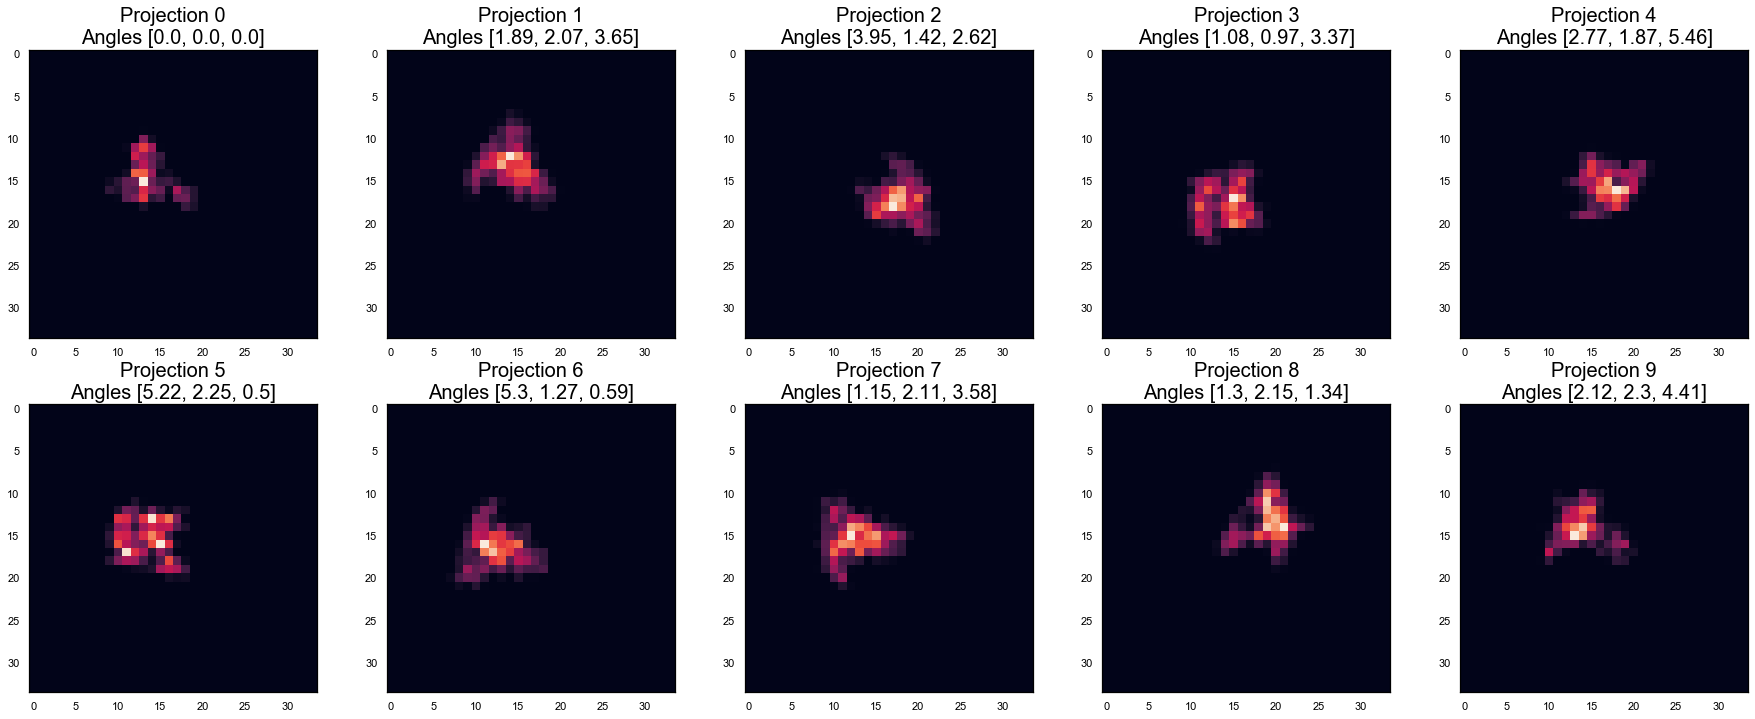

0.16001888


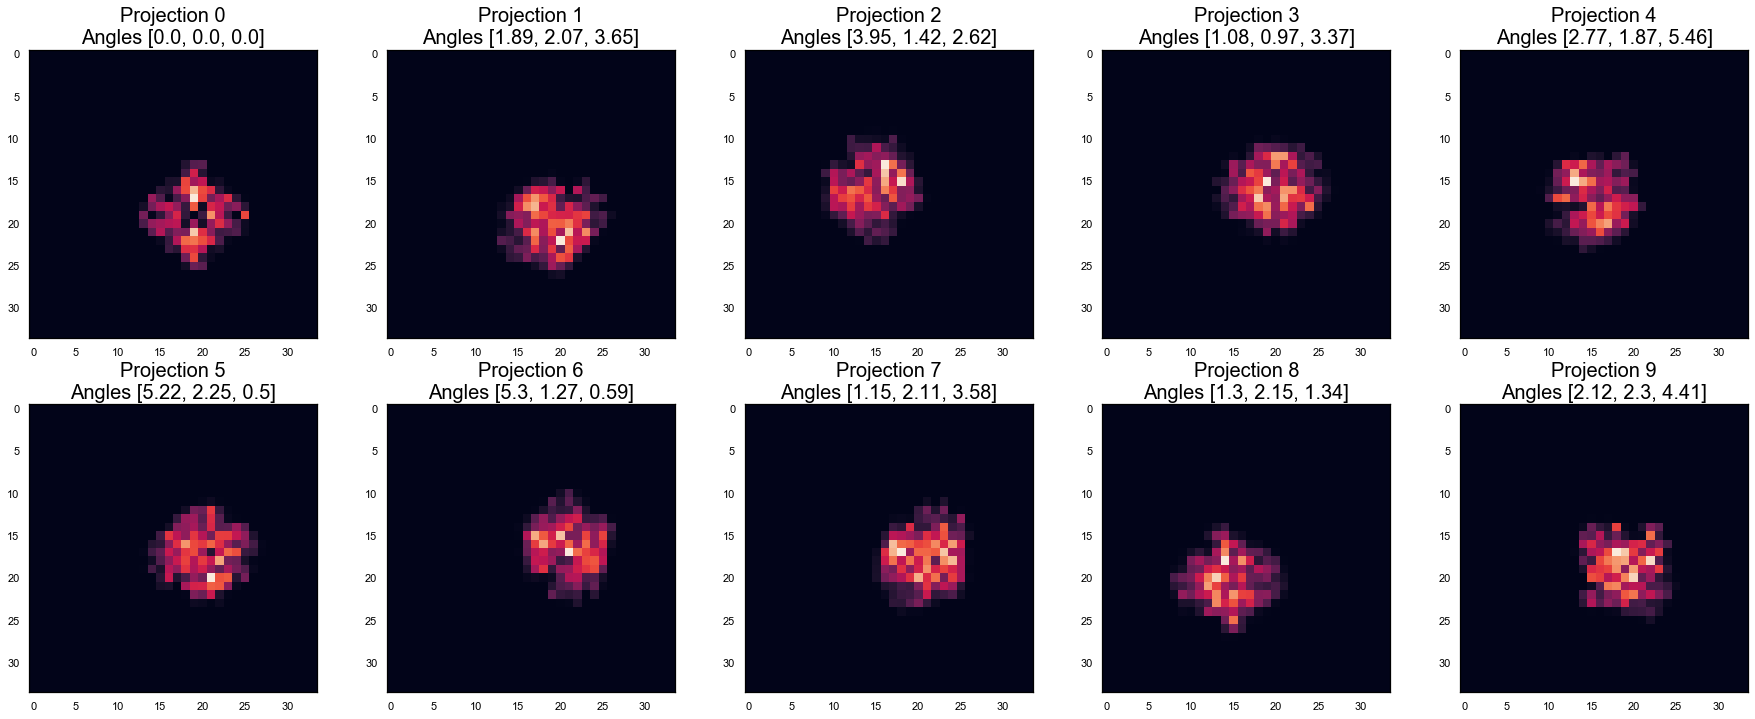

In [33]:
pids = range(10)
print(np.mean(Projections1))
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

pids = range(10)
print(np.mean(Projections2))
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [18]:
#BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [19]:
#print(BP_data.shape)
##print(BP_data[0].shape)
#print(Projections[0].shape)
#print(np.sum(BP_data[0] - Projections[0]))

In [20]:
#CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
#pids = range(10)
#plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

Before getting started, we now only get $\mu_s$, which should be mean subtracted. <br>
How about setting $\mu_s = 0$, and that $\mu_1 = vol$. <br>
Since for each image, $I_j = A_j (\mu_s + \mu z_j  )$ where $z_j \sim N(0,1)$ and we have $\mu_s = 0$,<br>
we have $I_j = A_j \mu z_j$
we can take $z_j$ out and make the formula : $I_j = z_j A_j \mu $


0.030323733


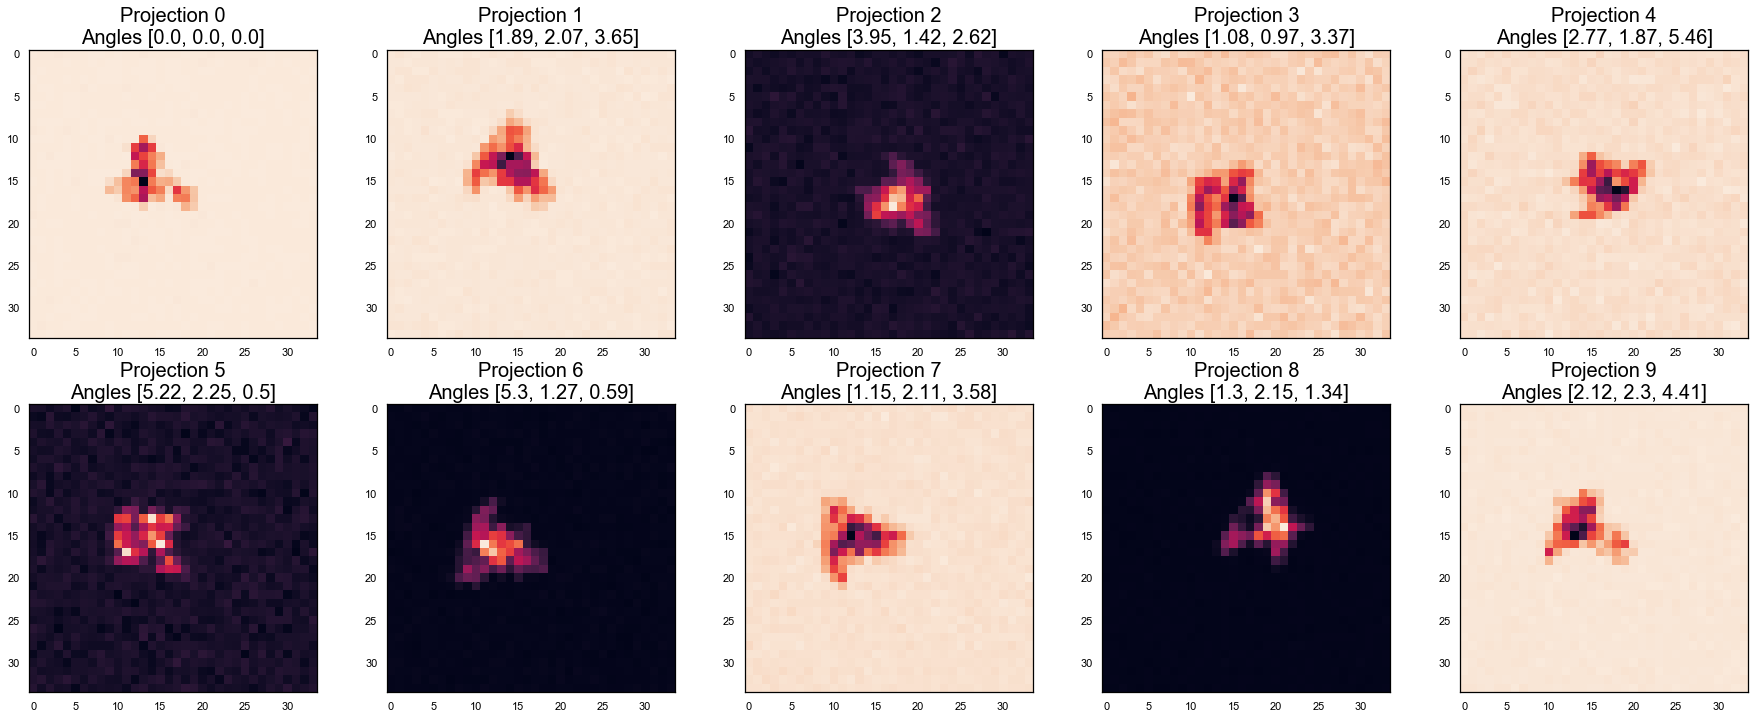

0.16001888


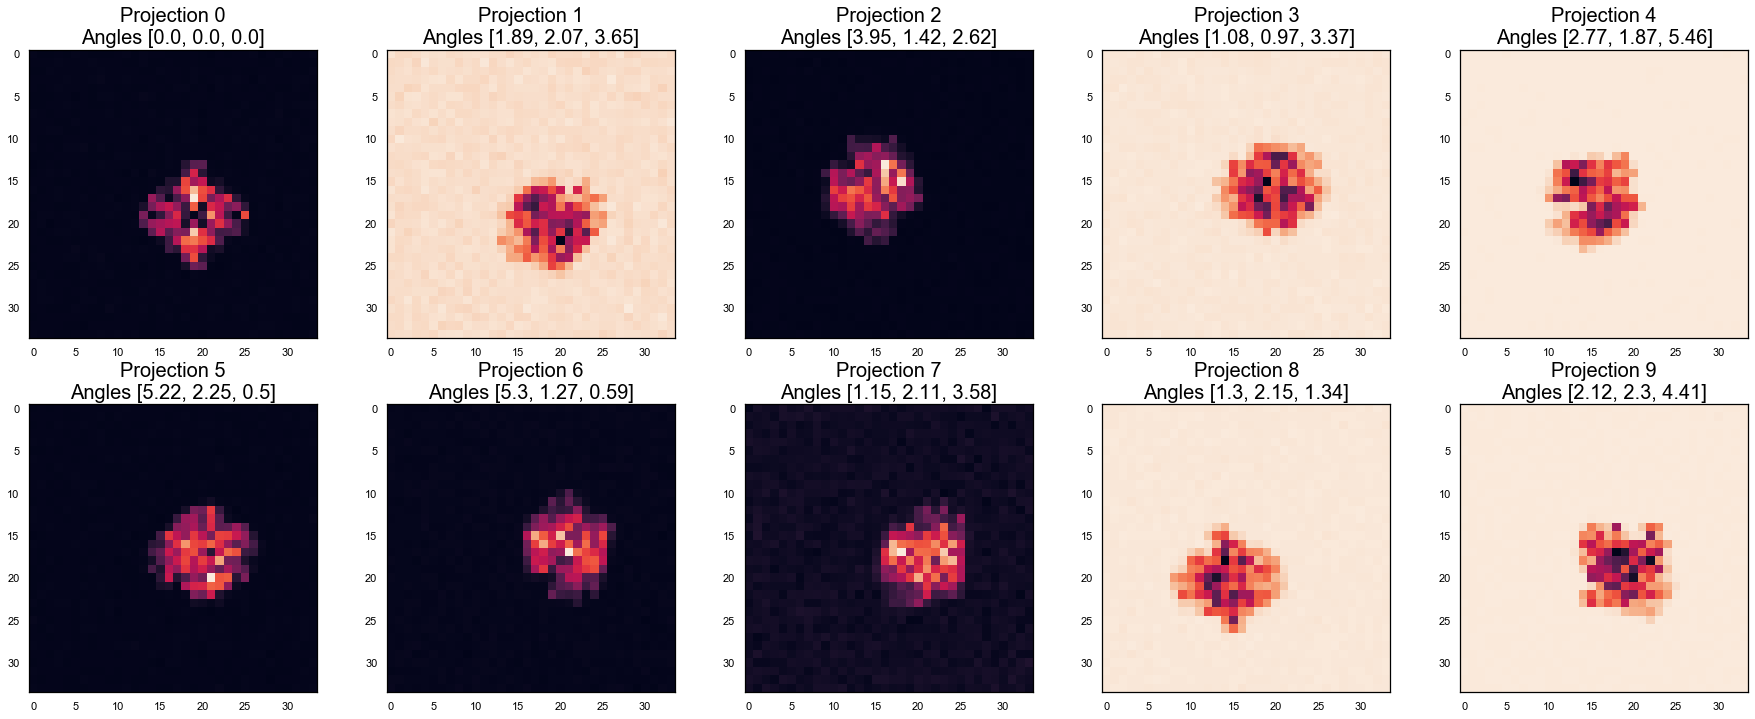

In [34]:
#Make I_j = z_j A_j mu
print(np.mean(Projections1))
True_z1 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_21 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections1 = Projections1 * True_z1

#add noise
for i in range(5000):
    Projections1[i] = Projections1[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_21[i]**(0.5)
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

#Make I_j = z_j A_j mu
print(np.mean(Projections2))
True_z2 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_22 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections2 = Projections2 * True_z2

#add noise
for i in range(5000):
    Projections2[i] = Projections2[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_22[i]**(0.5)
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)



In [35]:
new_projection = Projections2 + Projections1

In [36]:
#Write a recurssive function
#Input Found mu_1, ..., mu_n-1, now_n, n_components, 

class PCA_3d_Recon_recurssive():
    def __init__(self, ProjSize, num_image, n_component, Mus = None):
        
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component

        #if Mus == None:
        ##    #This means that we are at the first iteration
        #    self.Now_n = 1
        #else:
        #We want to find the +1 component
        self.Now_n = Mus.shape[0] + 1
        
        self.Mus = np.zeros((self.Now_n, ProjSize, ProjSize, ProjSize)) + 0.00001
        self.Mus[: self.Now_n -1  , :, :, :] = Mus #Record the previous conponents
        self.sigma = np.ones(self.num_image) * 0.1


        self.ro = np.abs(np.ones((num_image, self.Now_n)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.Now_n, self.Now_n )))

        self.Aus = np.zeros(( num_image, ProjSize* ProjSize,  self.Now_n))

    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Q_(Imgages, Angles)
        self.Plot_mu_by_projection(Angles)
        for i in range(160):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            self.Q_(Imgages, Angles)
            if i % 10 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
                self.Q_(Imgages, Angles)
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        for n in range(self.Now_n):
            Projections = generate_projections_ASTRA(self.Mus[n] , Angles, self.ProjSize, BatchSizeAstra = "None")
            #print(Projections.shape)
            #check_image = Projections[0].reshape(-1, 1, order = 'F')
            self.Aus[:, :, n] =  Projections.reshape(Projections.shape[0], -1 , order = 'F') #with fortrain - like order
            #print('check_Aus', check_image)
   
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        #self.Au_s(Angles)
        #ro = [] #For n image, we have n z.
        ro = np.zeros((self.num_image, self.Now_n ))
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            #ro.append(roj.tolist())
            ro[j] = roj.reshape(-1)
        #self.ro = np.array(ro).reshape(-1, self.Now_n) #Check@@@@@@@@@@
        self.ro = ro
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.Now_n, self.Now_n ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.Now_n) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.Now_n , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])

    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.Now_n):
                right_term += right_term + self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]
                #print((self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]).shape)
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.Now_n-1]
            #print('left_term', np.mean(left_term))
            #print(' self.ro[j][self.Now_n-1]' , self.ro[j][self.Now_n-1])
            temp = left_term - right_term.reshape(-1,1 , order = 'F')
            #print('left, right', np.mean(left_term), np.mean(right_term) )
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print('DeltaMu', np.mean(DeltaMu))
        #Before returning this ,since we should make the grident direction orthogonal to the previous directions, we should make
        #it orthogonal to the spam of mus
        PDeltaMu = DeltaMu.reshape(-1,1, order ='F')
        
        OriDeltaMu =  DeltaMu.reshape(-1,1, order ='F')
        Vec_Mus = self.Mus.reshape(self.Now_n, -1, 1, order = 'F')
        for i in range(self.Now_n -1):
            #print('Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu',(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu).shape)
            #print((Vec_Mus[i]*(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu)).shape)
            #print(PDeltaMu.shape)
            PDeltaMu = PDeltaMu - Vec_Mus[i]*(Vec_Mus[i].T @ OriDeltaMu / (np.linalg.norm(Vec_Mus[i]) **2))
        
        
        #print('check projected direction orthogonal mu[0]', np.sum(Vec_Mus[0] *PDeltaMu ))
        return PDeltaMu.reshape(self.ProjSize, self.ProjSize, self.ProjSize , order ='F')

    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(np.abs(self.Mus[self.Now_n -1])))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.Mus[self.Now_n -1] ) / np.mean(DeltaMu) )*0.001
            #print('lr', lr)
            self.Mus[self.Now_n -1] = self.Mus[self.Now_n -1] + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
            
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] @ self.ro[j].reshape(self.Now_n , 1)
            
            #right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            right = 0
            for x in range(self.Now_n):
                for y in range(self.Now_n):
                   right = right + self.Aus[j][: , x].T @ self.Aus[j][: , y] * self.BigSigma[j][x][y]
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        for n in range(self.Now_n):
            curremt_mu = self.Mus[n].reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
            CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
            pids = range(10)
            plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)

    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Aus[j][: ,self.Now_n - 1].reshape(-1, 1, order = 'F') * self.ro[j][self.Now_n - 1]

            #Aju =  self.Aus[j]
            #right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            right = 0
            for i in range(self.Now_n -1):
                right = right + self.Aus[j][:, i].T @ self.Aus[j][:, i] * self.BigSigma[j][i][self.Now_n - 1]
            right = right + 1/2 *  self.Aus[j][:, self.Now_n - 1].T @ self.Aus[j][:, self.Now_n - 1] * self.BigSigma[j][self.Now_n -1][self.Now_n -1]

            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass



class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.zeros((ProjSize, ProjSize, ProjSize)) + 0.01
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.ones((num_image, n_component)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))

        self.Aus = np.zeros((n_component, num_image, ProjSize* ProjSize, 1))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Plot_mu_by_projection(Angles)
        for i in range(160):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            #self.Q_(Imgages, Angles)
            if i % 10 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
              
        
    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(self.mu))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
            self.mu = self.mu + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
        self.Au_s(Angles)
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] * self.ro[j][self.n_component-1]
            
            right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            #for x in range(self.n_component):
            #    for y in range(self.n_component):
                    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
   
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


input noised image 


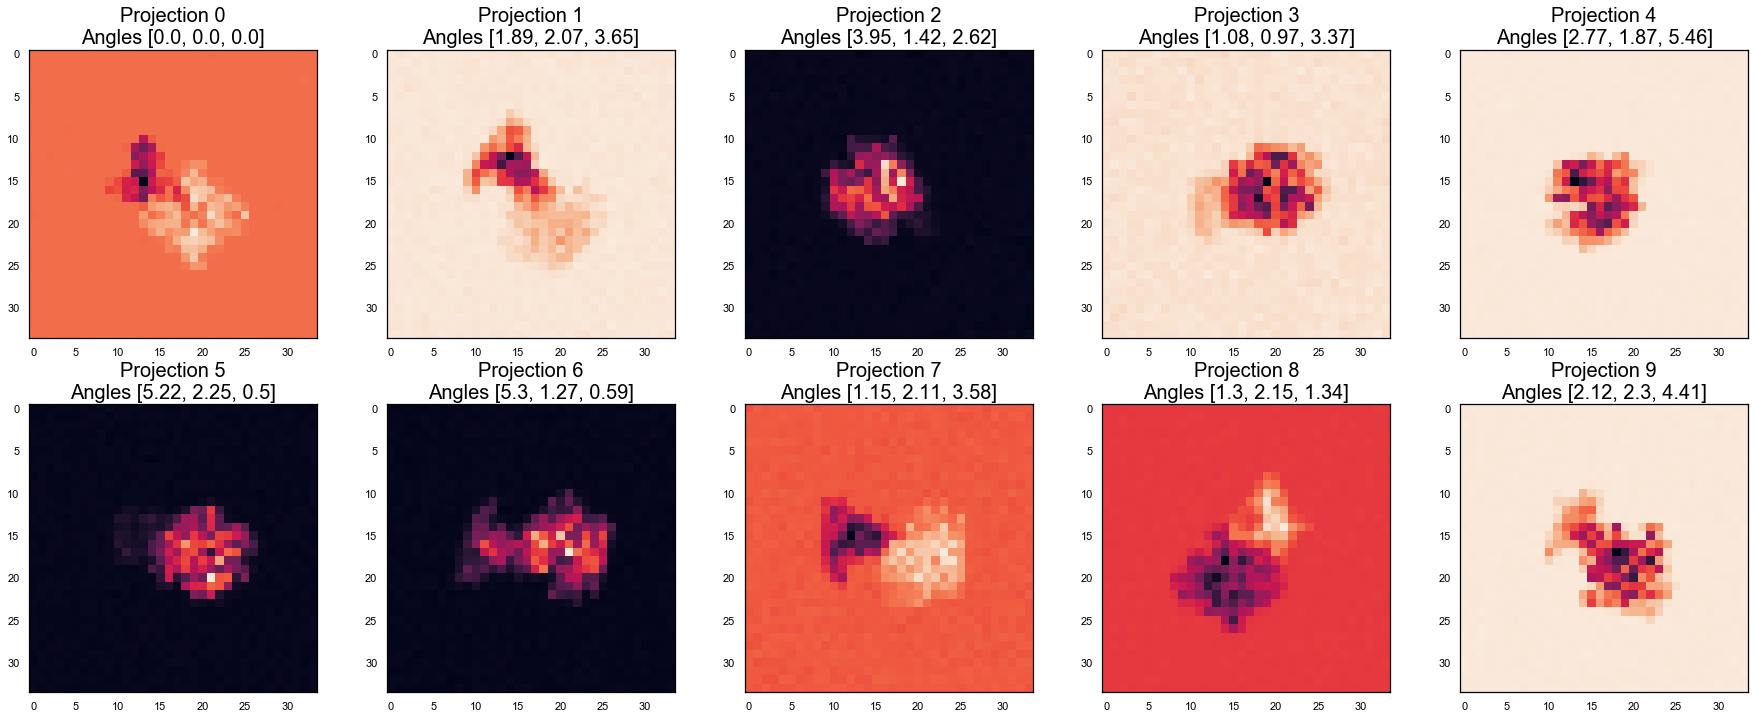

start fitting
The 0-th iteration


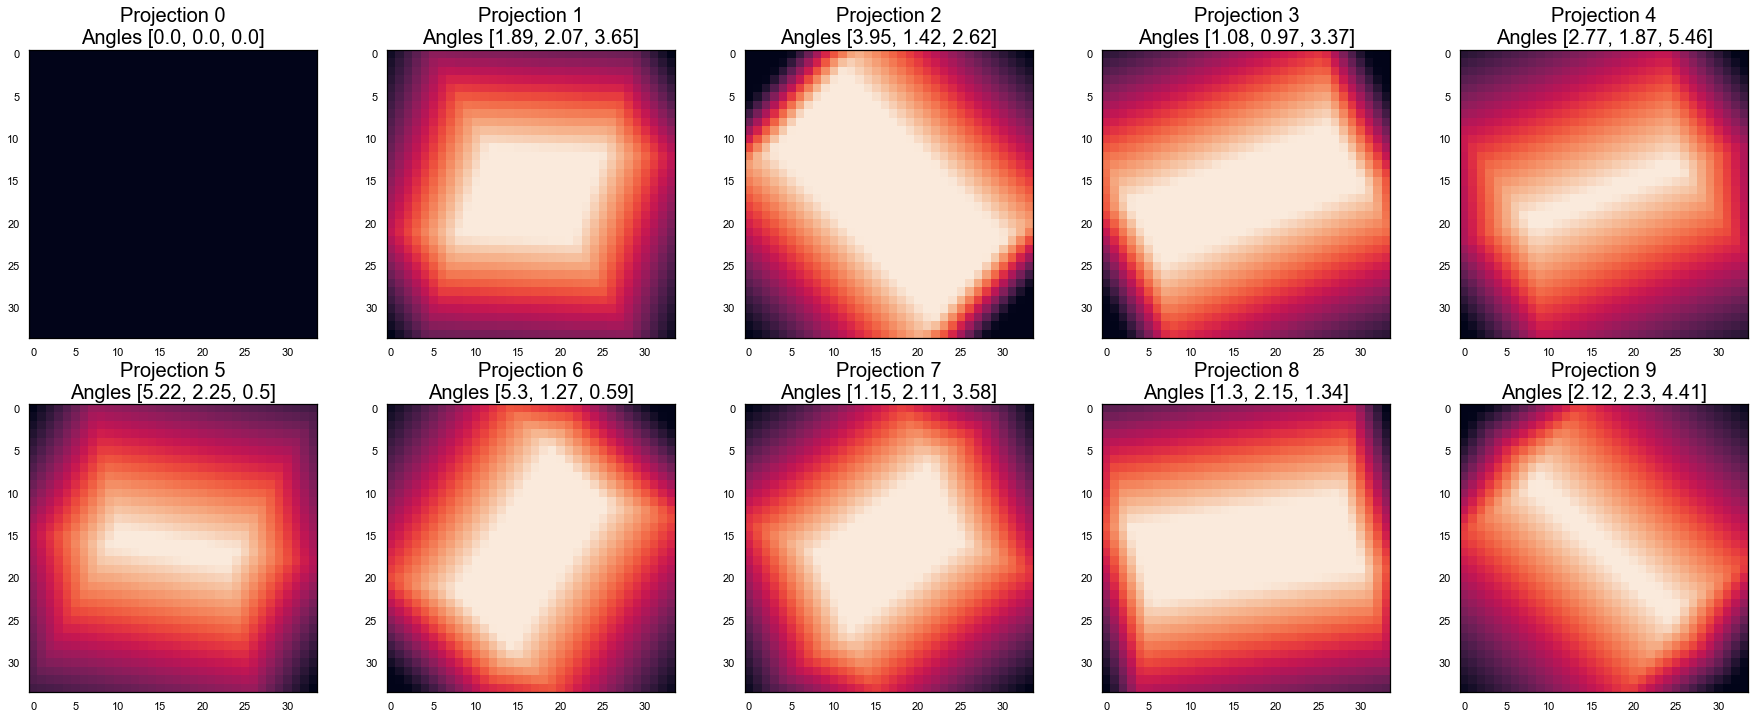

The 1-th iteration


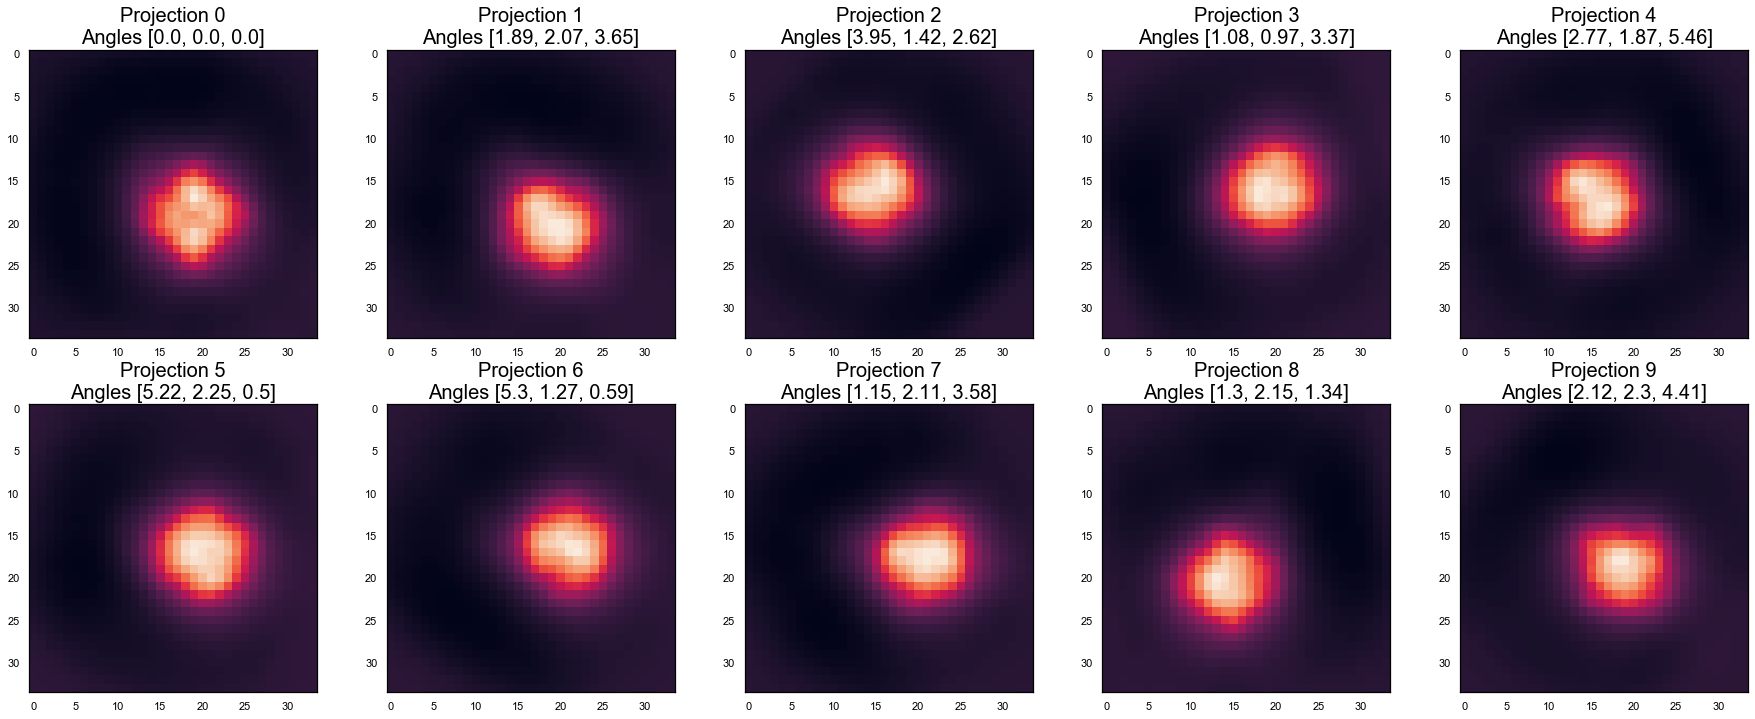

The 11-th iteration


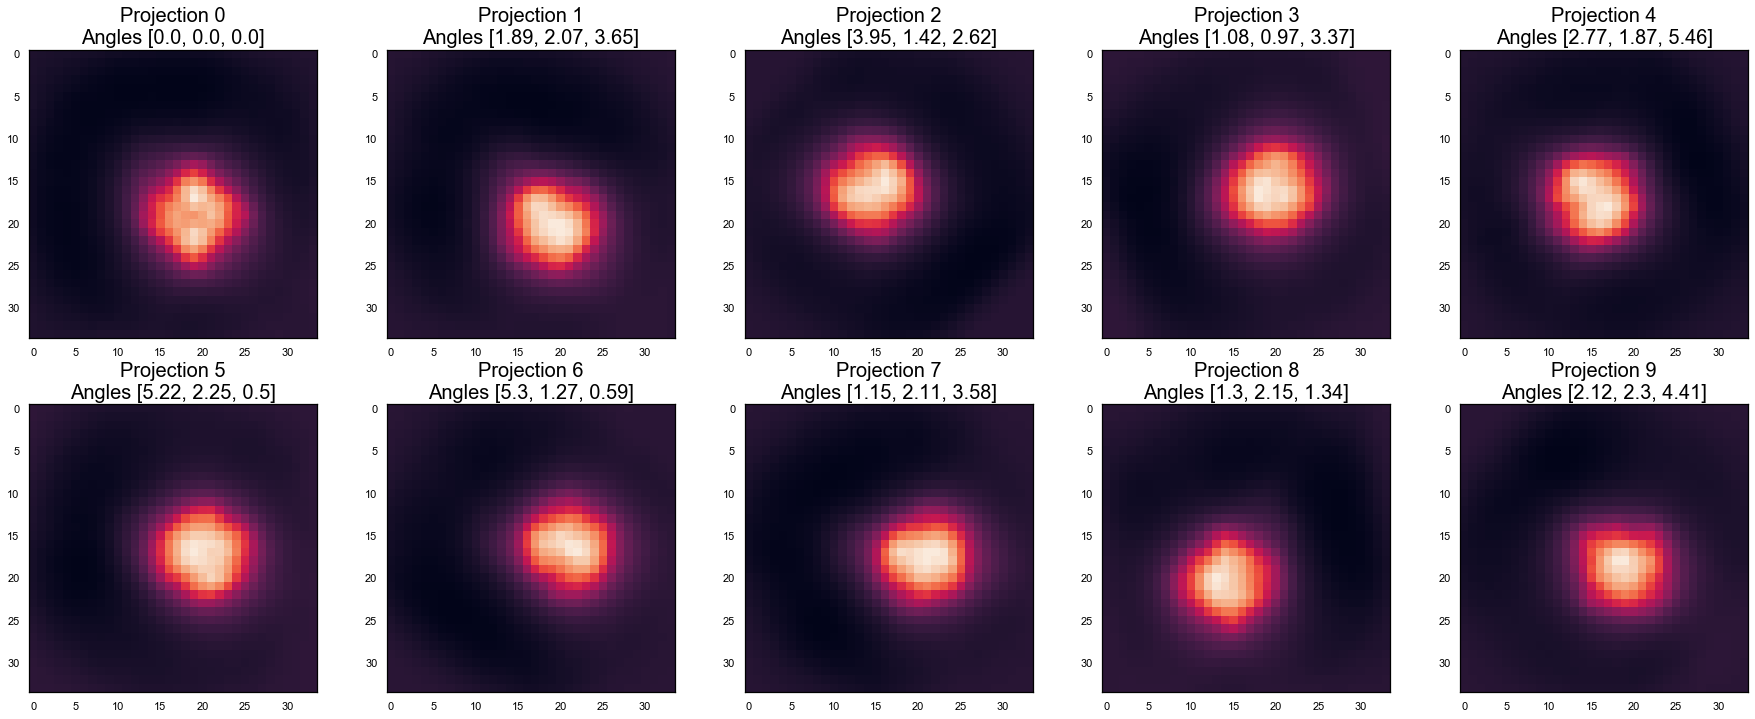

The 21-th iteration


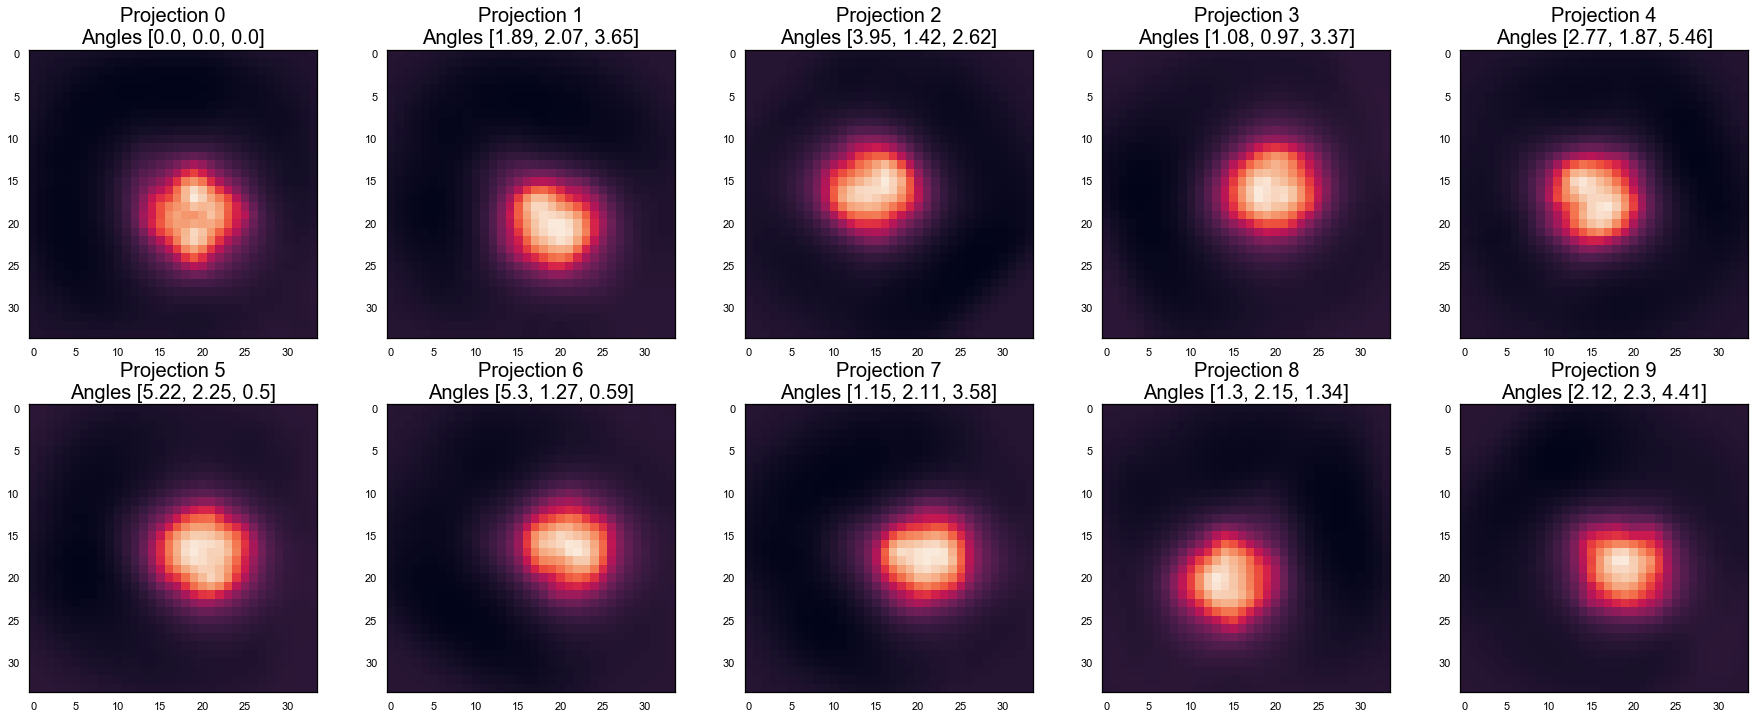

The 31-th iteration


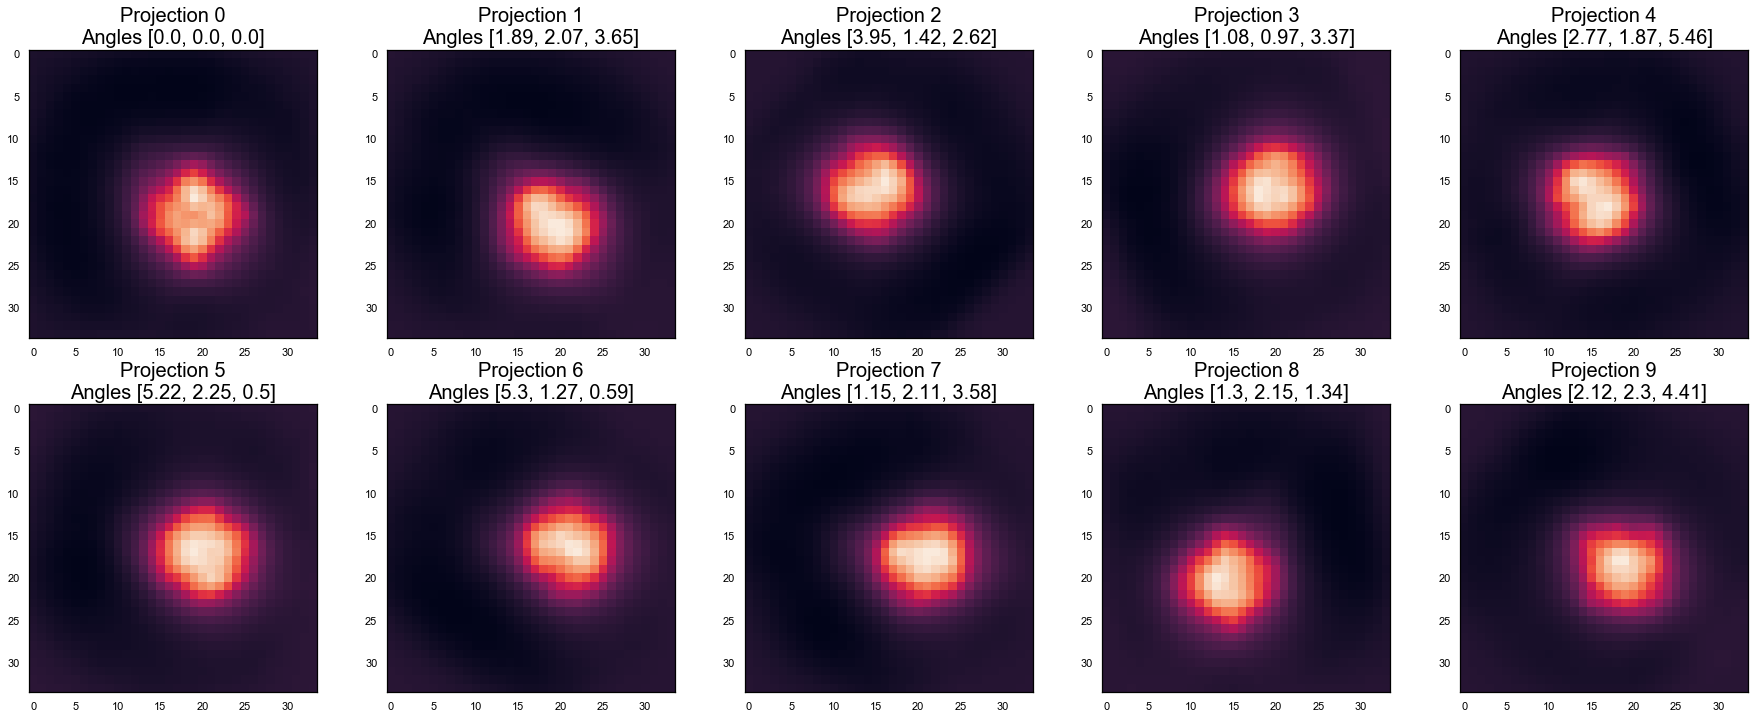

The 41-th iteration


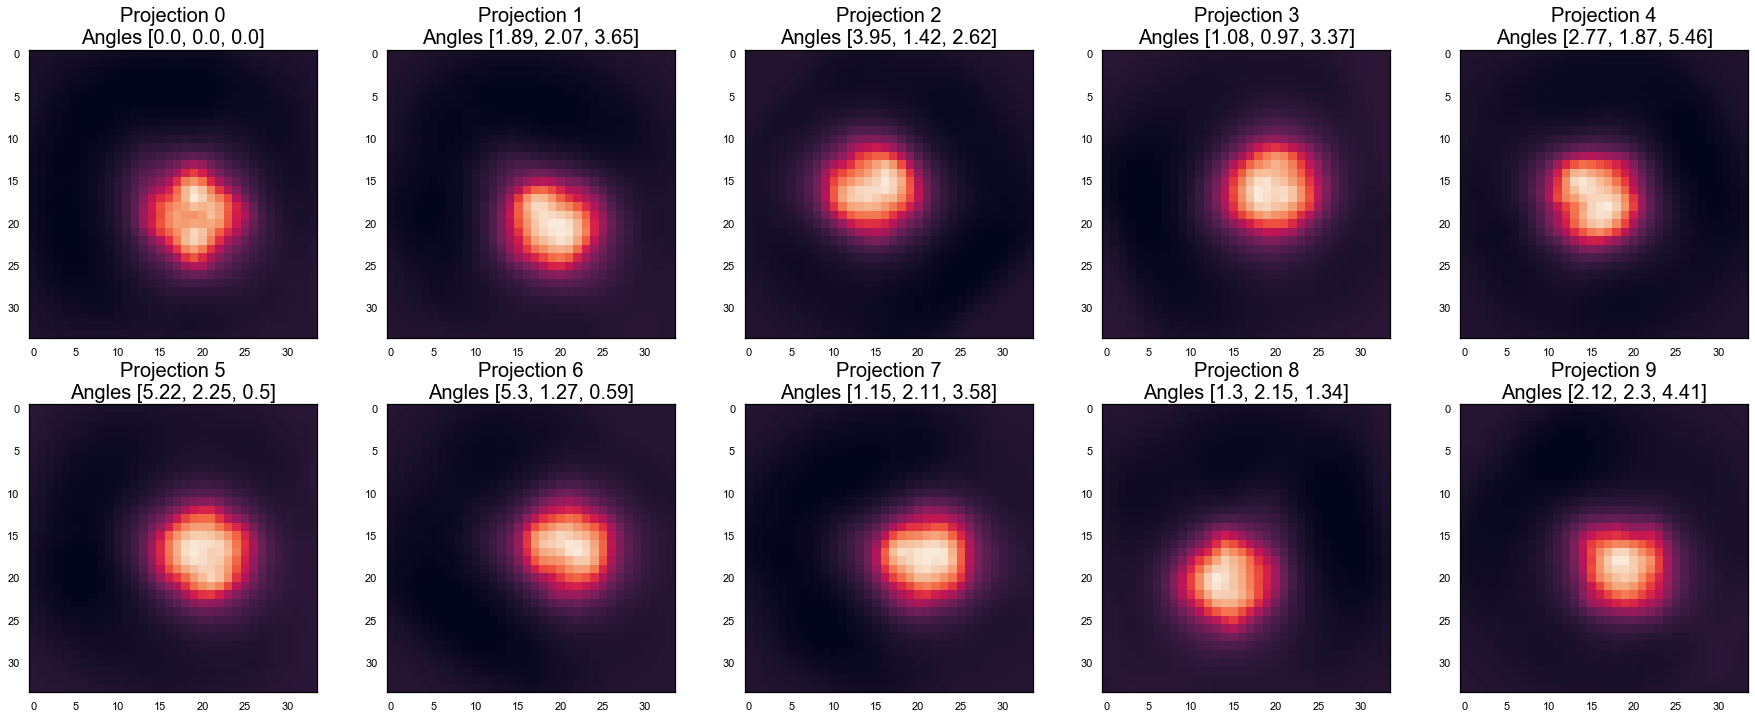

The 51-th iteration


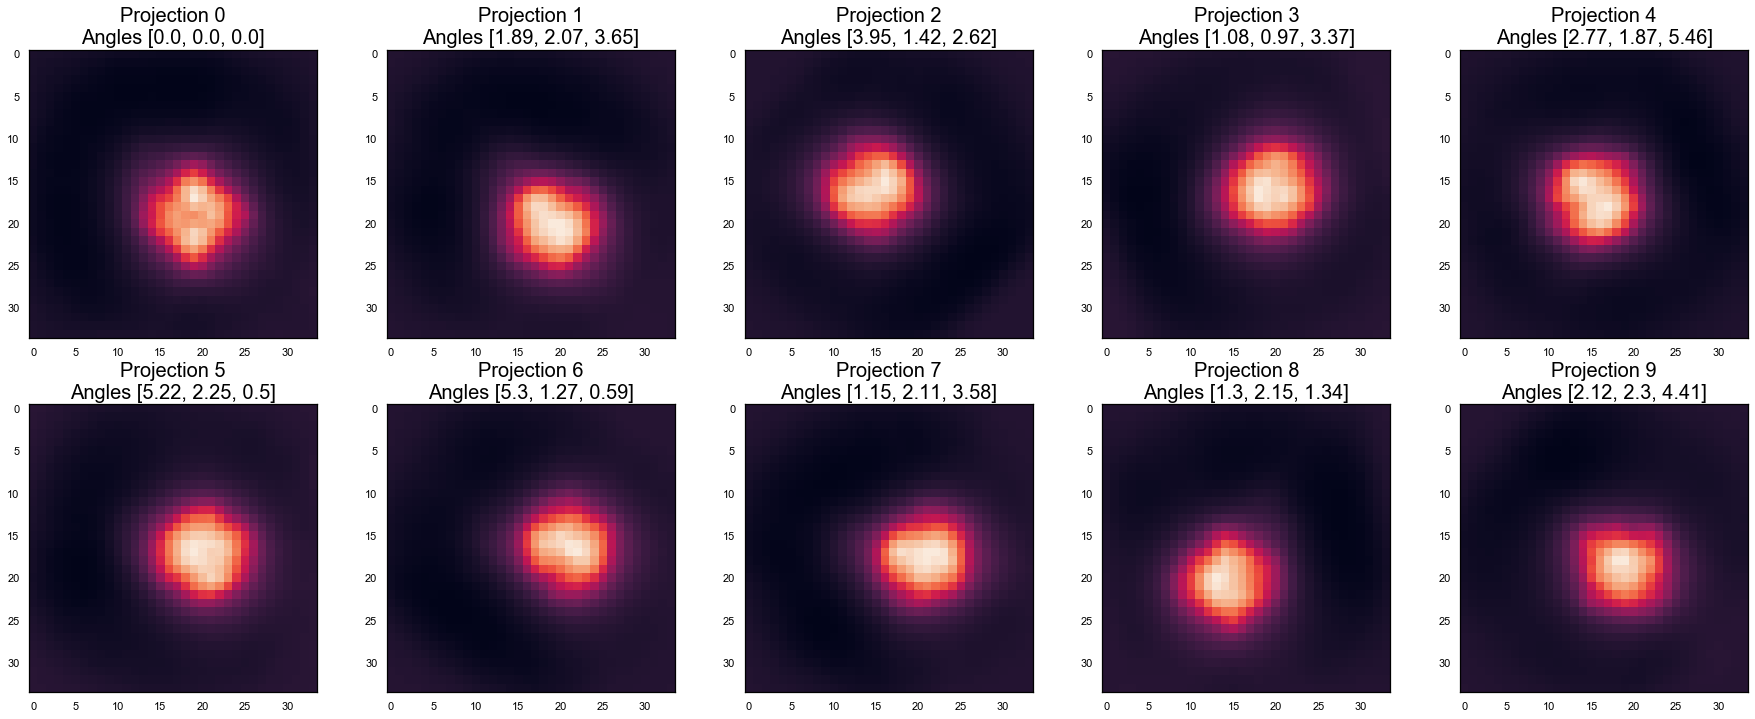

The 61-th iteration


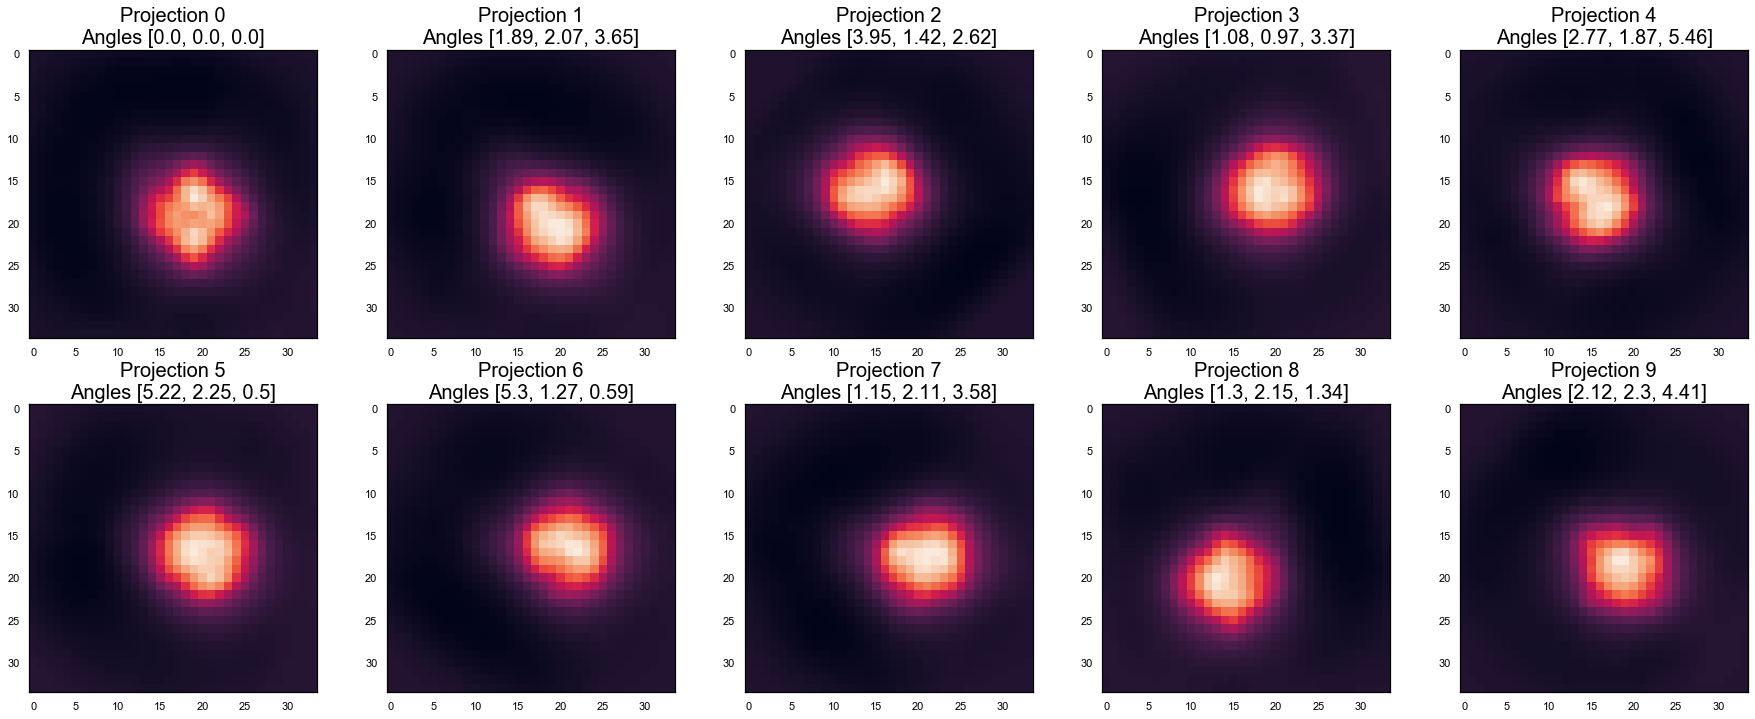

The 71-th iteration


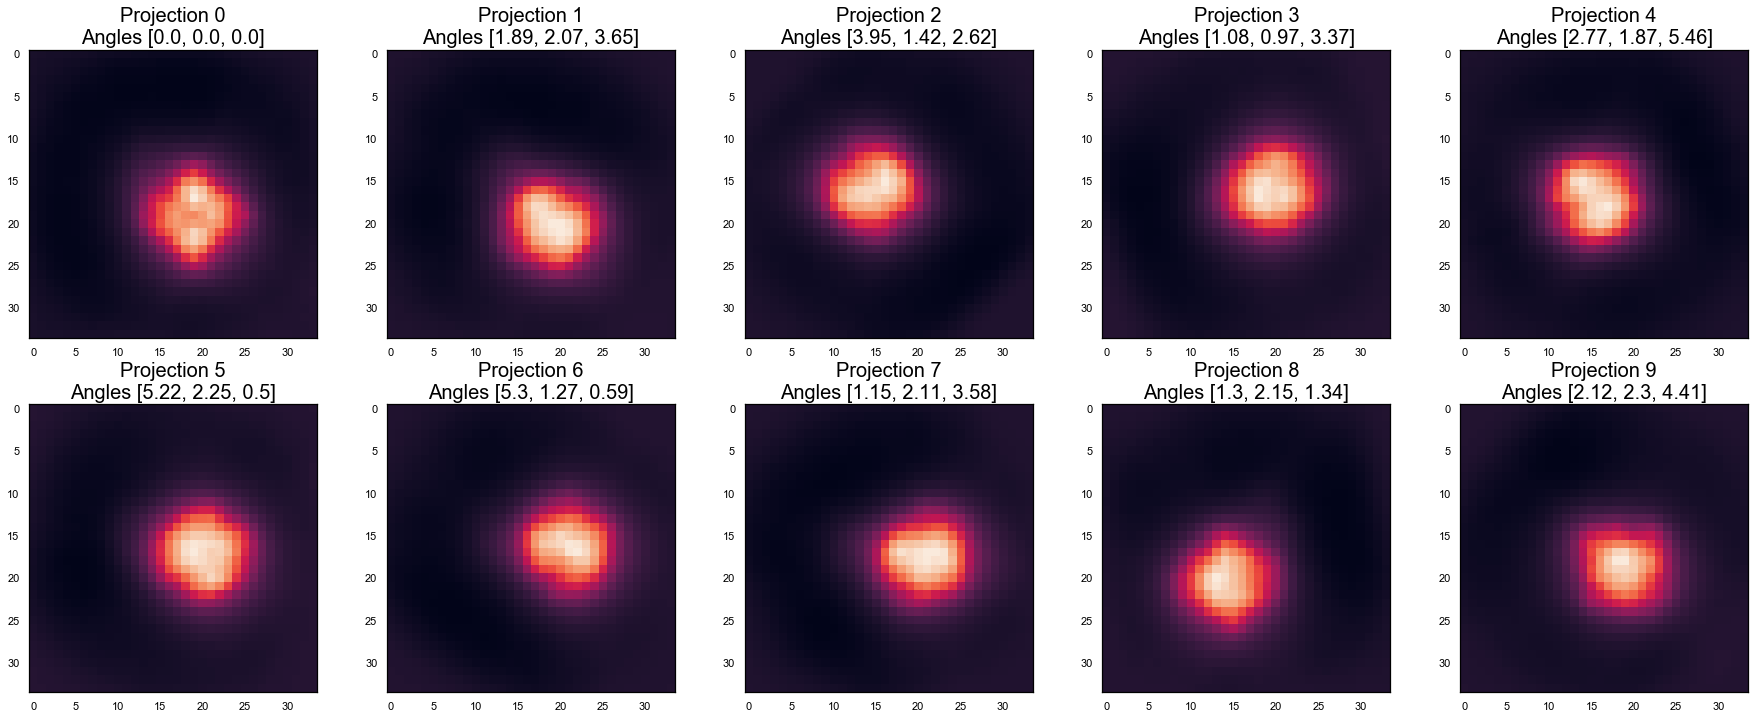

The 81-th iteration


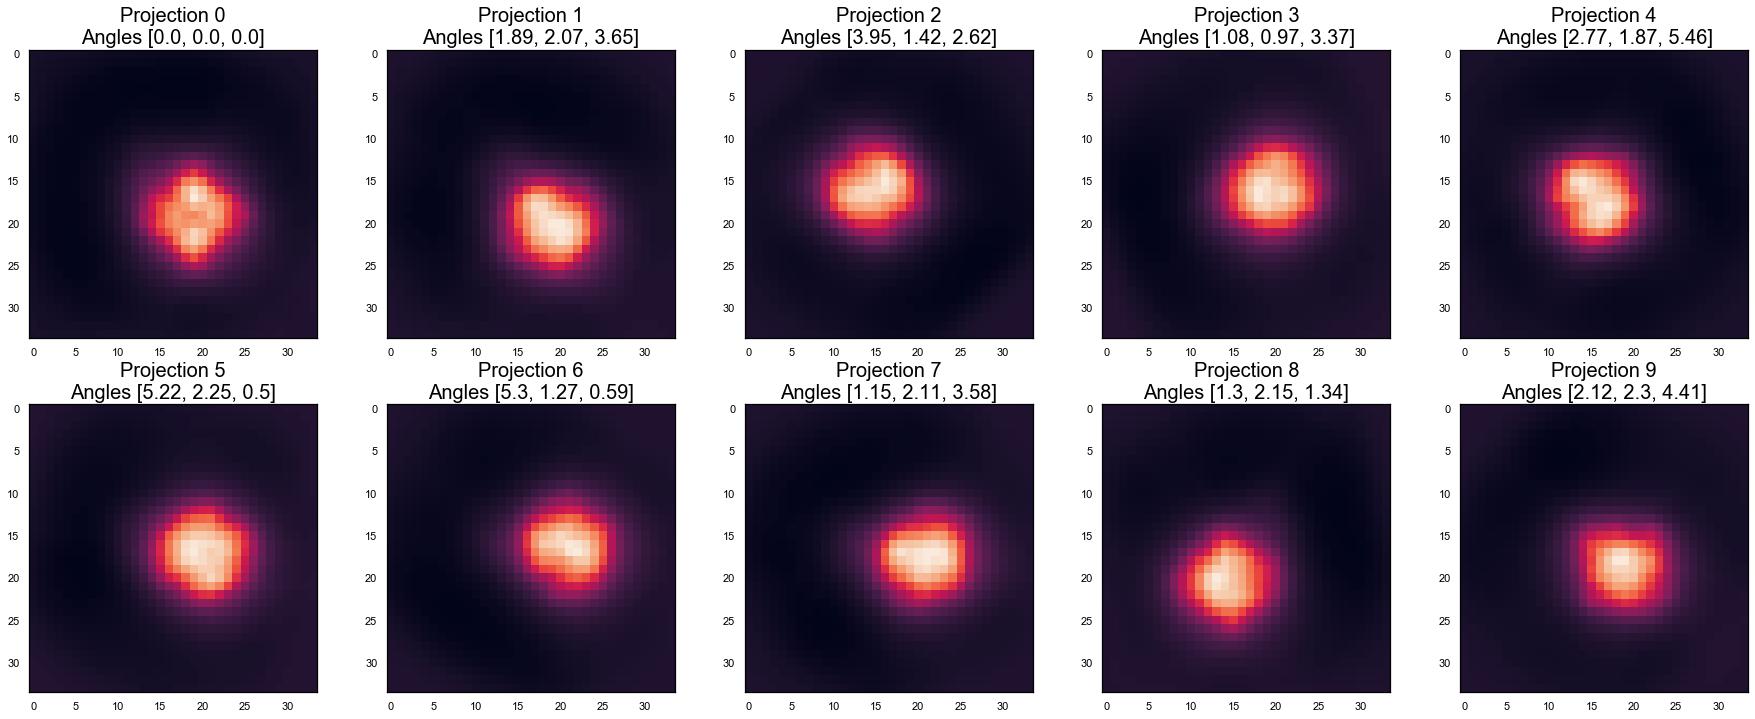

The 91-th iteration


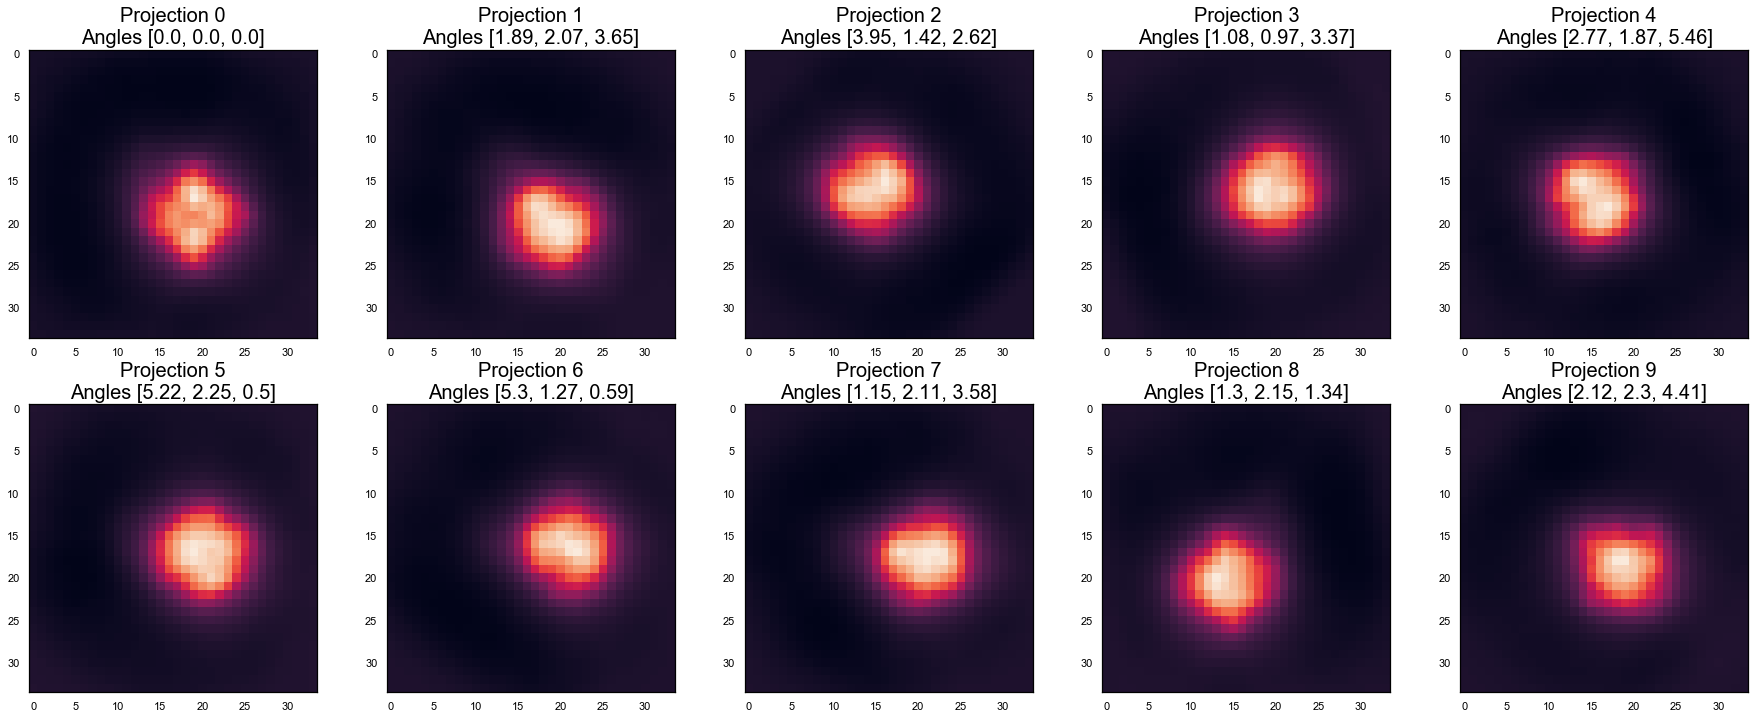

The 101-th iteration


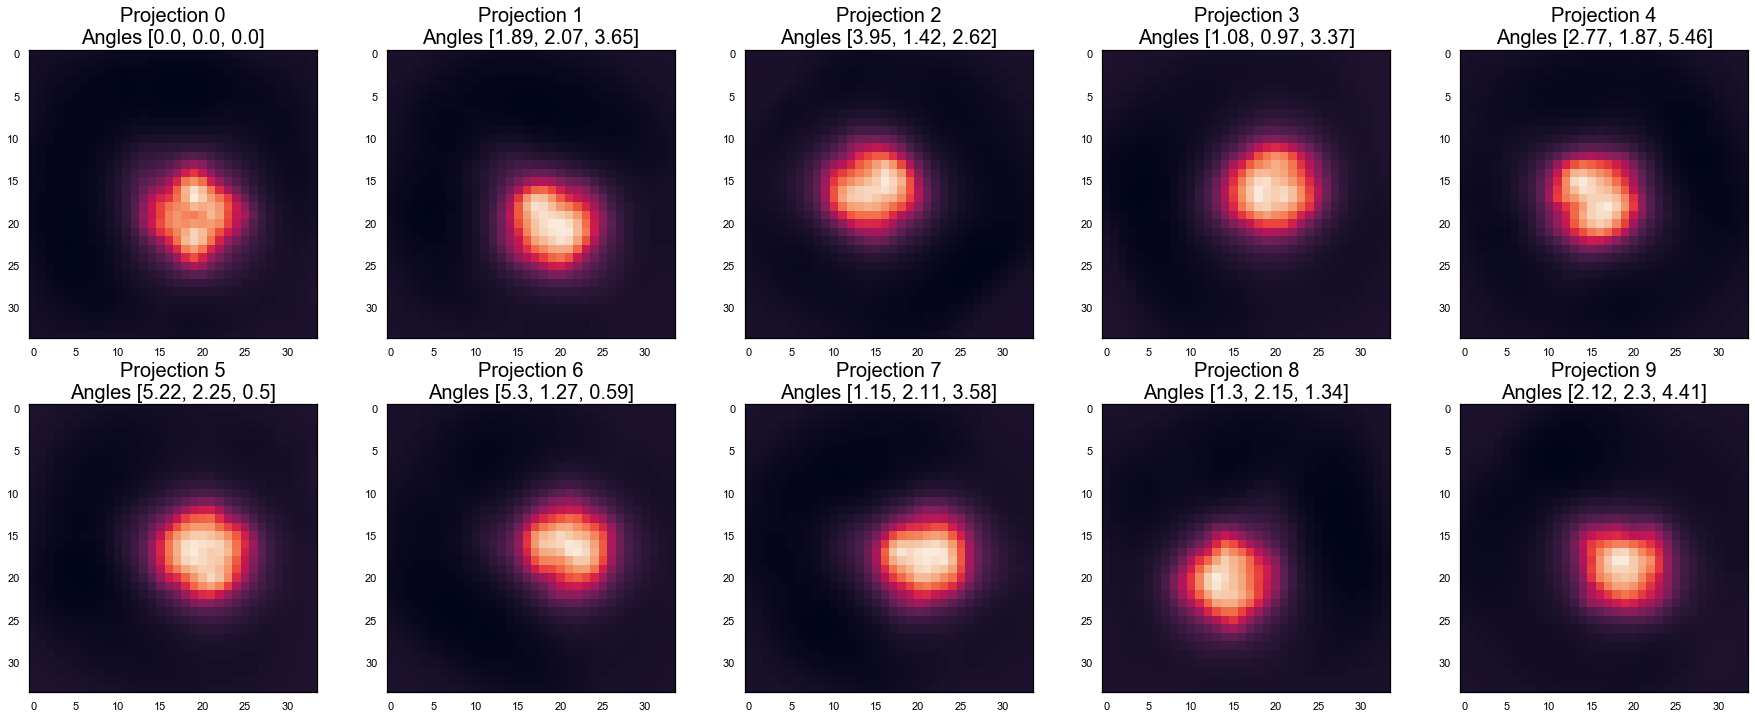

The 111-th iteration


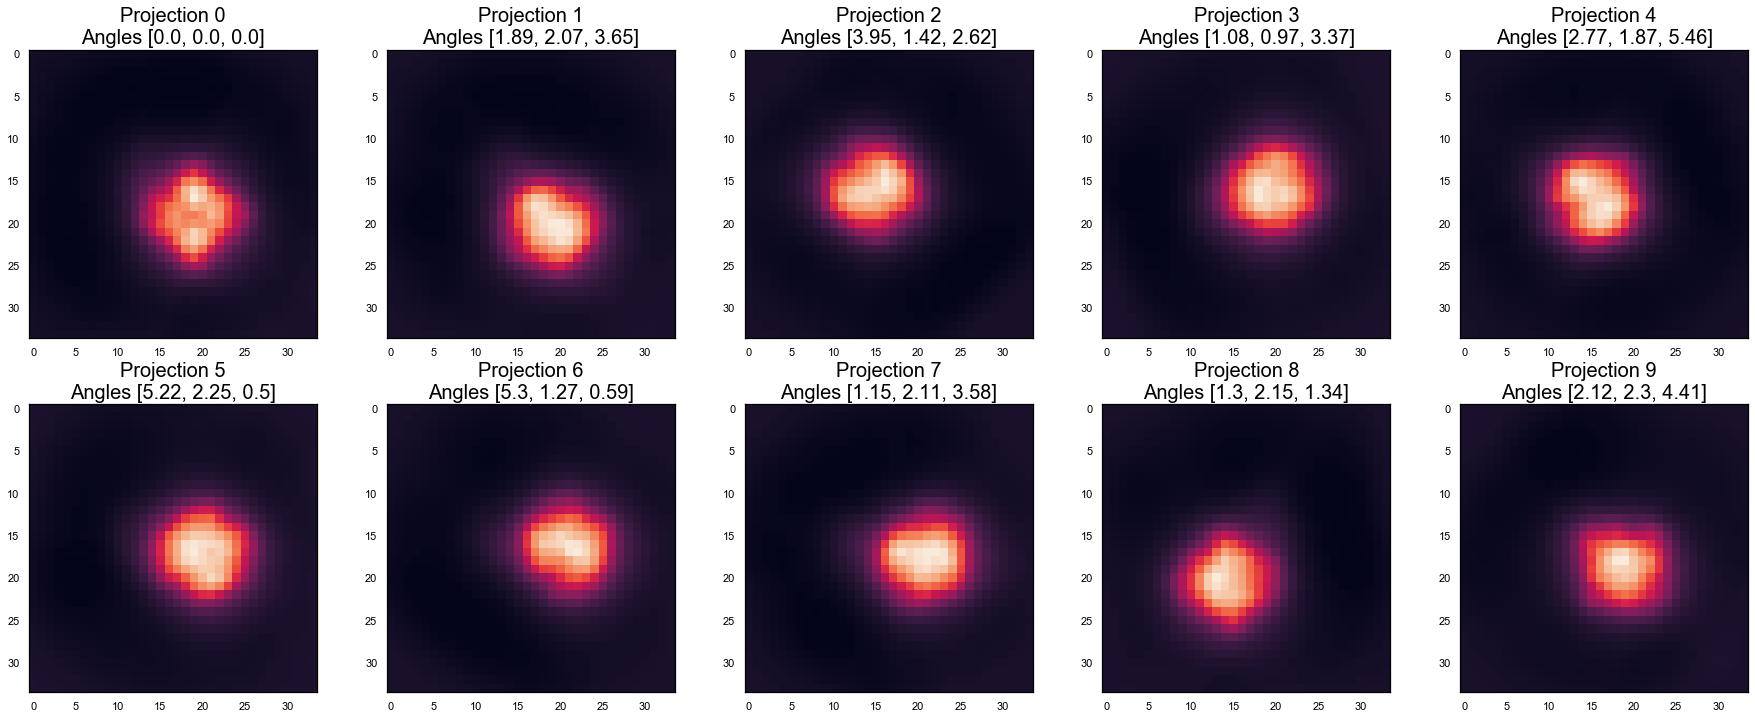

The 121-th iteration


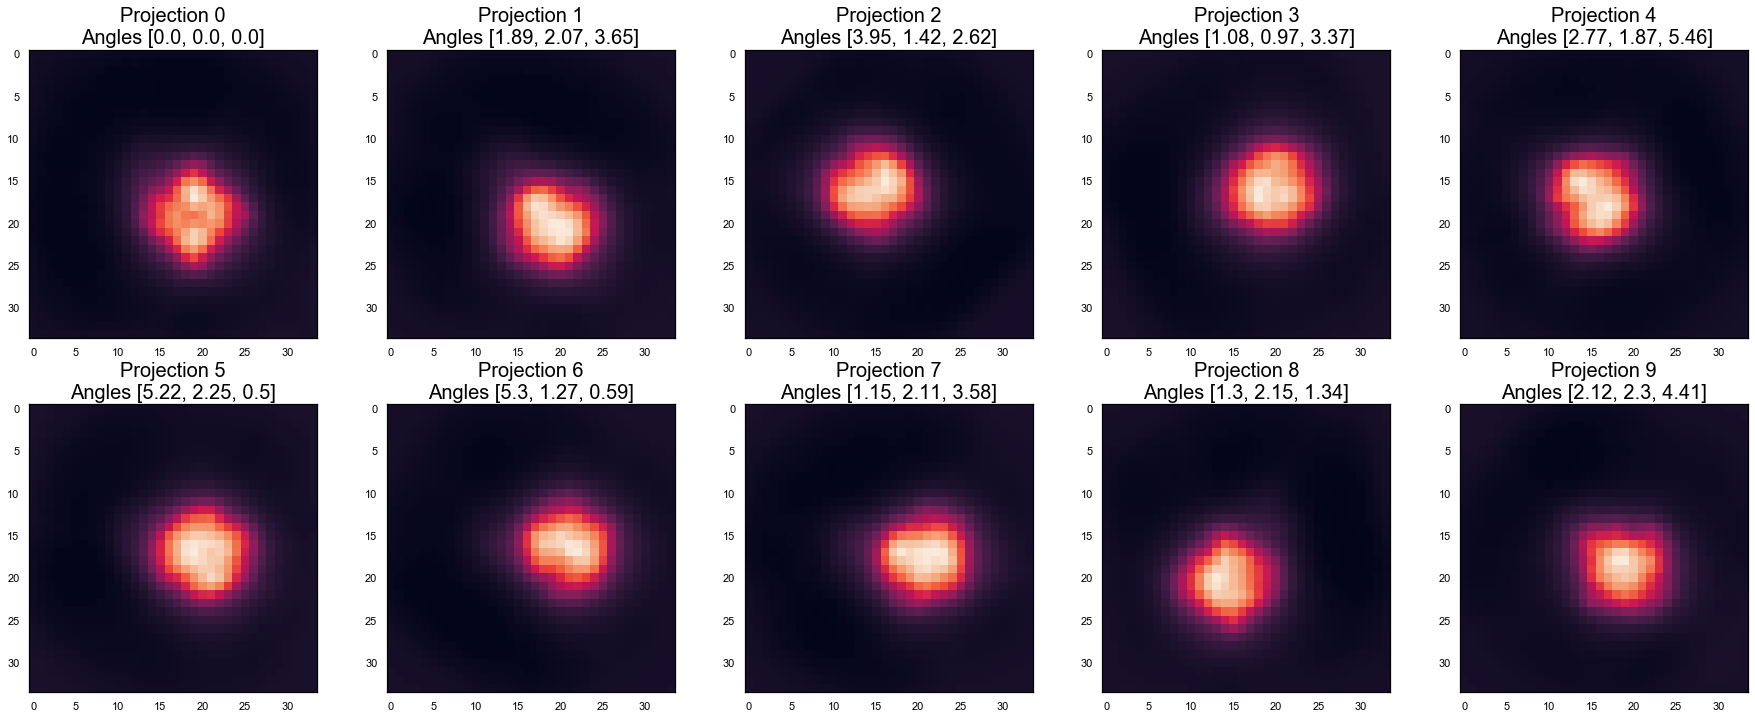

The 131-th iteration


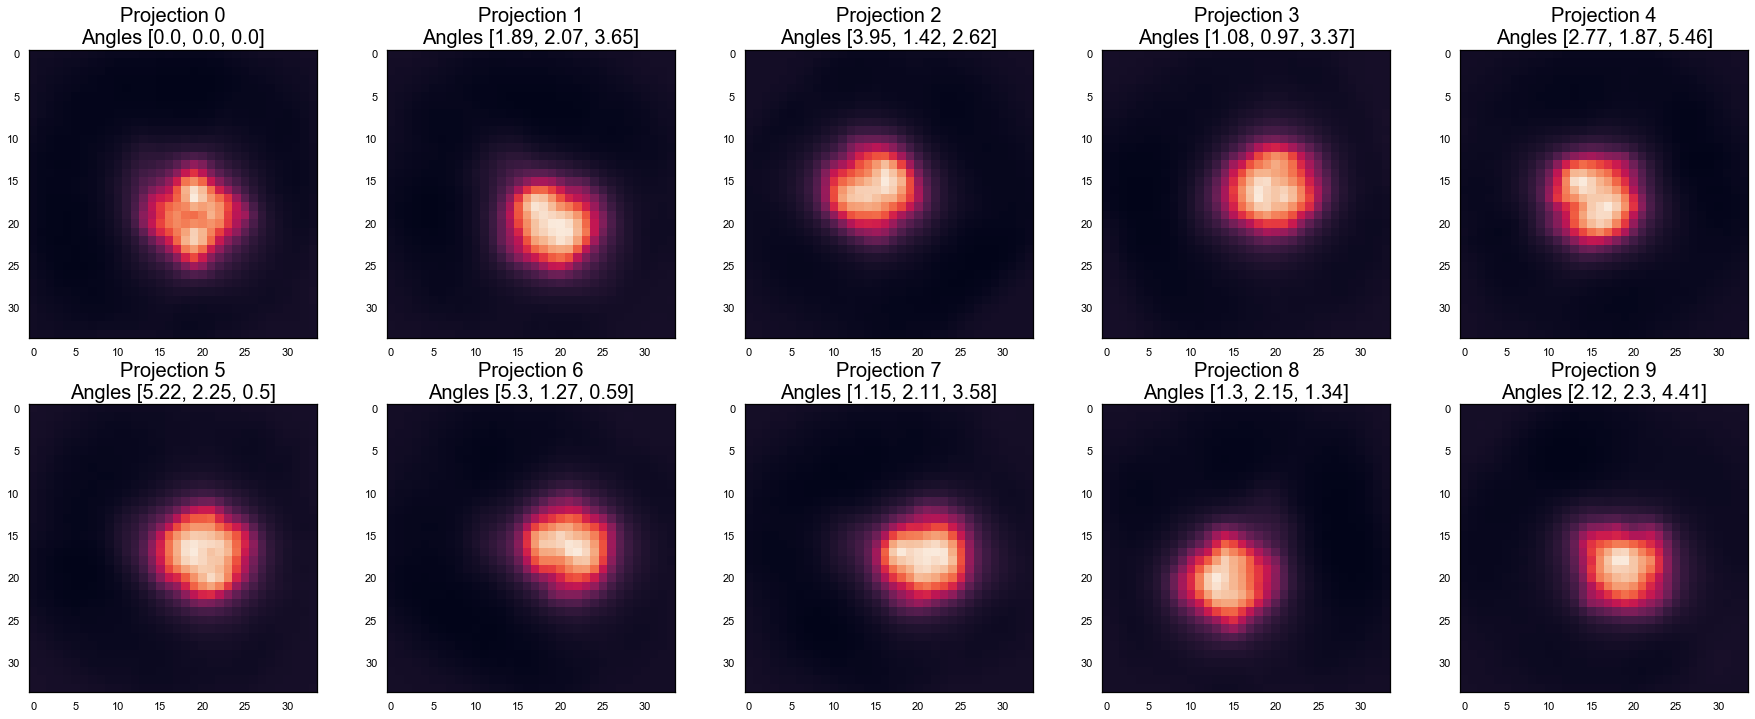

The 141-th iteration


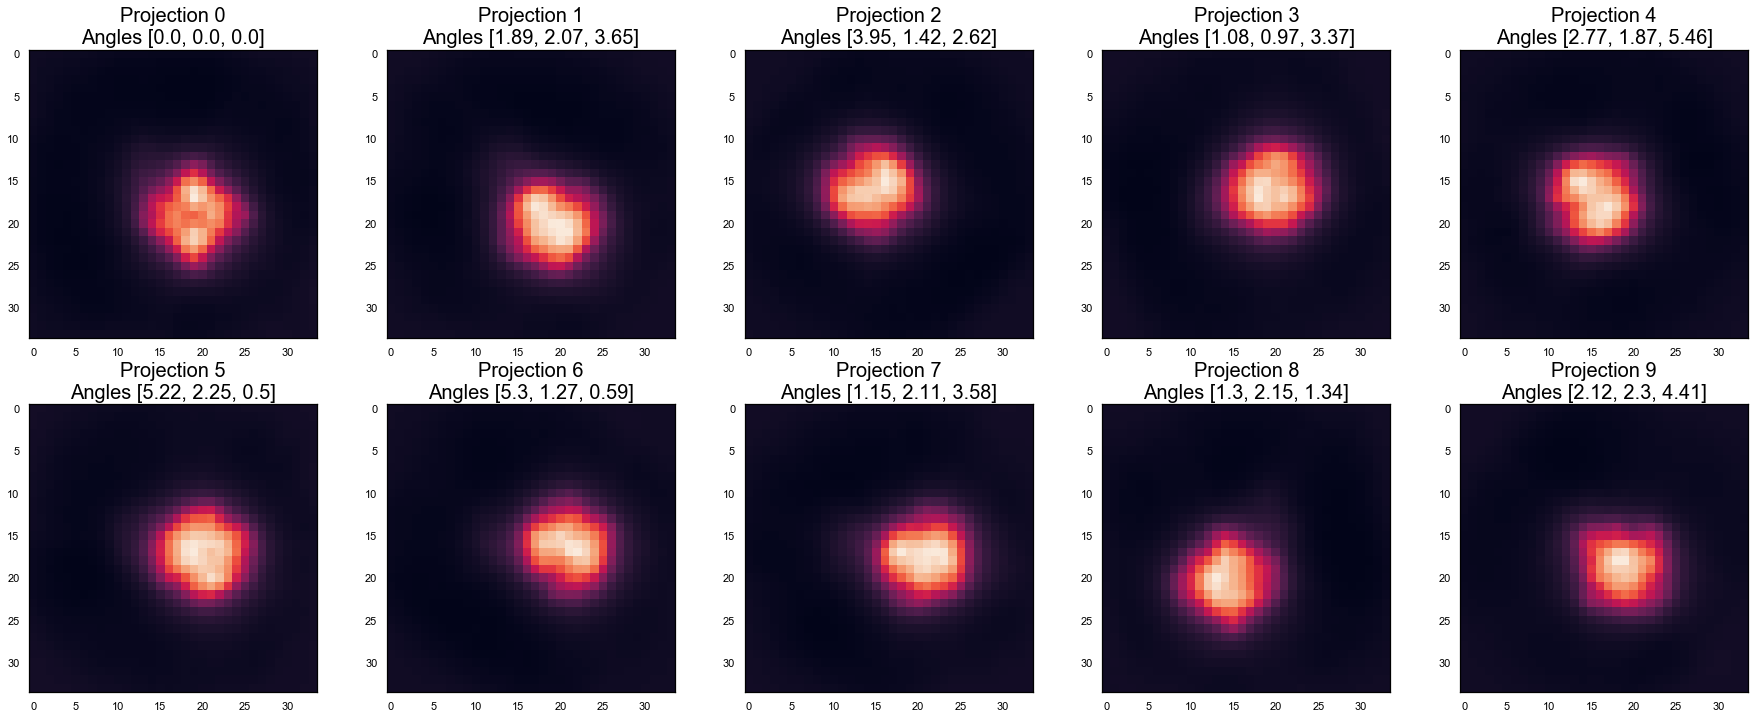

The 151-th iteration


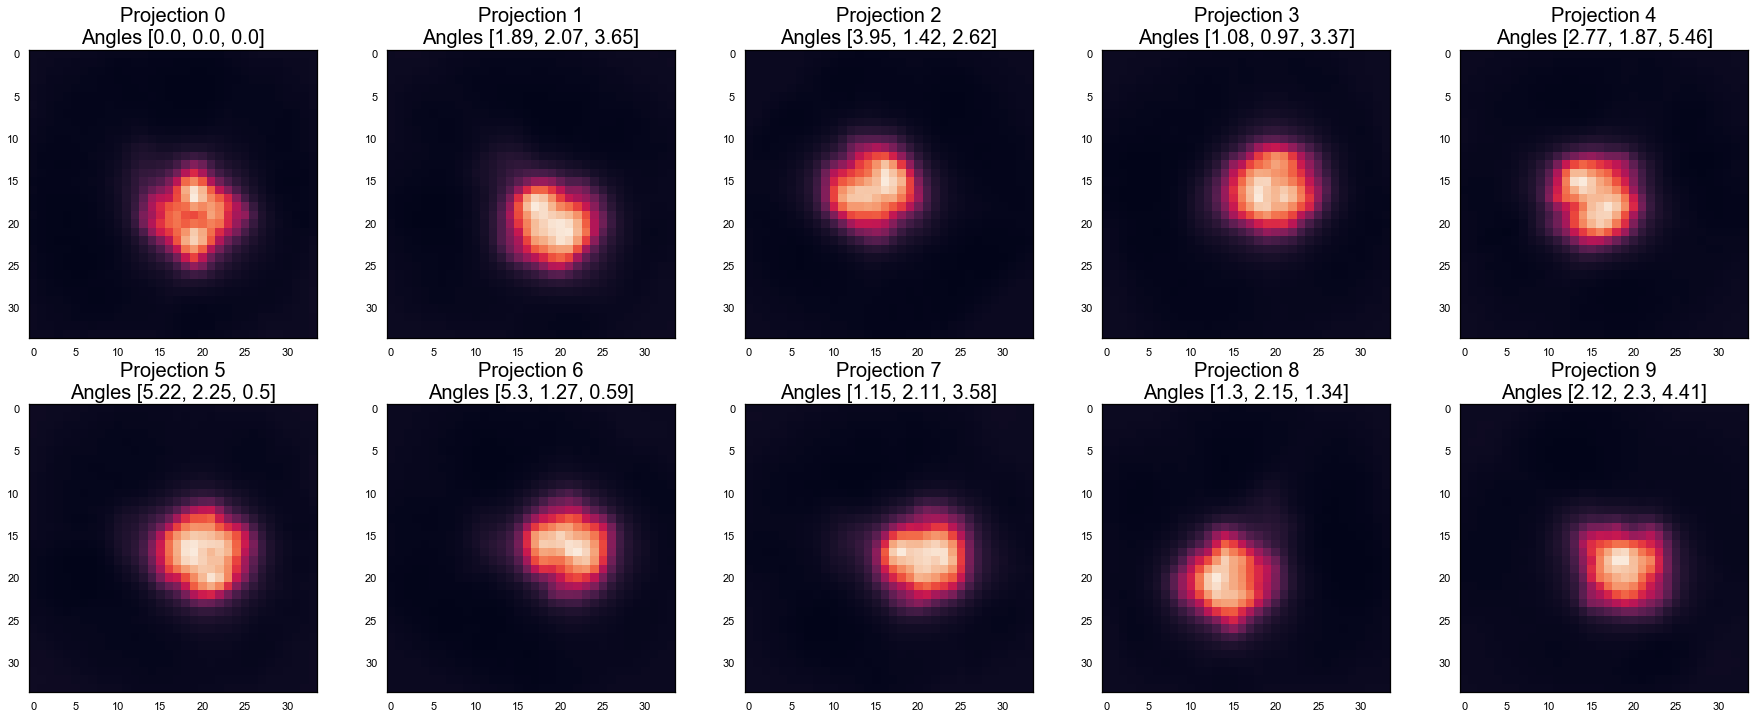

In [37]:



_, num_image , n_component = 116, 5000 , 1
angles2 = angles2[:num_image]
new_projection = new_projection[:num_image]
print('input noised image ')
plot_projections(new_projection[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

P3R = PCA_3d_Recon(ProjSize1, num_image, n_component)
P3R.Au_s(angles2)

P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)

start fitting
The 0-th iteration


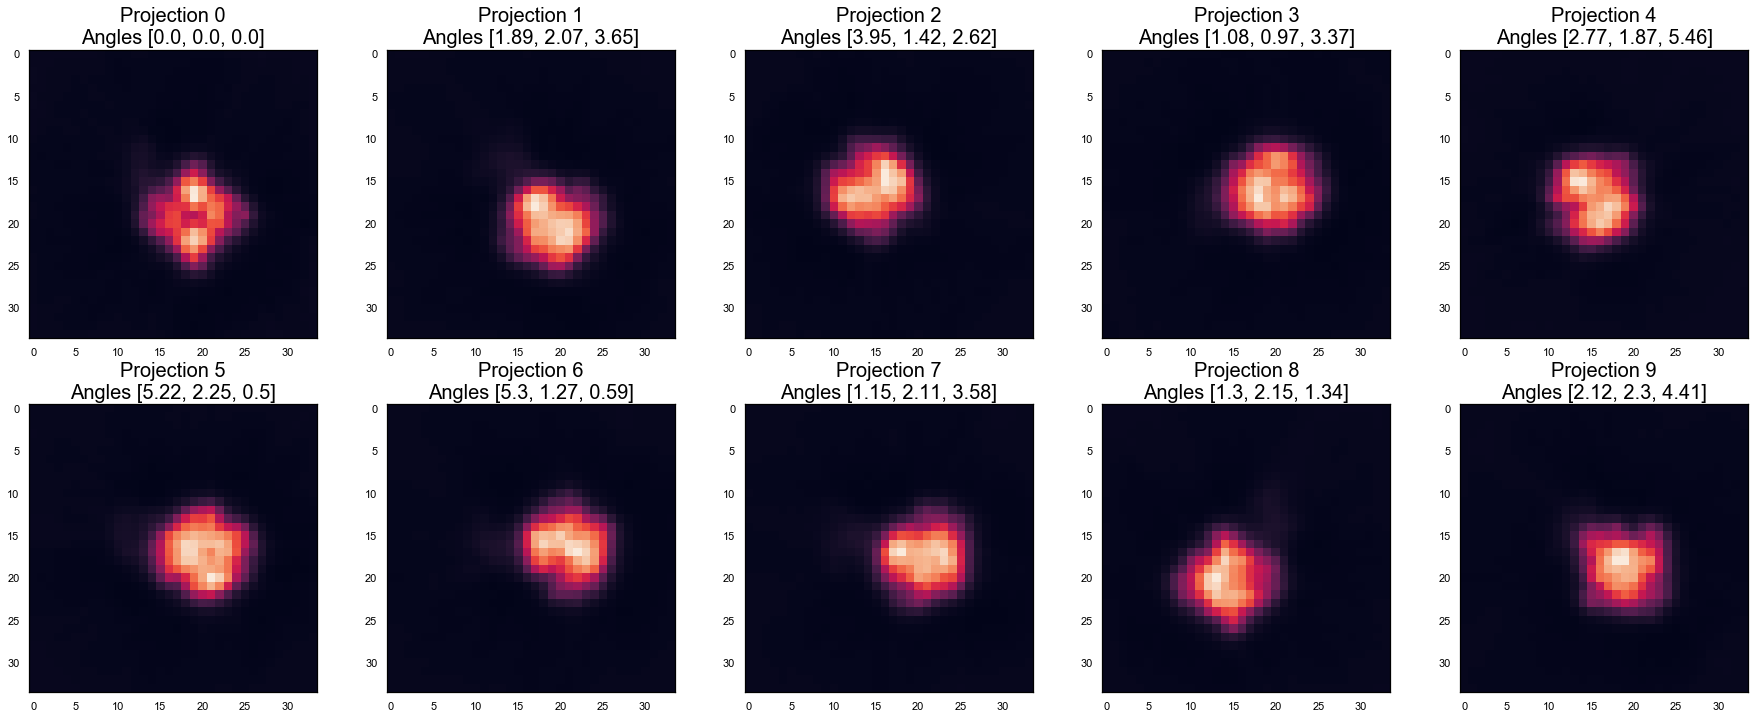

The 1-th iteration


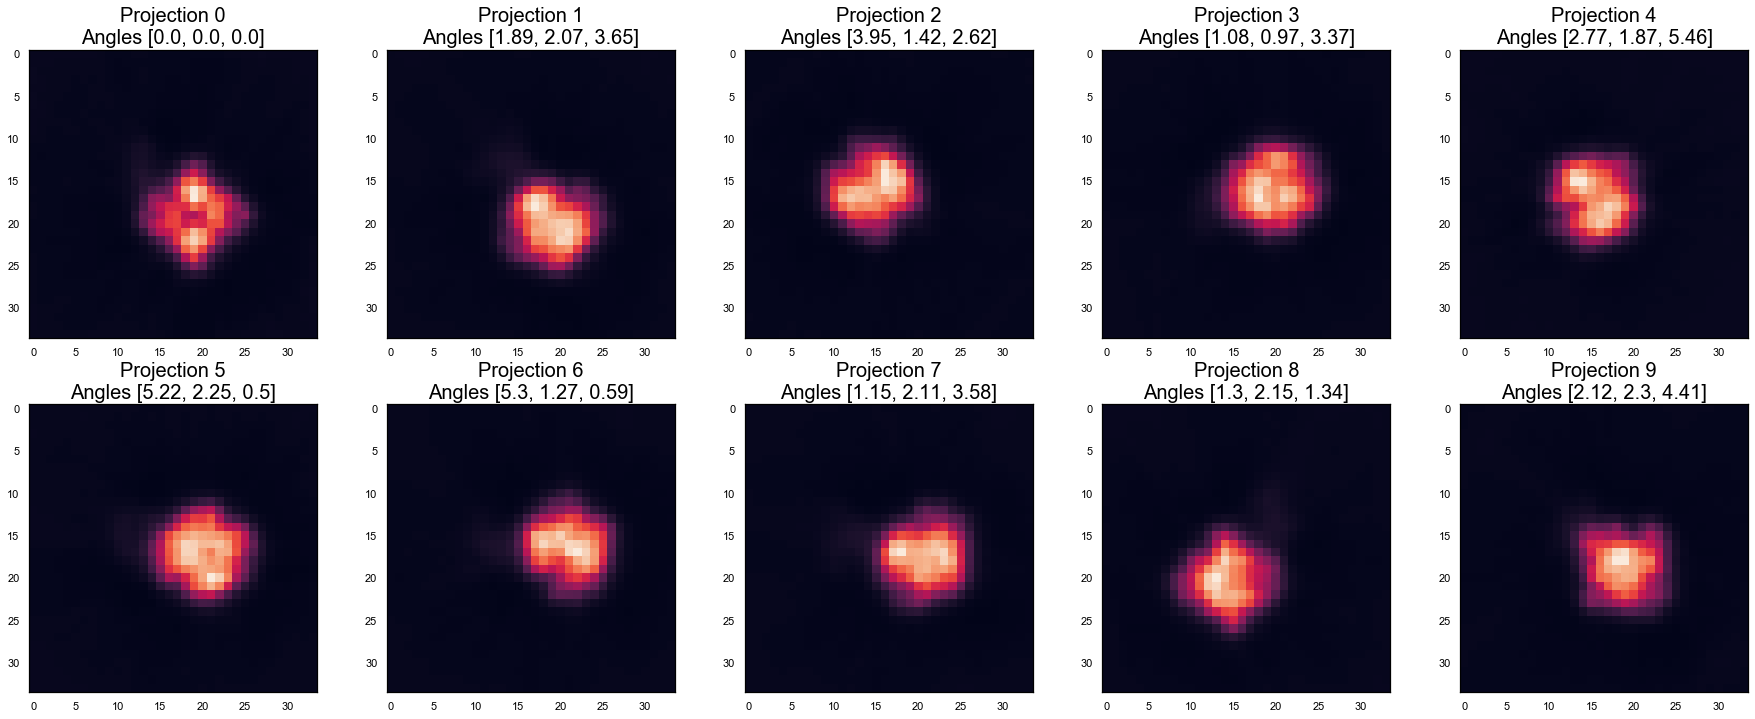

The 11-th iteration


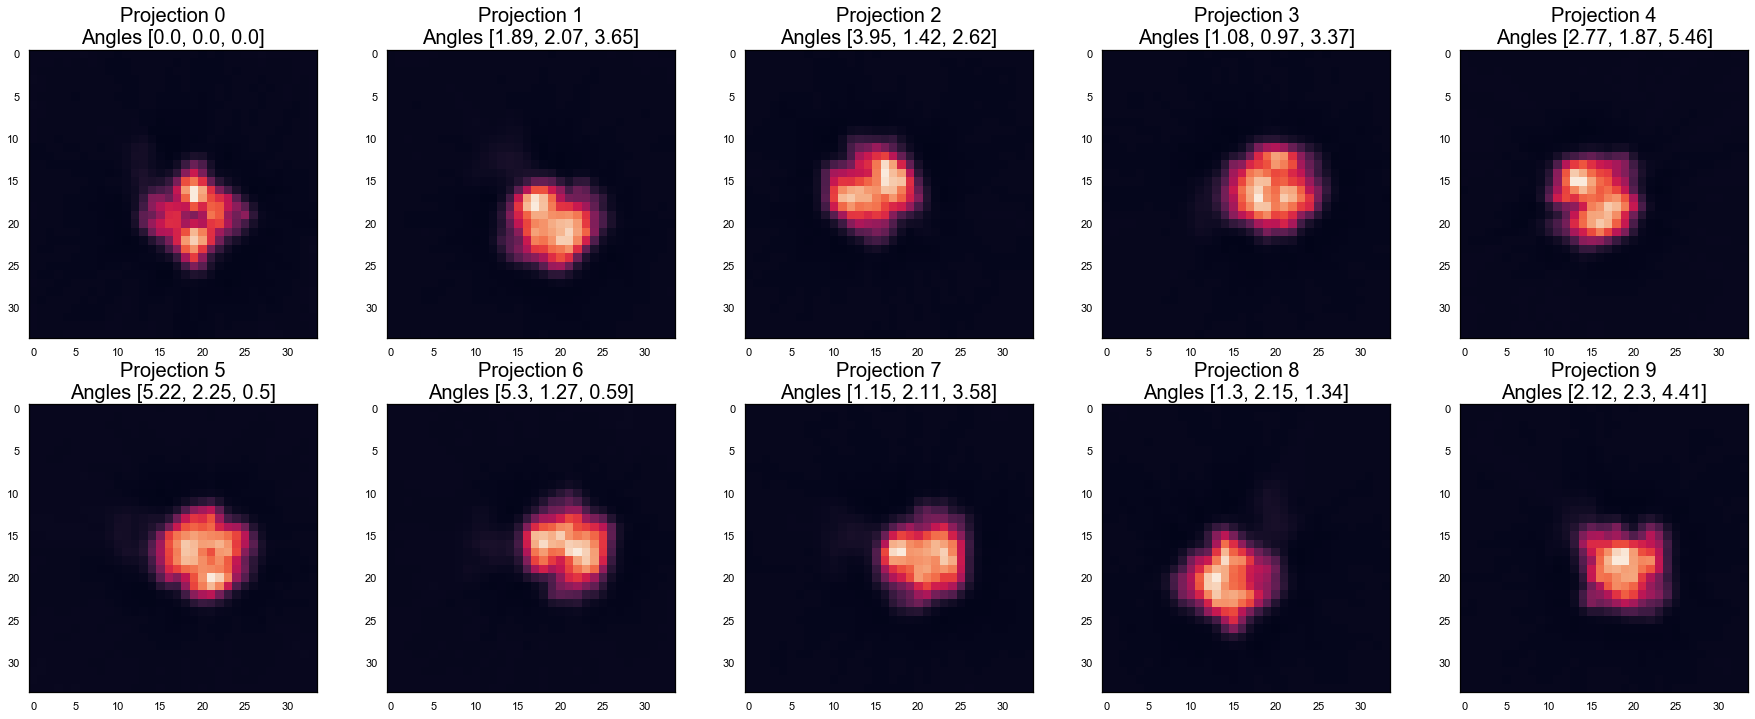

The 21-th iteration


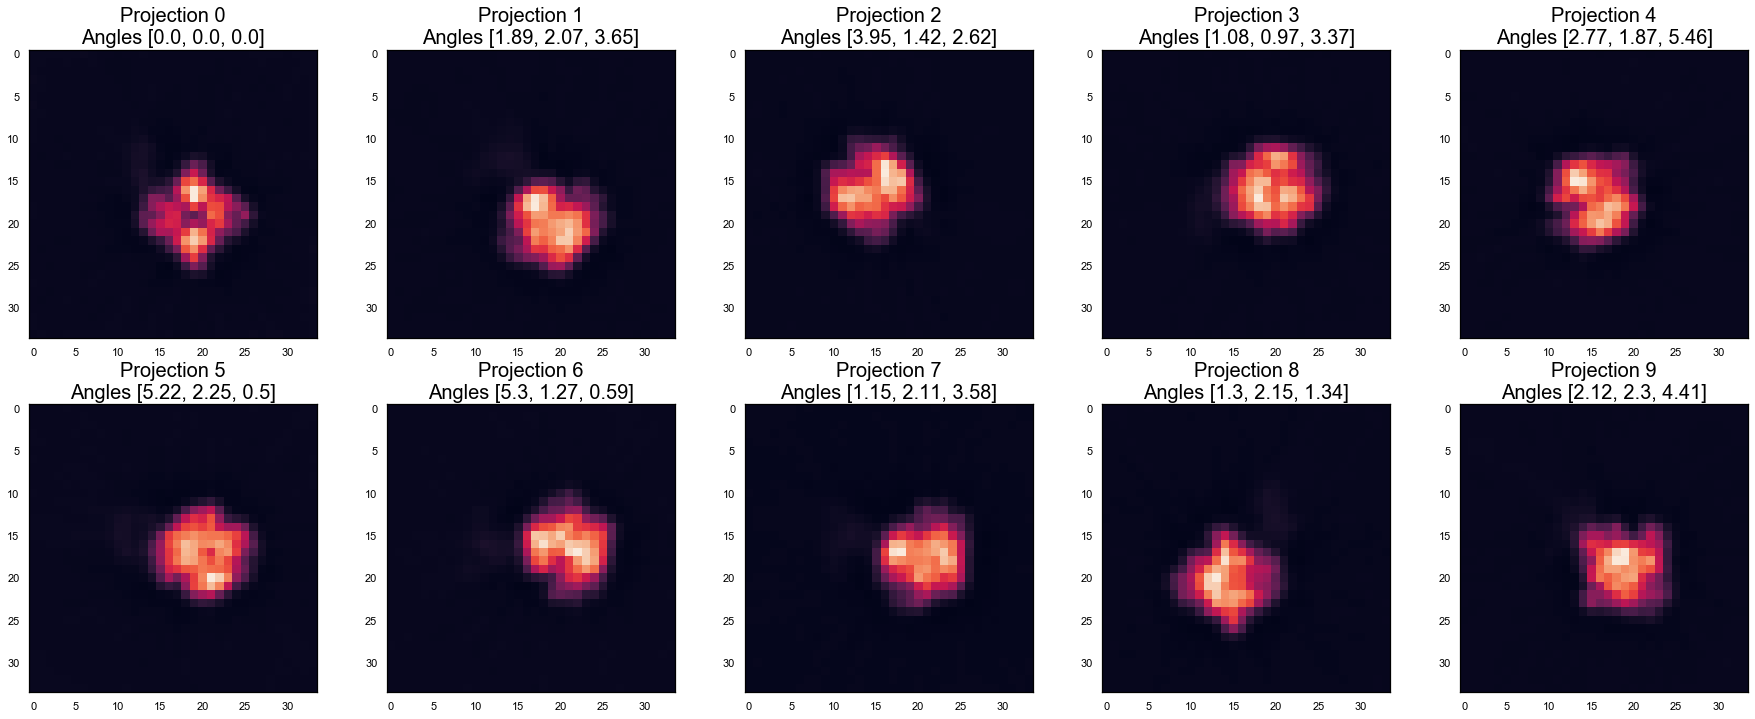

The 31-th iteration


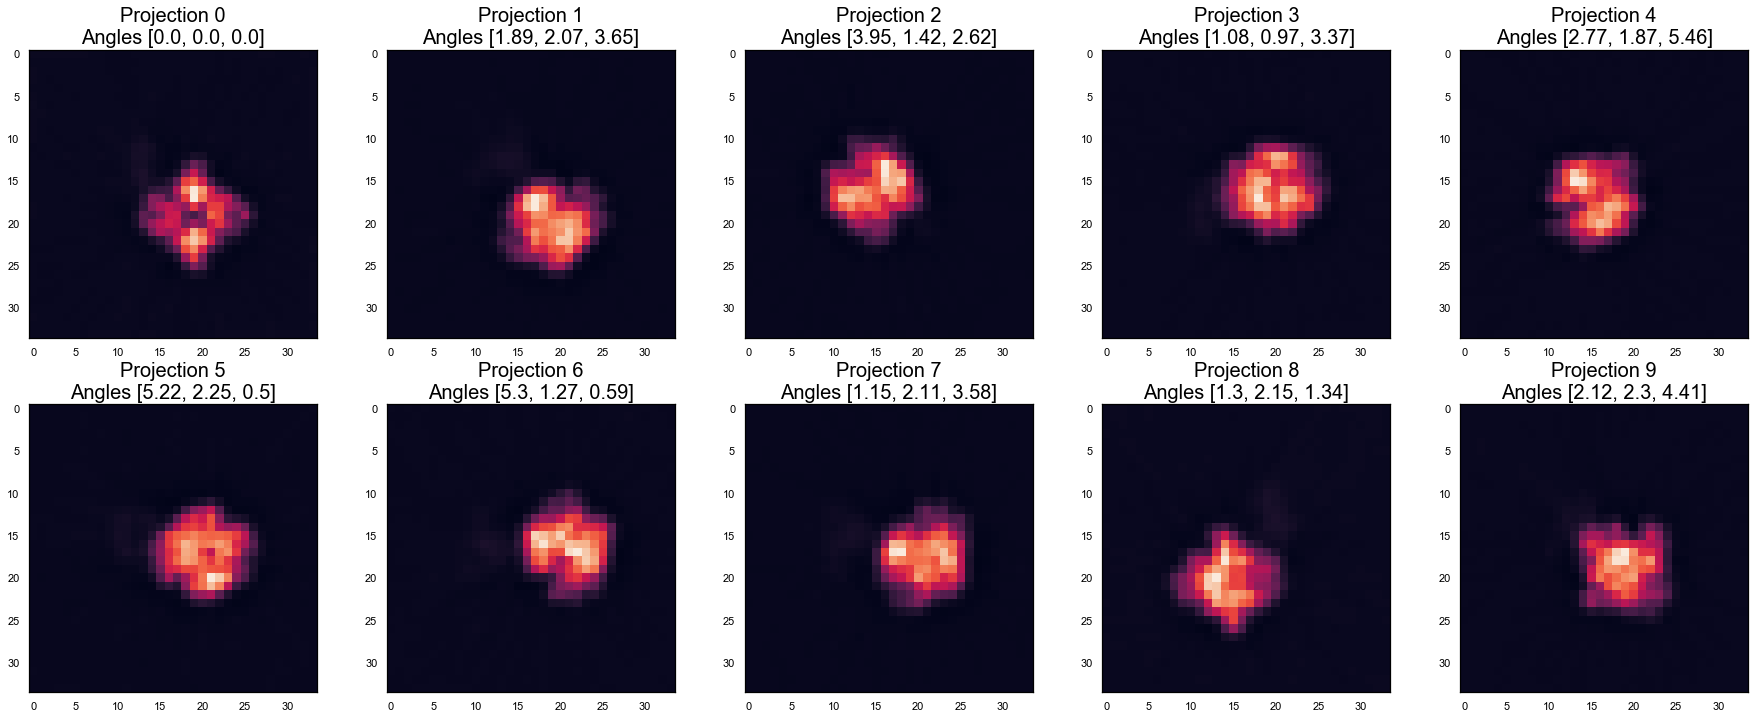

The 41-th iteration


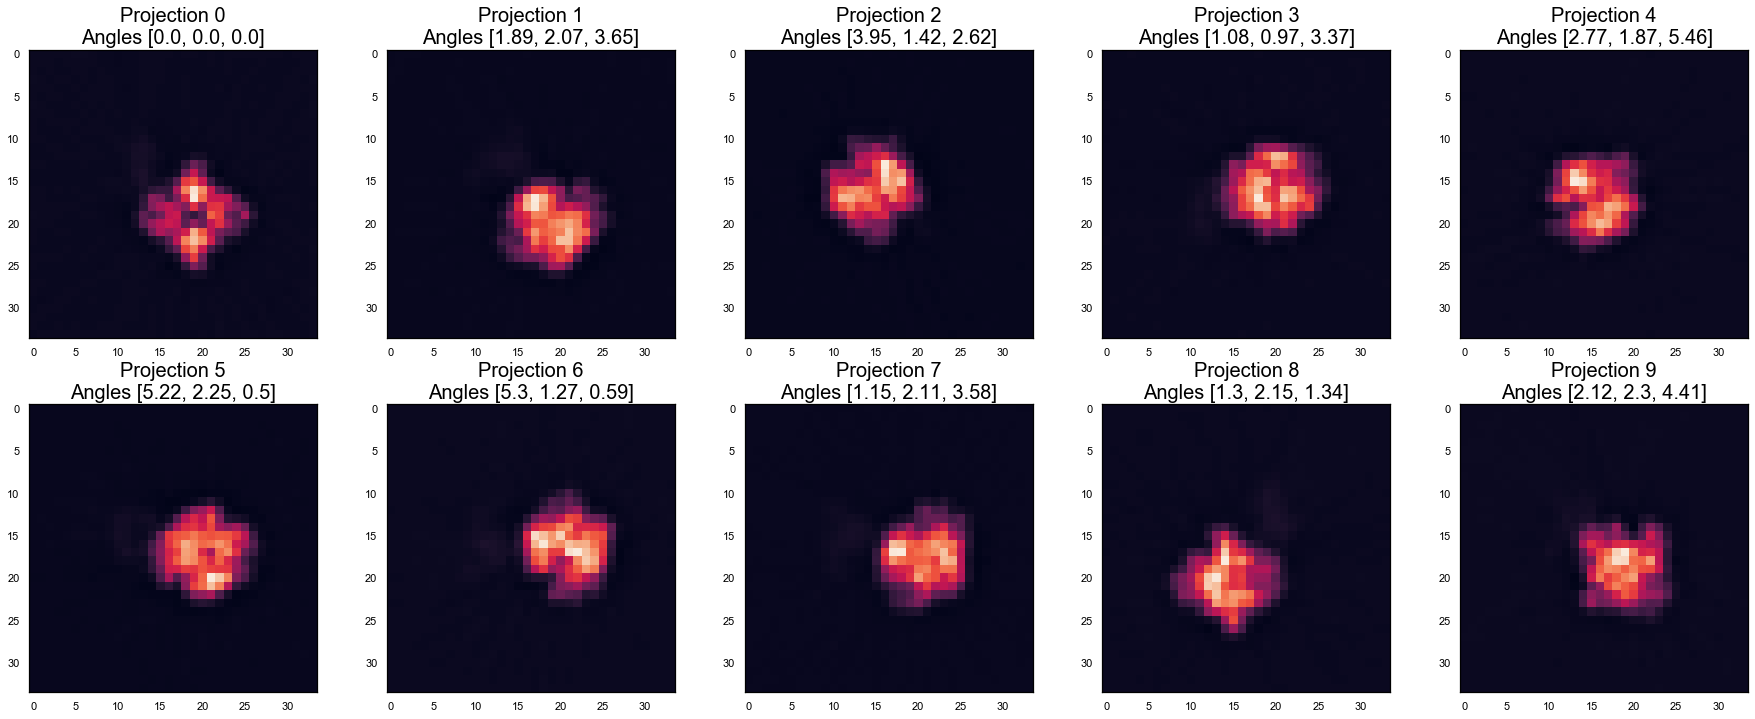

The 51-th iteration


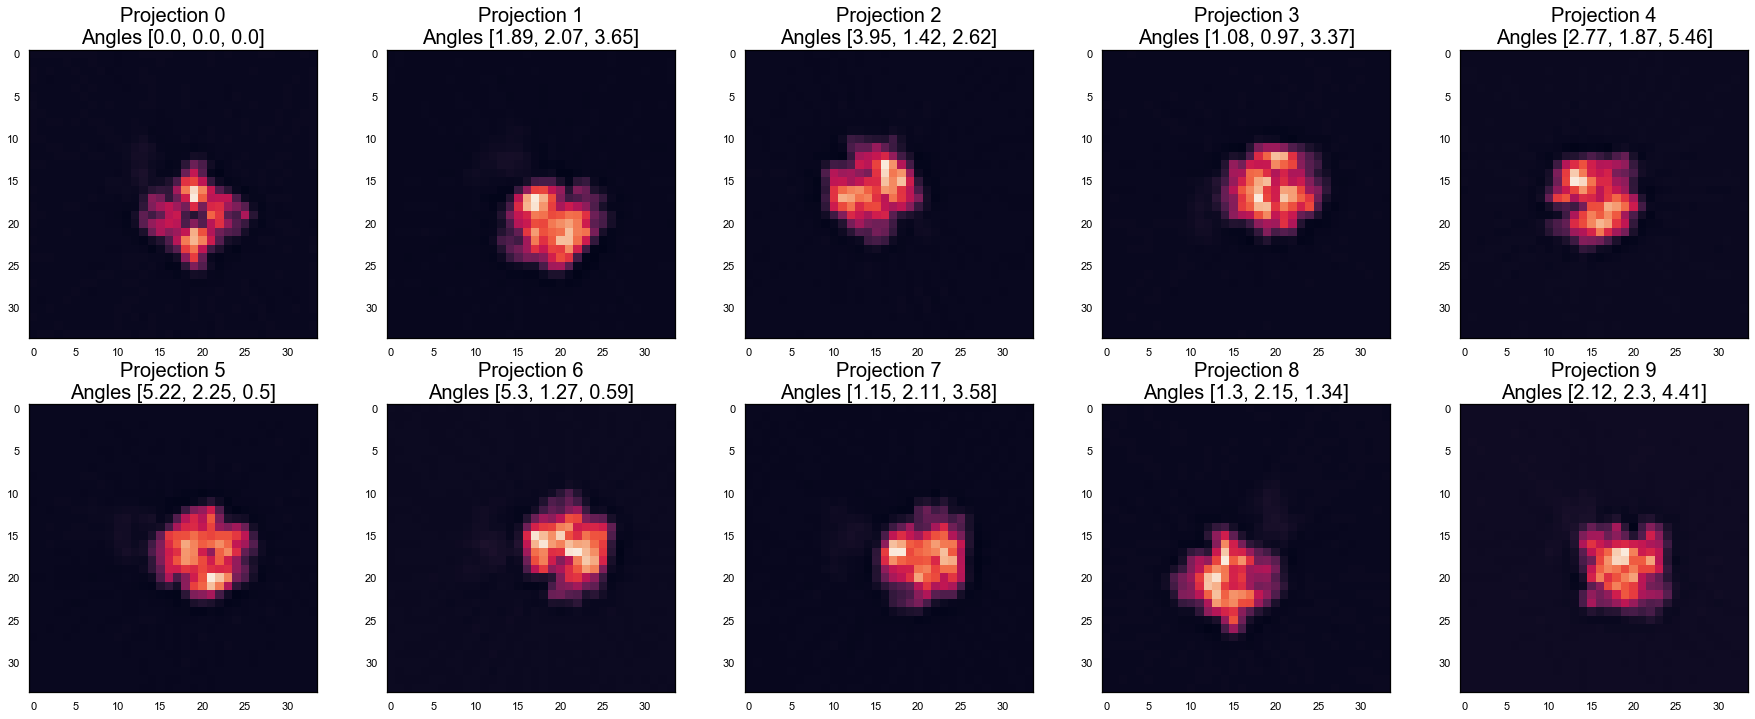

KeyboardInterrupt: 

In [39]:
P3R.fit(new_projection, angles2)


(34, 34, 34)
34
(5000, 1156, 2)
start fitting
The 0-th iteration
Q -2156160198.319151


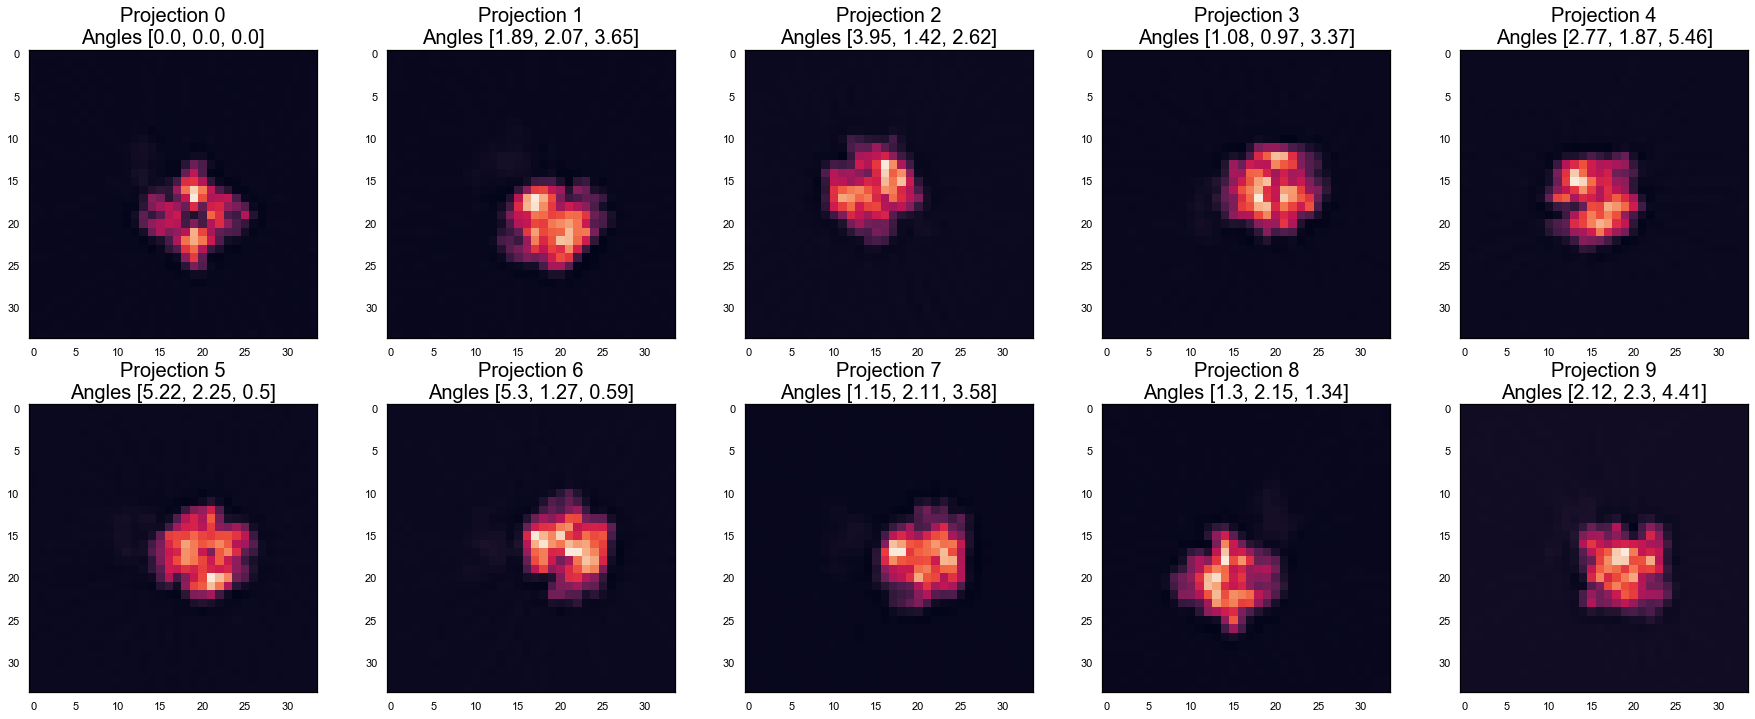

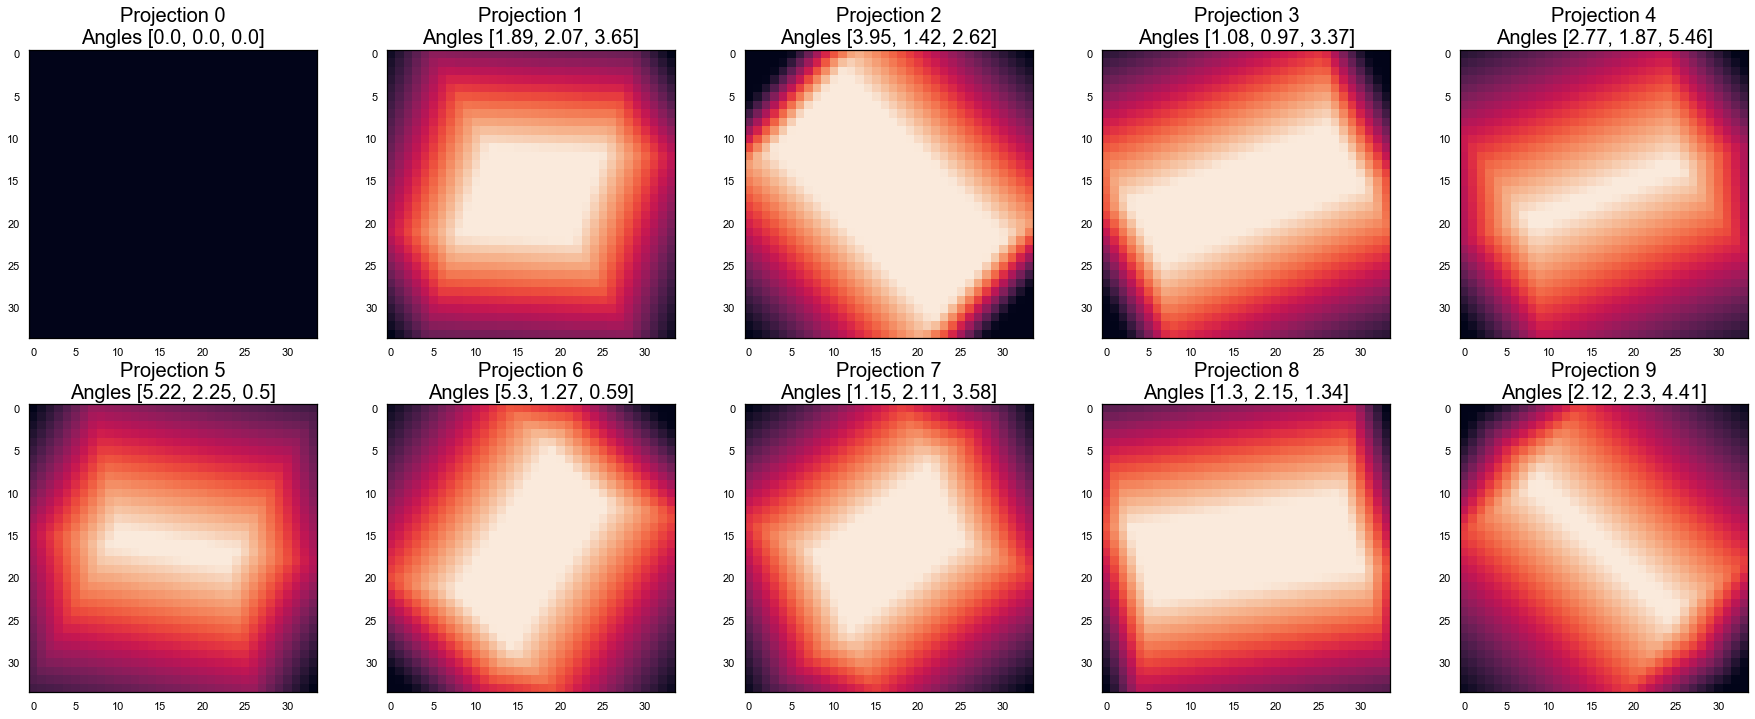

Q 12486743.329812814
delta Q 2168646941.648964
The 1-th iteration


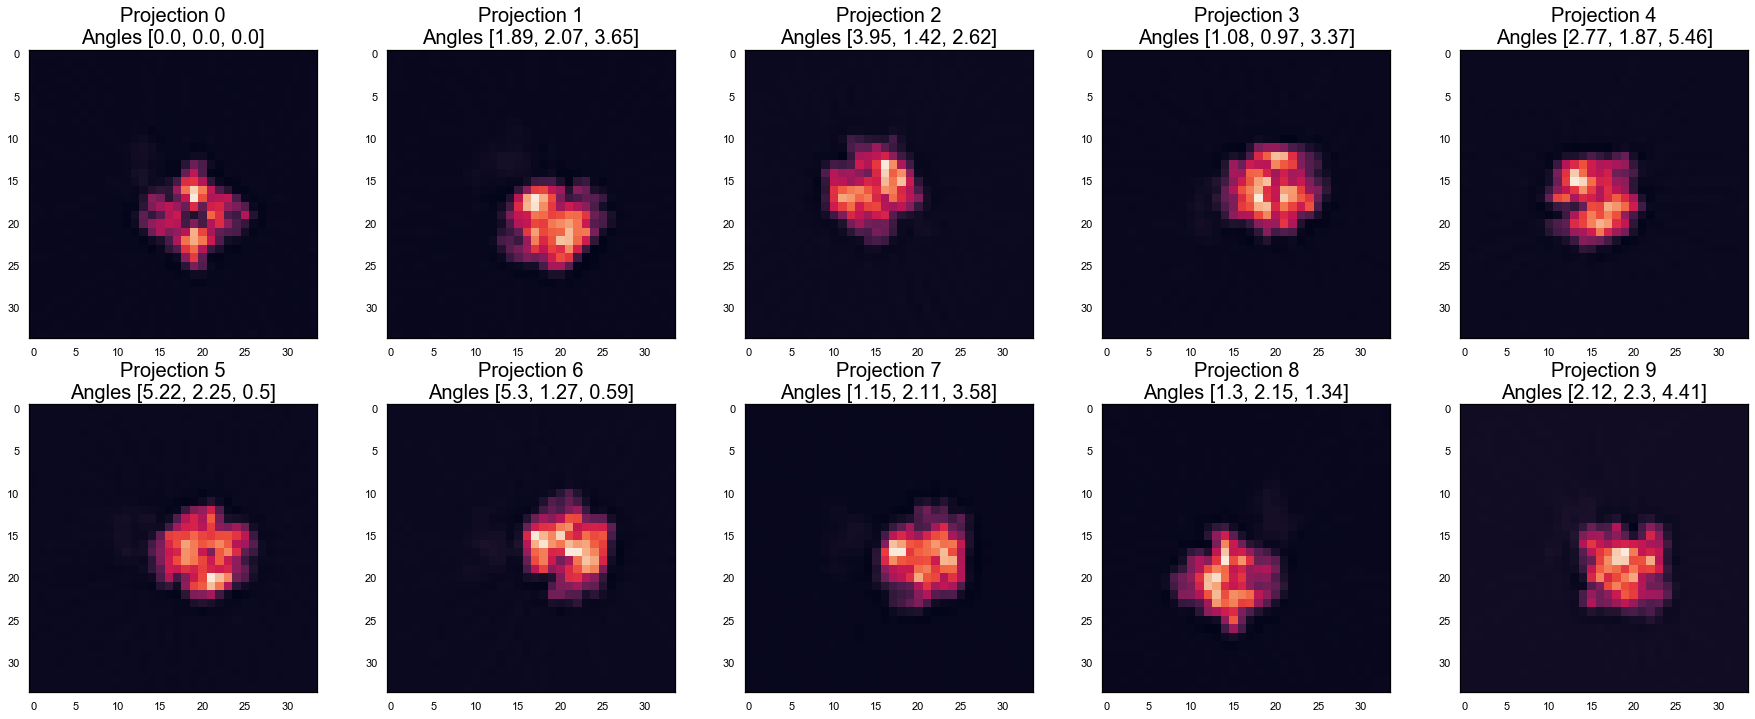

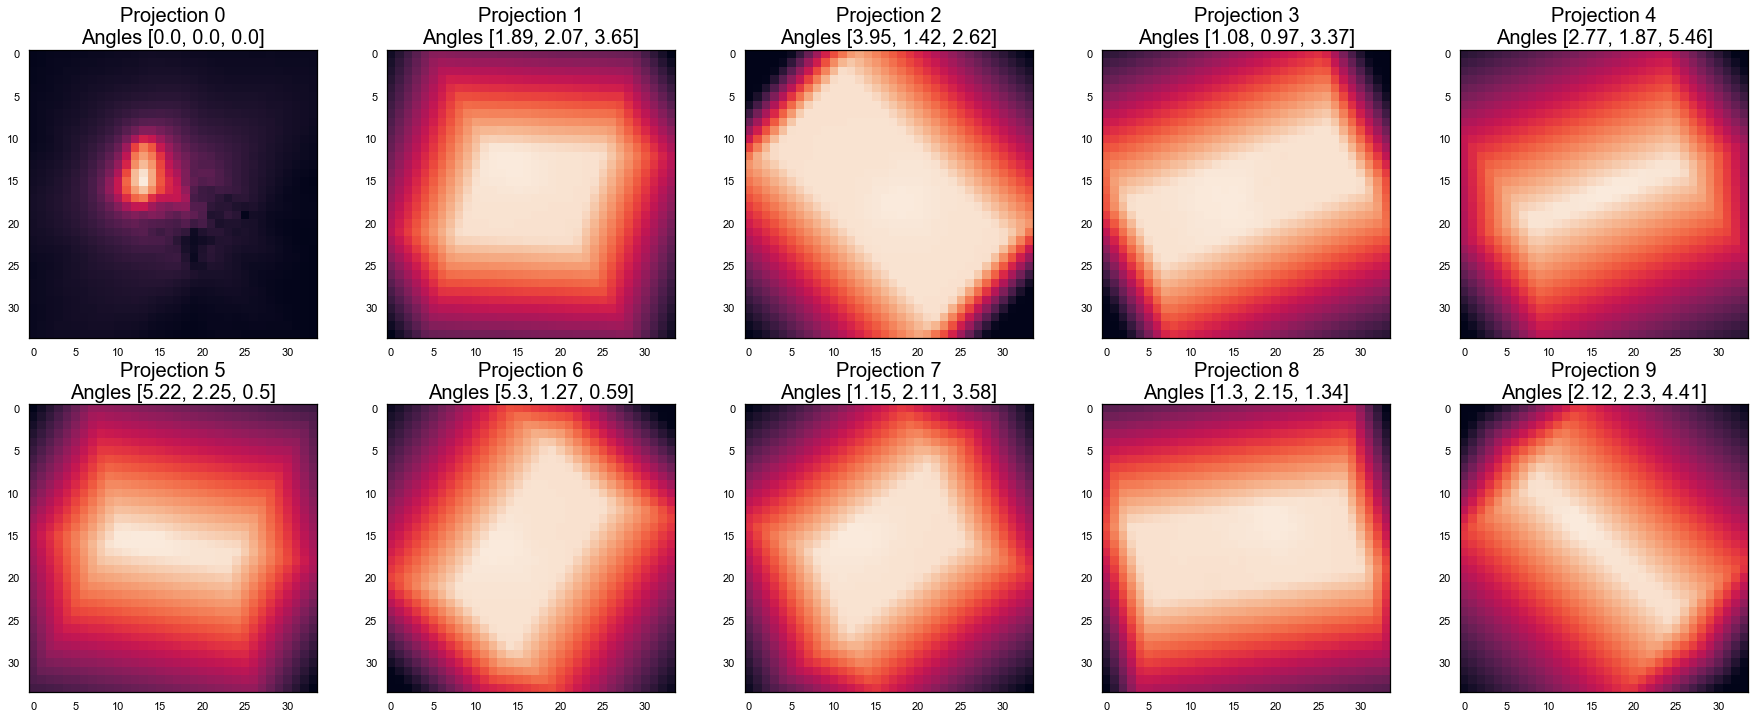

Q 12486743.329812814
delta Q 0.0
Q 10935316.599397846
delta Q -1551426.730414968
Q 11066174.836670756
delta Q 130858.23727291077
Q 11164309.076647593
delta Q 98134.23997683637
Q 11260305.561115546
delta Q 95996.48446795344
Q 11354002.975629749
delta Q 93697.41451420262
Q 11445465.668480314
delta Q 91462.69285056554
Q 11534765.450306764
delta Q 89299.78182644956
Q 11621972.600241546
delta Q 87207.14993478172
Q 11707156.797957659
delta Q 85184.19771611318
Q 11790387.42110341
delta Q 83230.62314575166
The 11-th iteration


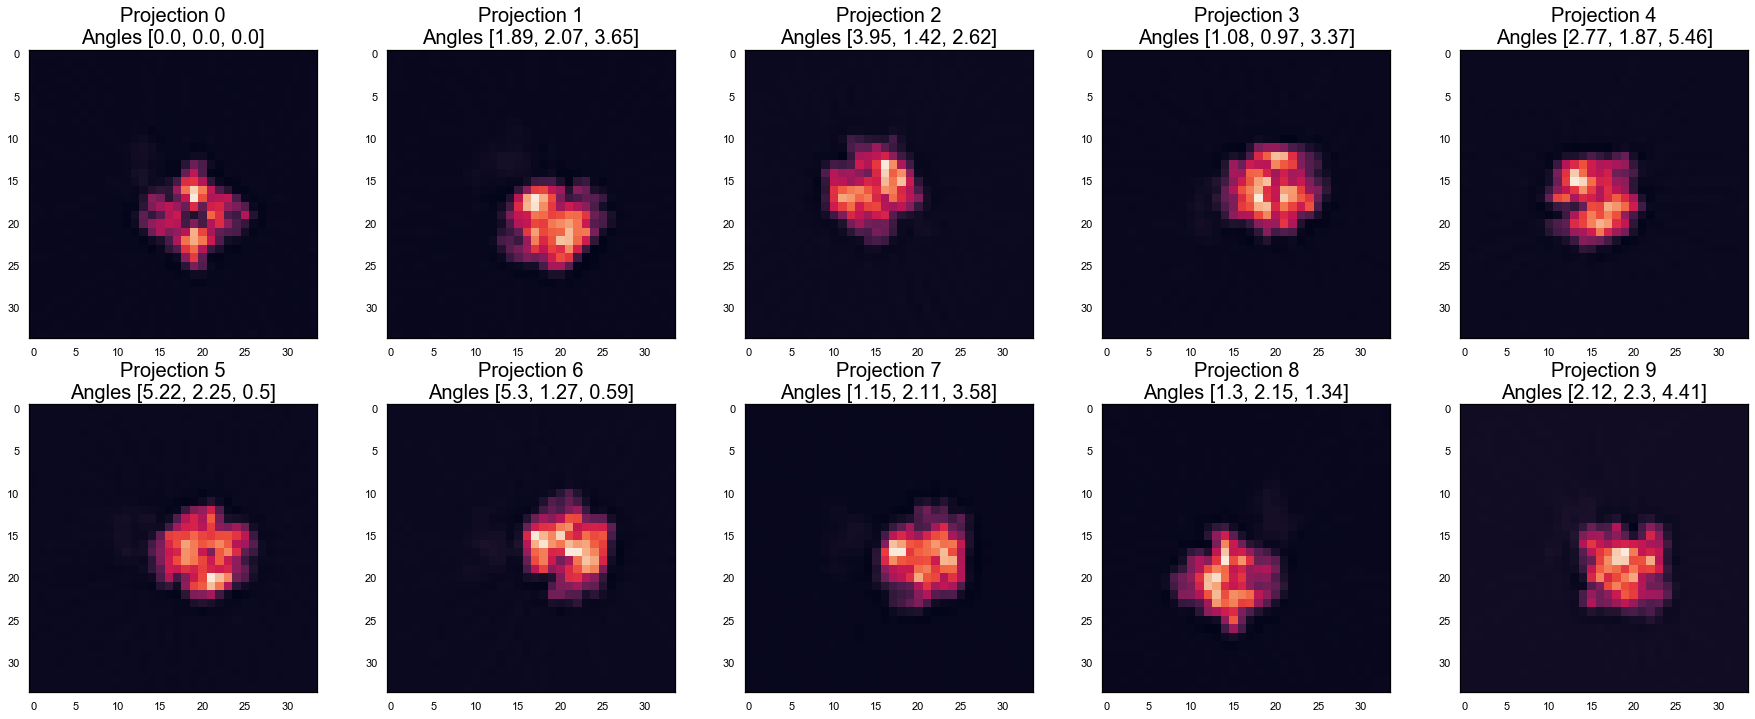

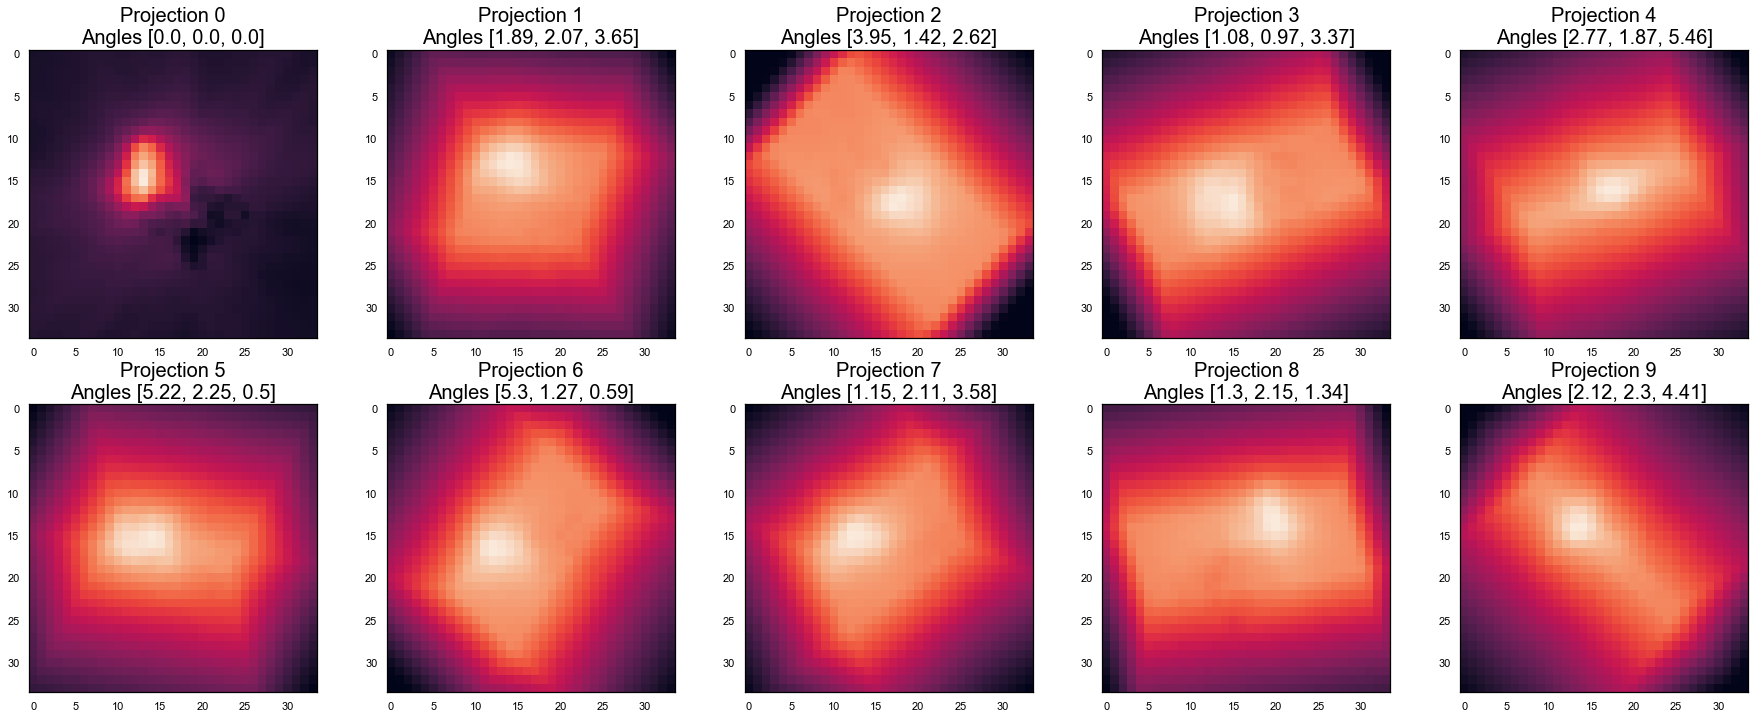

Q 11790387.42110341
delta Q 0.0
Q 11871731.84922104
delta Q 81344.42811762914
Q 11951260.148199052
delta Q 79528.29897801206
Q 12029038.858486153
delta Q 77778.71028710157
Q 12105137.315336851
delta Q 76098.45685069822
Q 12179621.61084336
delta Q 74484.29550650902
Q 12252562.339825038
delta Q 72940.72898167744
Q 12324025.377813967
delta Q 71463.03798892908
Q 12394079.335631117
delta Q 70053.95781715028
Q 12462790.21694137
delta Q 68710.88131025247
Q 12530229.04728727
delta Q 67438.83034590073
The 21-th iteration


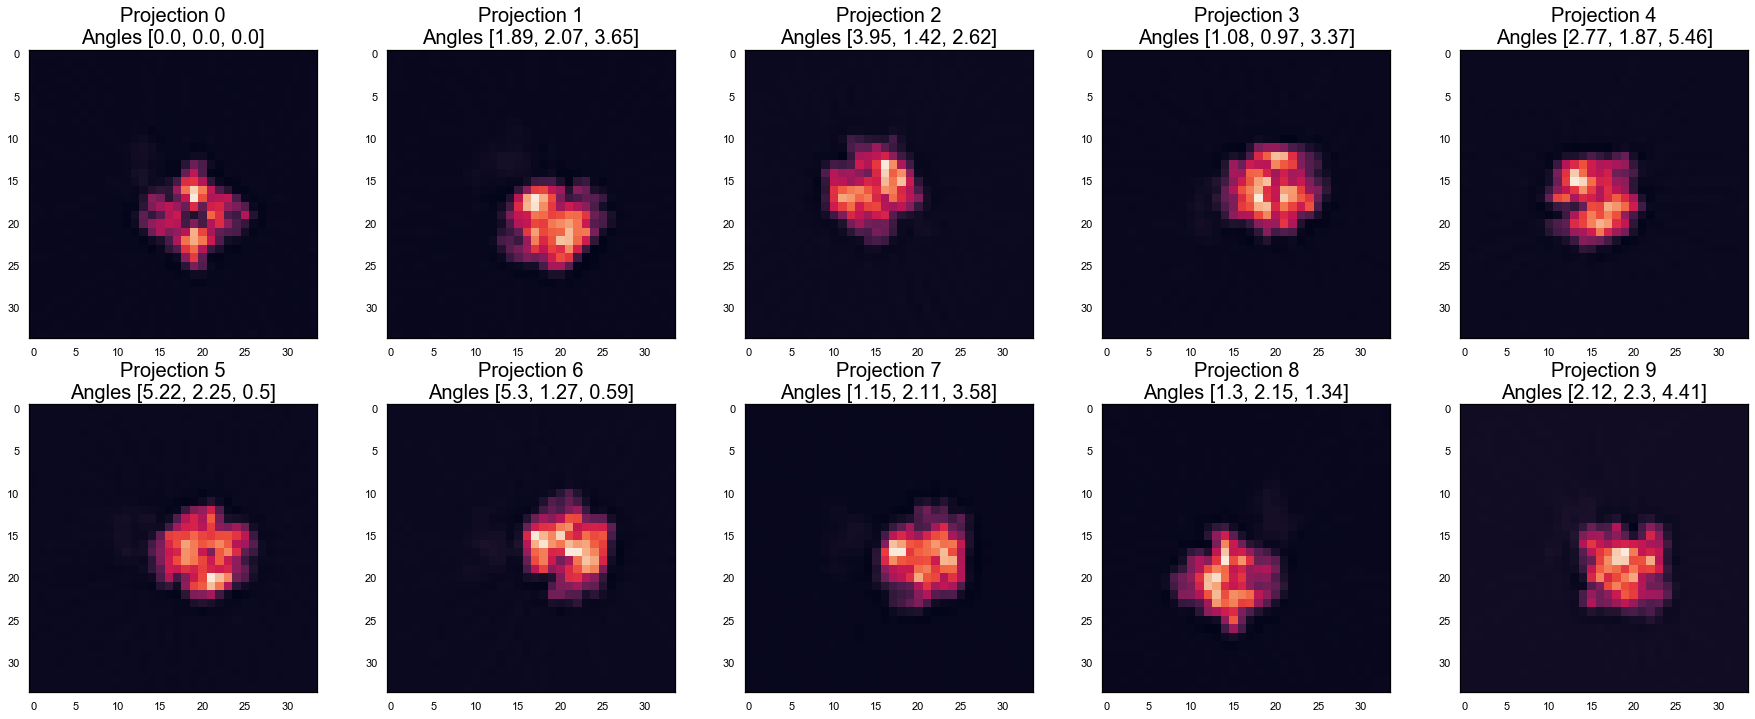

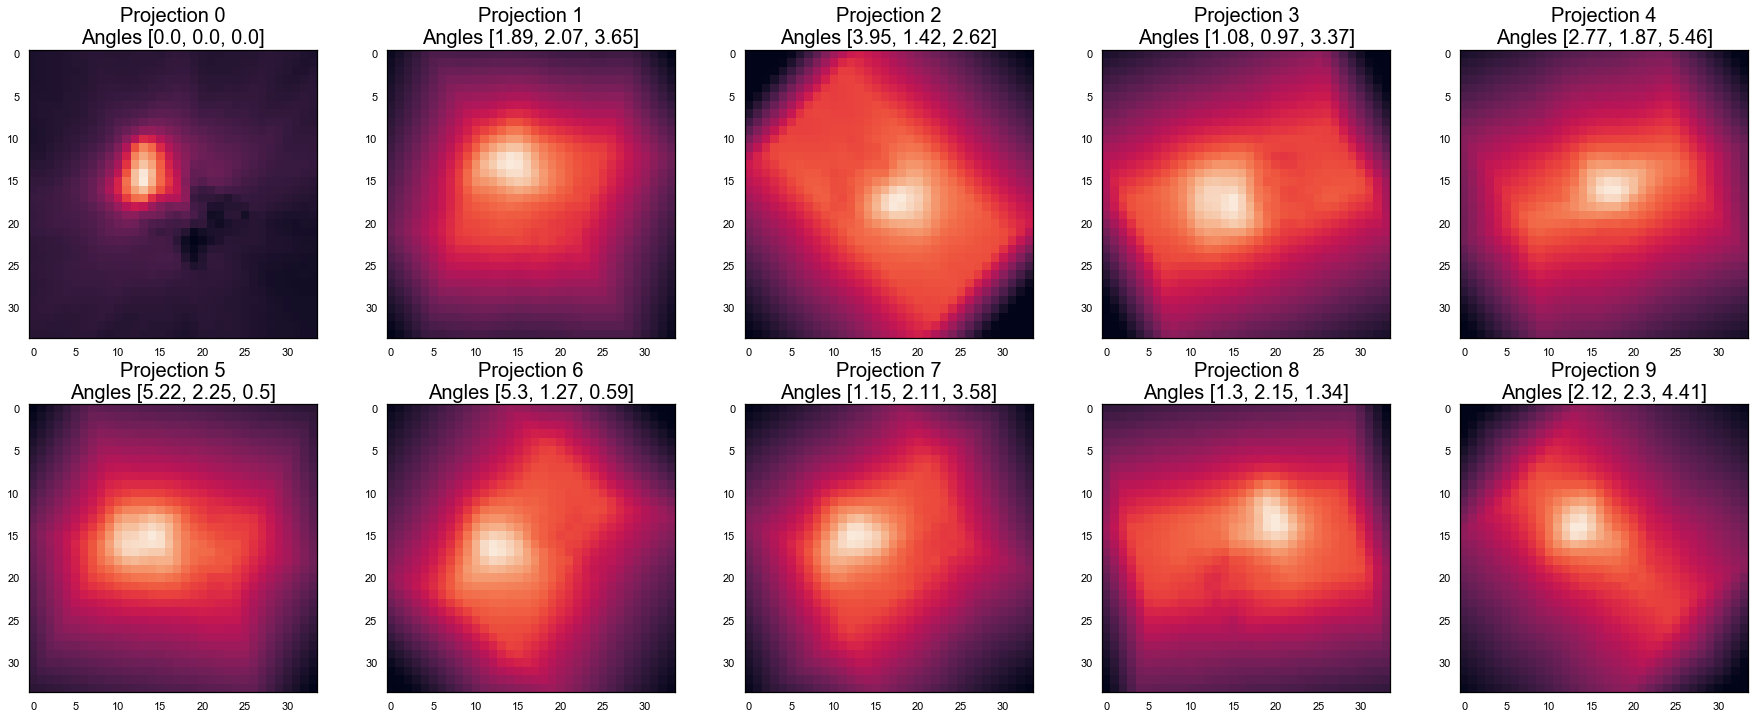

Q 12530229.04728727
delta Q 0.0
Q 12596463.970519409
delta Q 66234.92323213816
Q 12661563.536479121
delta Q 65099.56595971249
Q 12725596.634077046
delta Q 64033.09759792499
Q 12788635.51417431
delta Q 63038.880097264424
Q 12850747.430483758
delta Q 62111.91630944796
Q 12912004.450897012
delta Q 61257.020413253456
Q 12972479.771817561
delta Q 60475.32092054933
Q 13032244.73719147
delta Q 59764.9653739091
Q 13091372.856991498
delta Q 59128.11980002746
Q 13149937.17839679
delta Q 58564.32140529156
The 31-th iteration


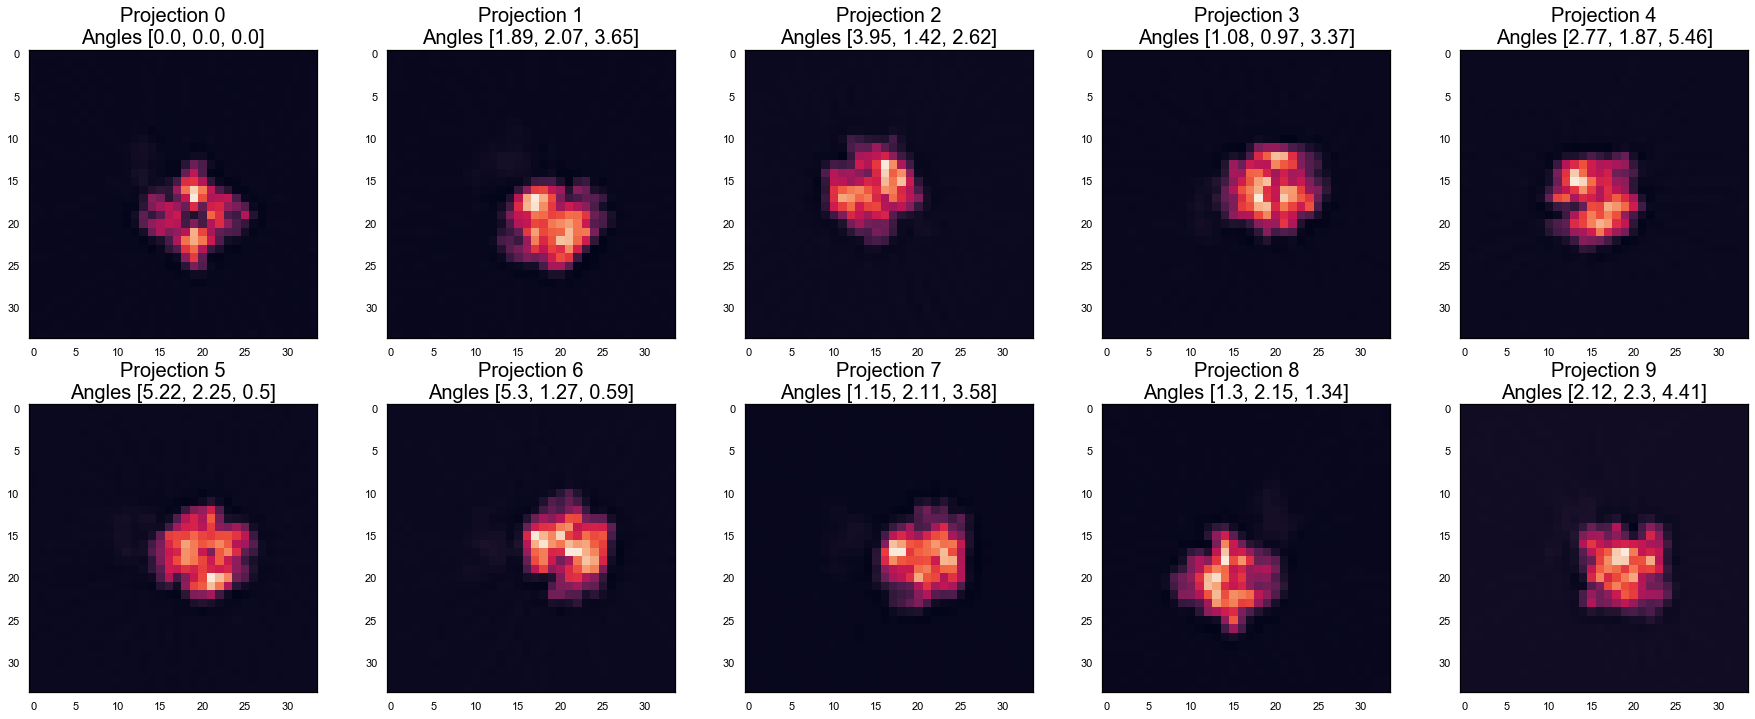

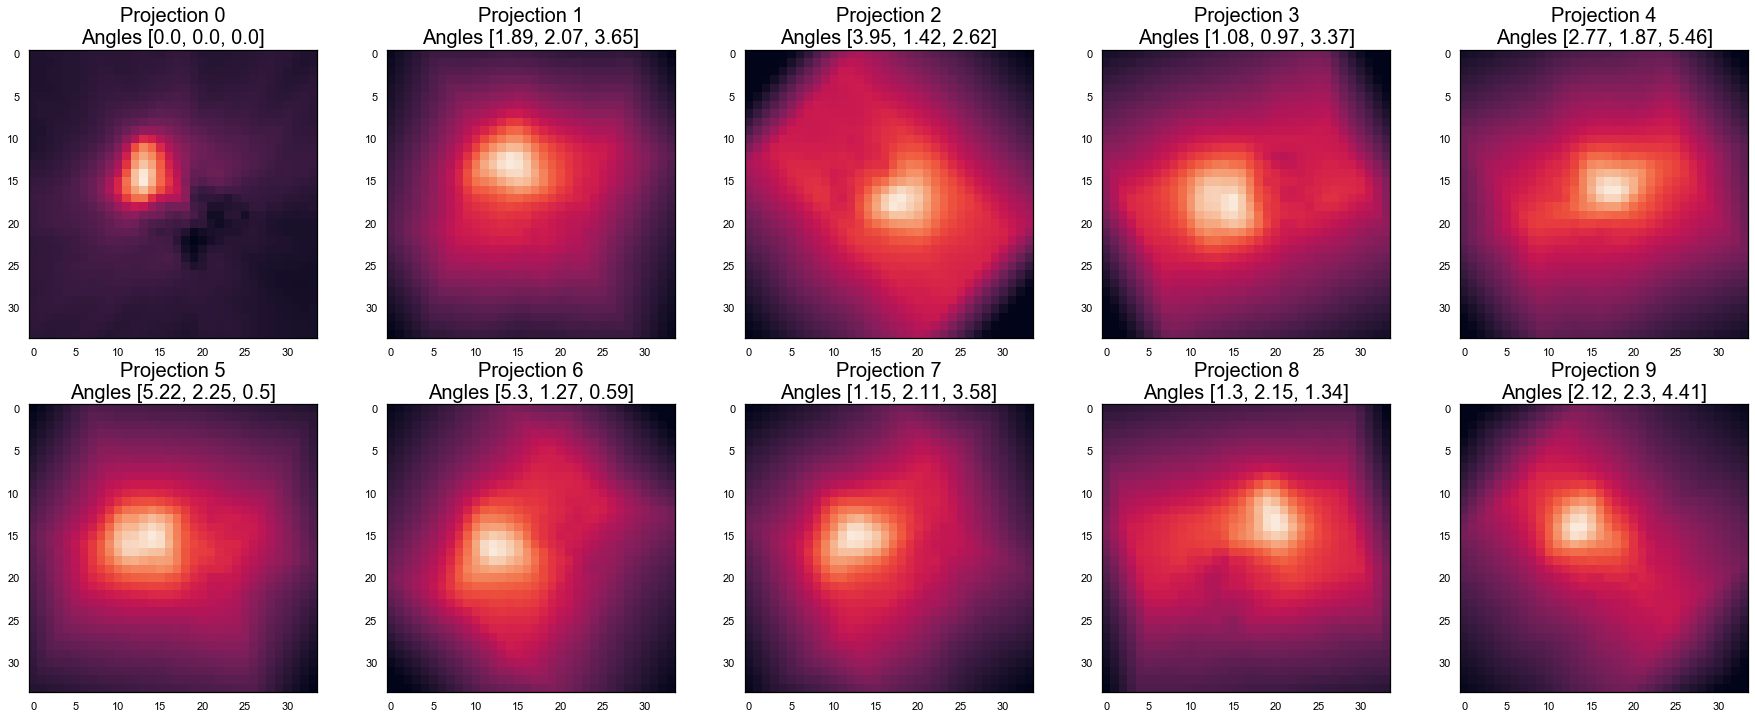

Q 13149937.17839679
delta Q 0.0
Q 13208014.012743028
delta Q 58076.834346238524
Q 13265679.414413786
delta Q 57665.40167075768
Q 13323010.131020304
delta Q 57330.716606518254
Q 13380084.435552614
delta Q 57074.304532309994
Q 13436979.594585907
delta Q 56895.159033292904
Q 13493779.310267491
delta Q 56799.71568158455
Q 13550562.657490509
delta Q 56783.347223017365
Q 13607414.271817863
delta Q 56851.61432735436
Q 13664417.465014206
delta Q 57003.19319634326
Q 13721659.177758748
delta Q 57241.712744541466
The 41-th iteration


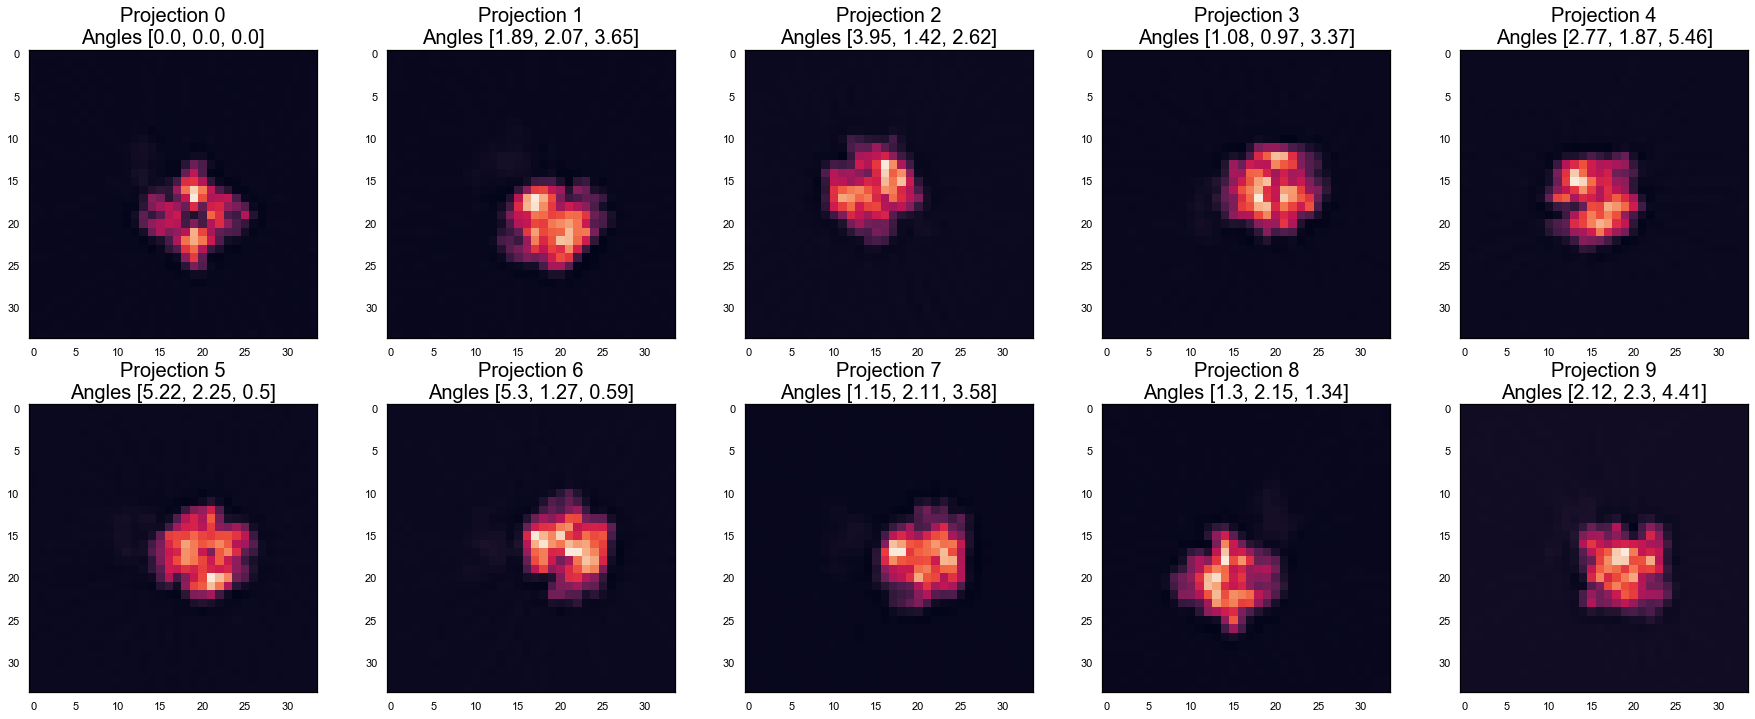

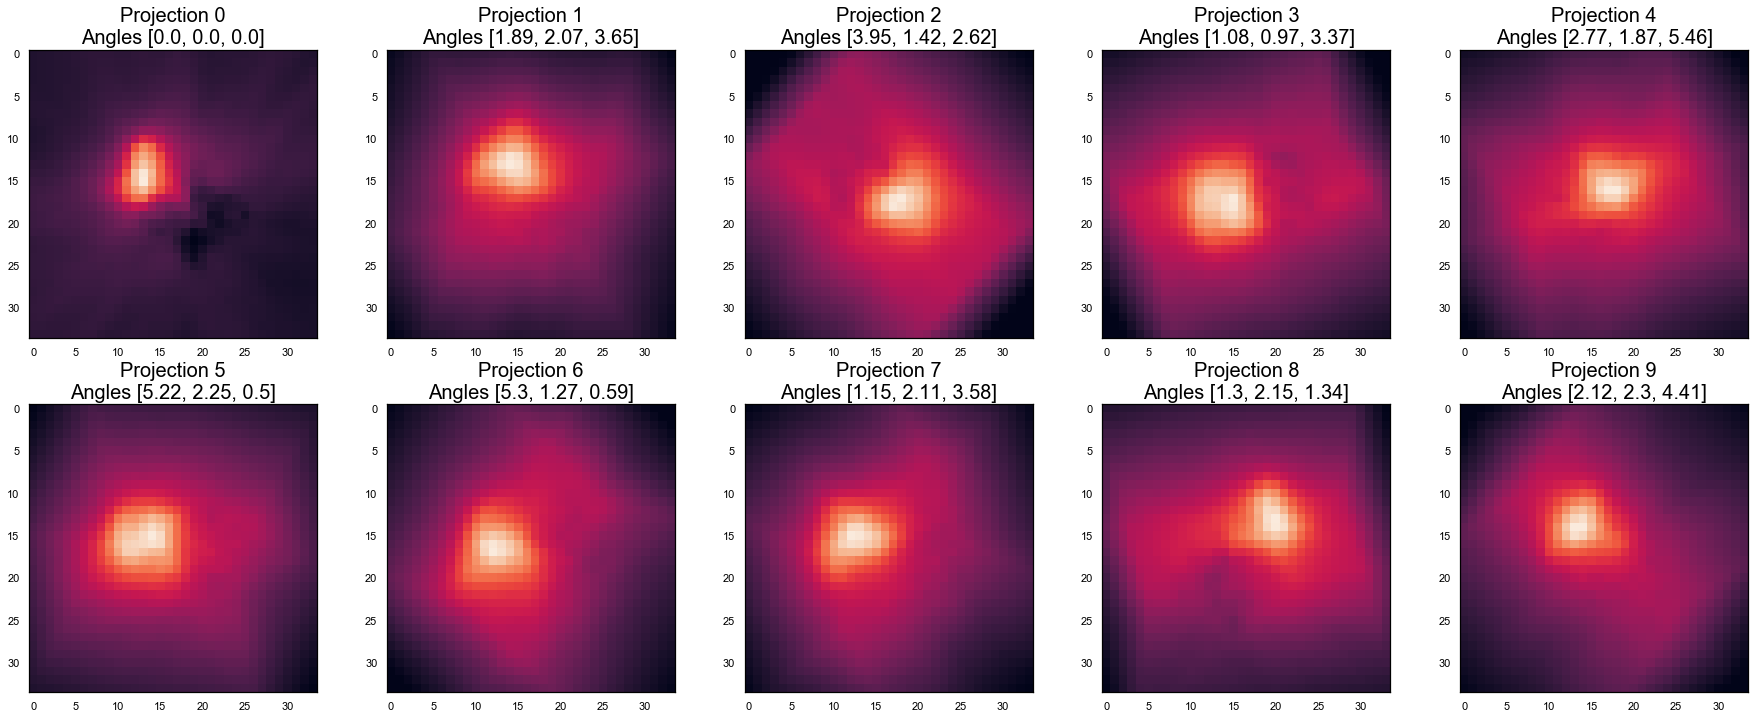

Q 13721659.177758748
delta Q 0.0
Q 13779225.602795733
delta Q 57566.42503698543
Q 13837206.987078002
delta Q 57981.384282268584
Q 13895692.298470588
delta Q 58485.31139258668
Q 13954776.43305065
delta Q 59084.13458006084
Q 14014549.425908778
delta Q 59772.99285812862
Q 14075111.176289948
delta Q 60561.75038116984
Q 14136556.19511822
delta Q 61445.01882827282
Q 14198985.224406201
delta Q 62429.02928798087
Q 14262499.810753826
delta Q 63514.58634762466
Q 14327202.729882095
delta Q 64702.91912826896
The 51-th iteration


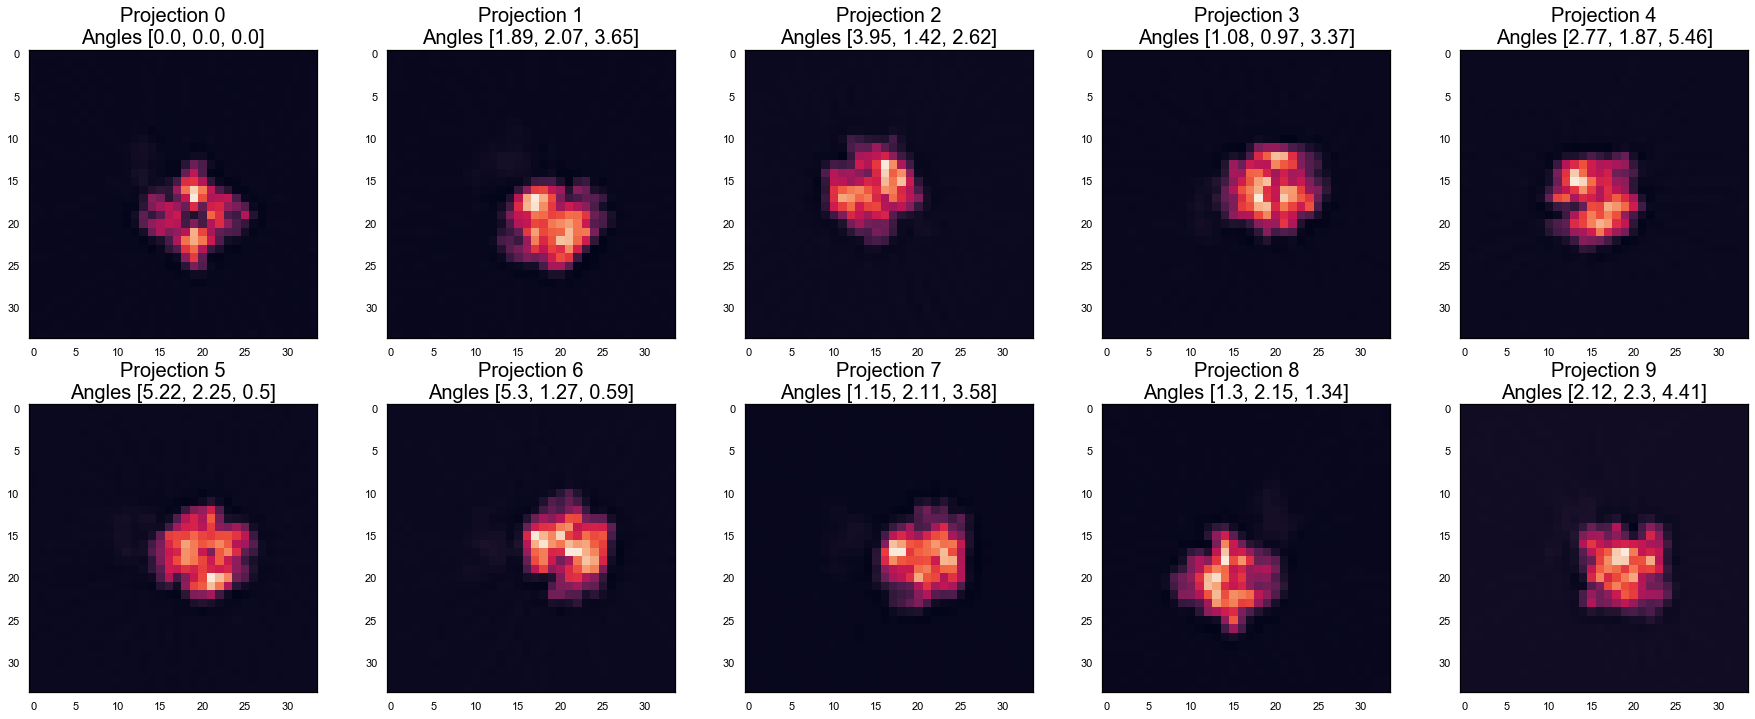

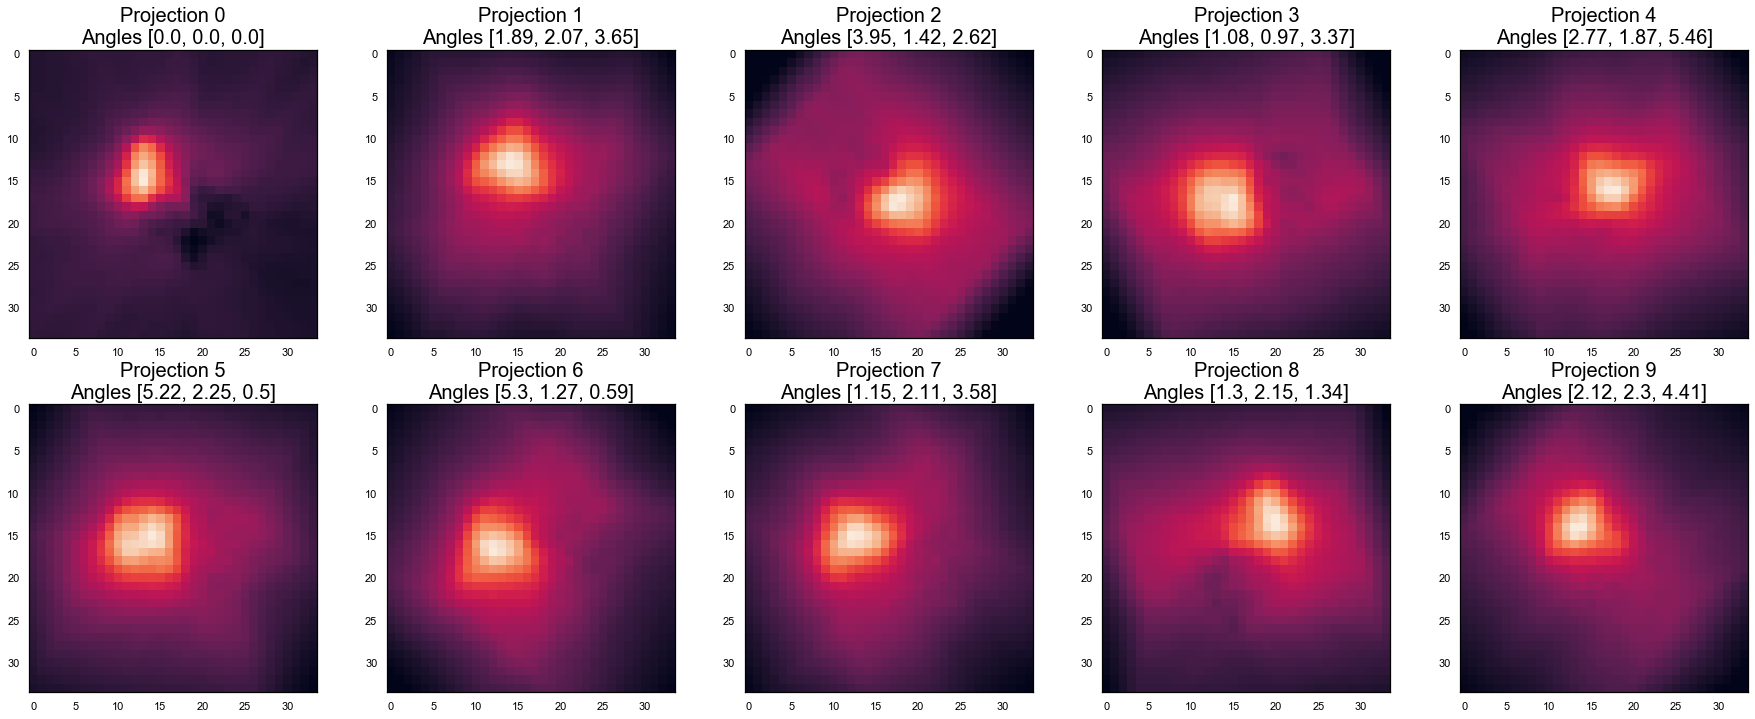

Q 14327202.729882095
delta Q 0.0
Q 14393199.865853544
delta Q 65997.13597144932
Q 14460600.138006274
delta Q 67400.27215272933
Q 14529510.52854735
delta Q 68910.39054107666
Q 14600045.546405574
delta Q 70535.01785822399
Q 14672319.328383898
delta Q 72273.78197832406
Q 14746445.156740174
delta Q 74125.82835627533
Q 14822547.416052053
delta Q 76102.25931187905
Q 14900743.67286948
delta Q 78196.25681742653
Q 14981157.201061245
delta Q 80413.52819176577
Q 15063916.722379064
delta Q 82759.52131781913
The 61-th iteration


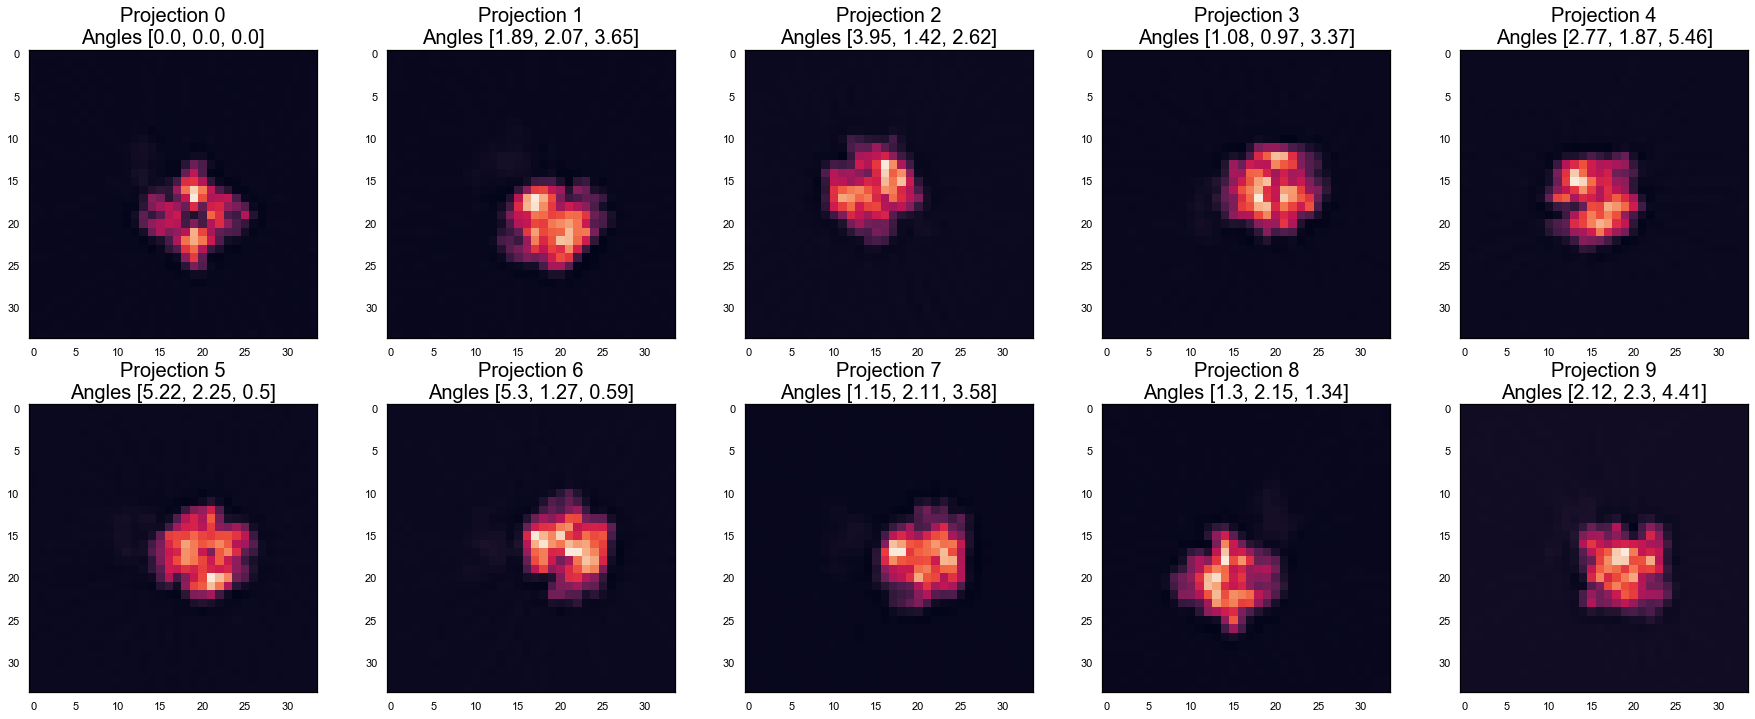

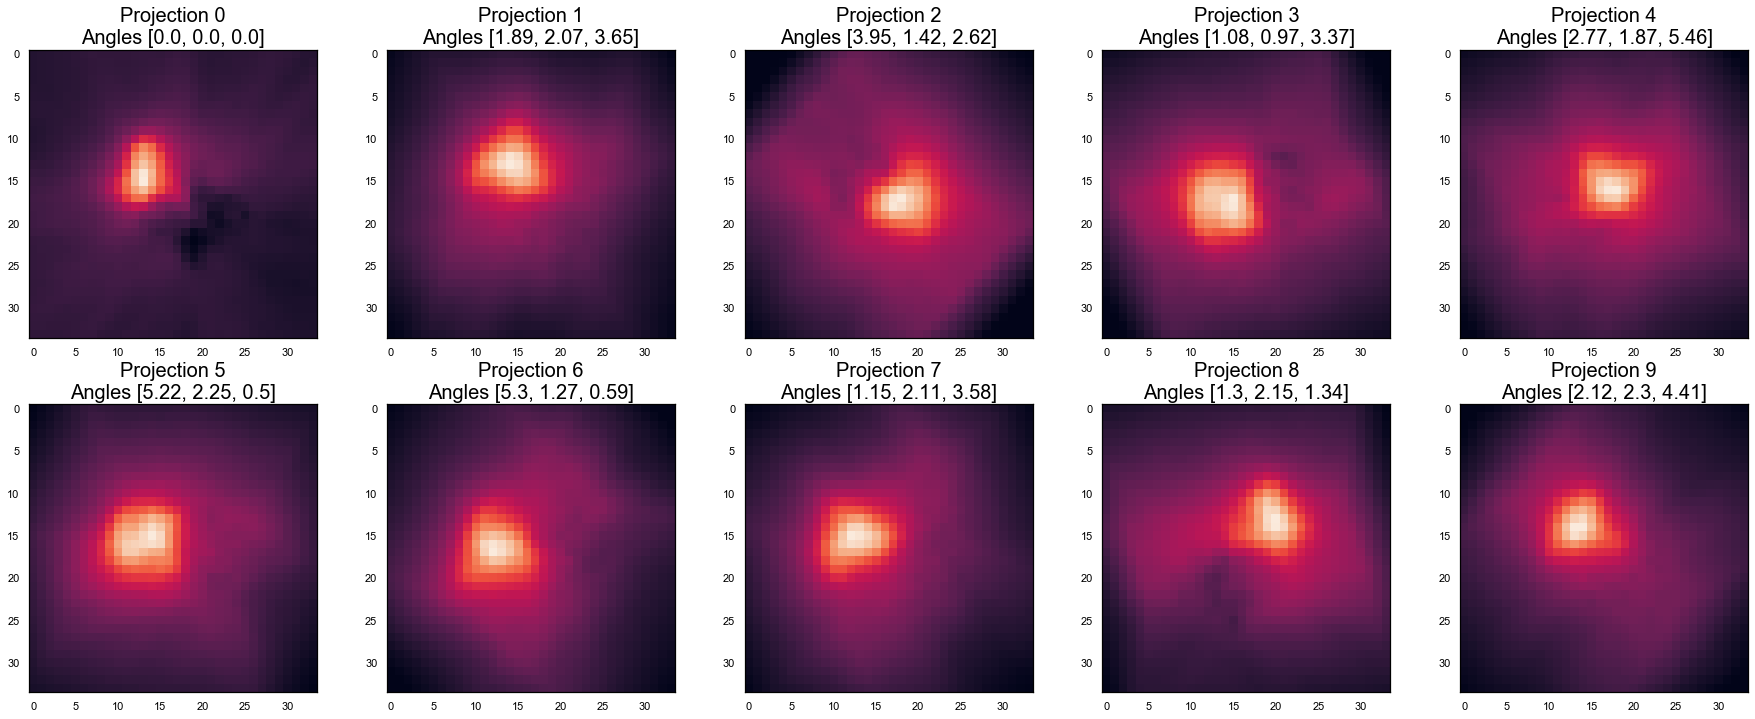

Q 15063916.722379064
delta Q 0.0
Q 15149150.54407562
delta Q 85233.82169655524
Q 15236987.994779425
delta Q 87837.45070380531
Q 15327564.437104933
delta Q 90576.44232550822
Q 15421017.150669076
delta Q 93452.71356414258
Q 15517483.469550474
delta Q 96466.31888139807
Q 15617106.552981153
delta Q 99623.08343067952
Q 15720029.187452758
delta Q 102922.6344716046
Q 15826399.310280256
delta Q 106370.12282749824
Q 15936366.123917416
delta Q 109966.81363715976
Q 16050084.053536825
delta Q 113717.92961940914
The 71-th iteration


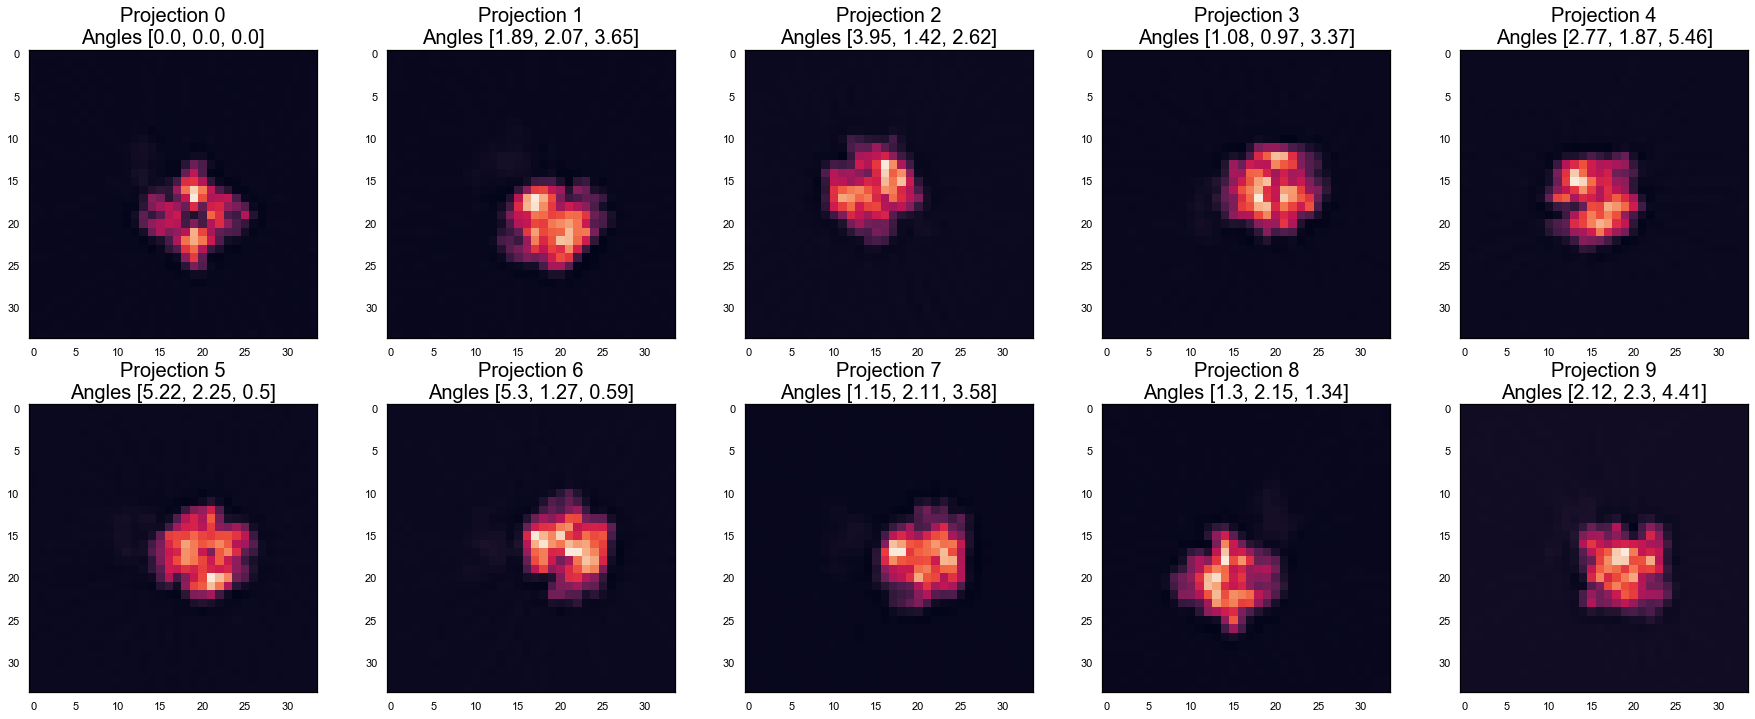

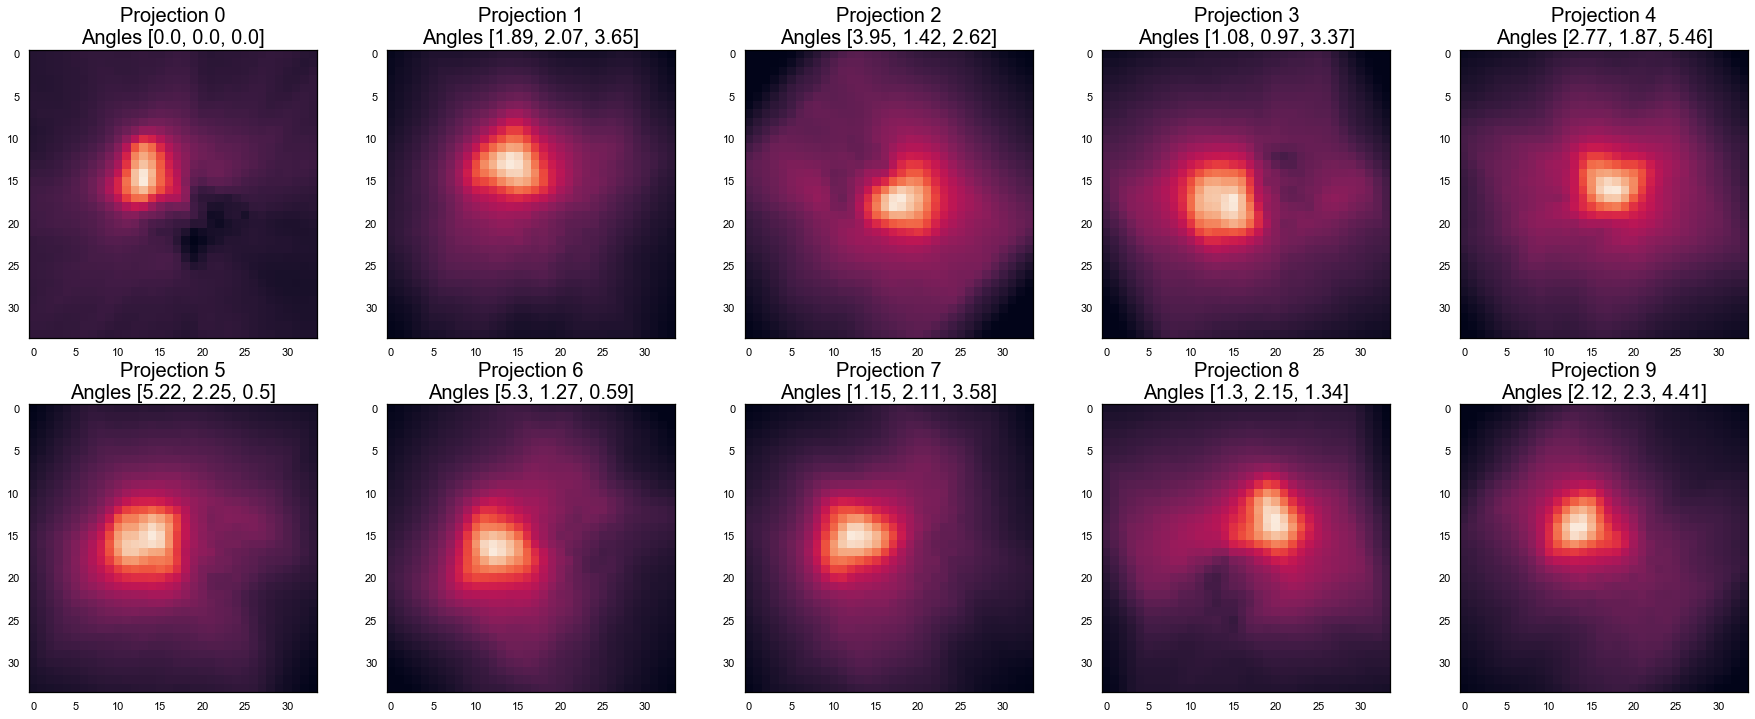

Q 16050084.053536825
delta Q 0.0
Q 16167705.405015672
delta Q 117621.35147884674
Q 16289391.216033155
delta Q 121685.81101748347
Q 16415298.922256812
delta Q 125907.70622365735
Q 16545594.395404577
delta Q 130295.4731477648
Q 16680441.932131013
delta Q 134847.53672643565
Q 16820011.082790766
delta Q 139569.150659753
Q 16964472.649787925
delta Q 144461.56699715927
Q 17114002.788572025
delta Q 149530.13878409937
Q 17268776.212031867
delta Q 154773.4234598428
Q 17428973.066242073
delta Q 160196.85421020538
The 81-th iteration


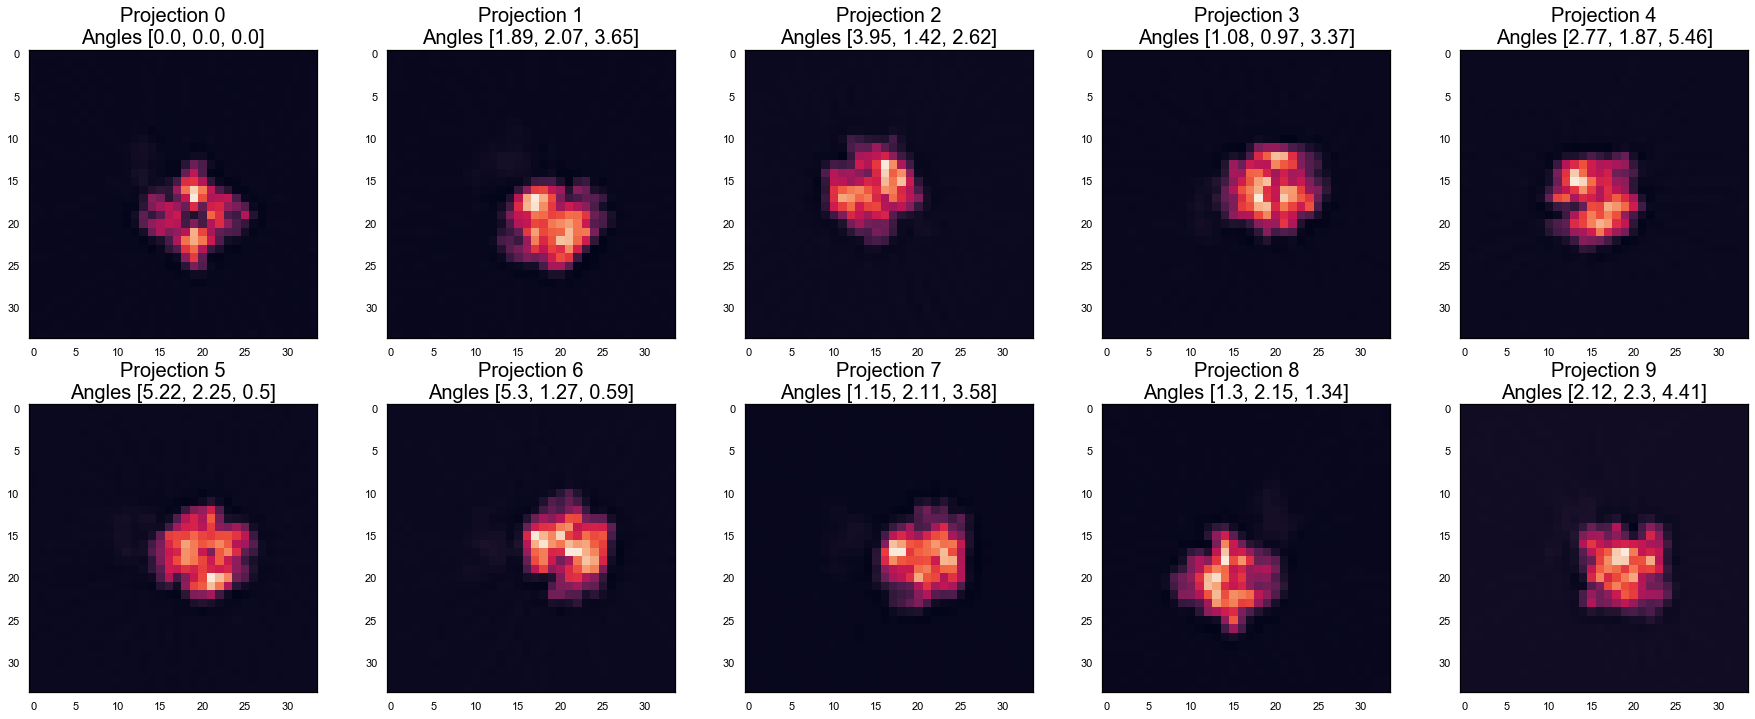

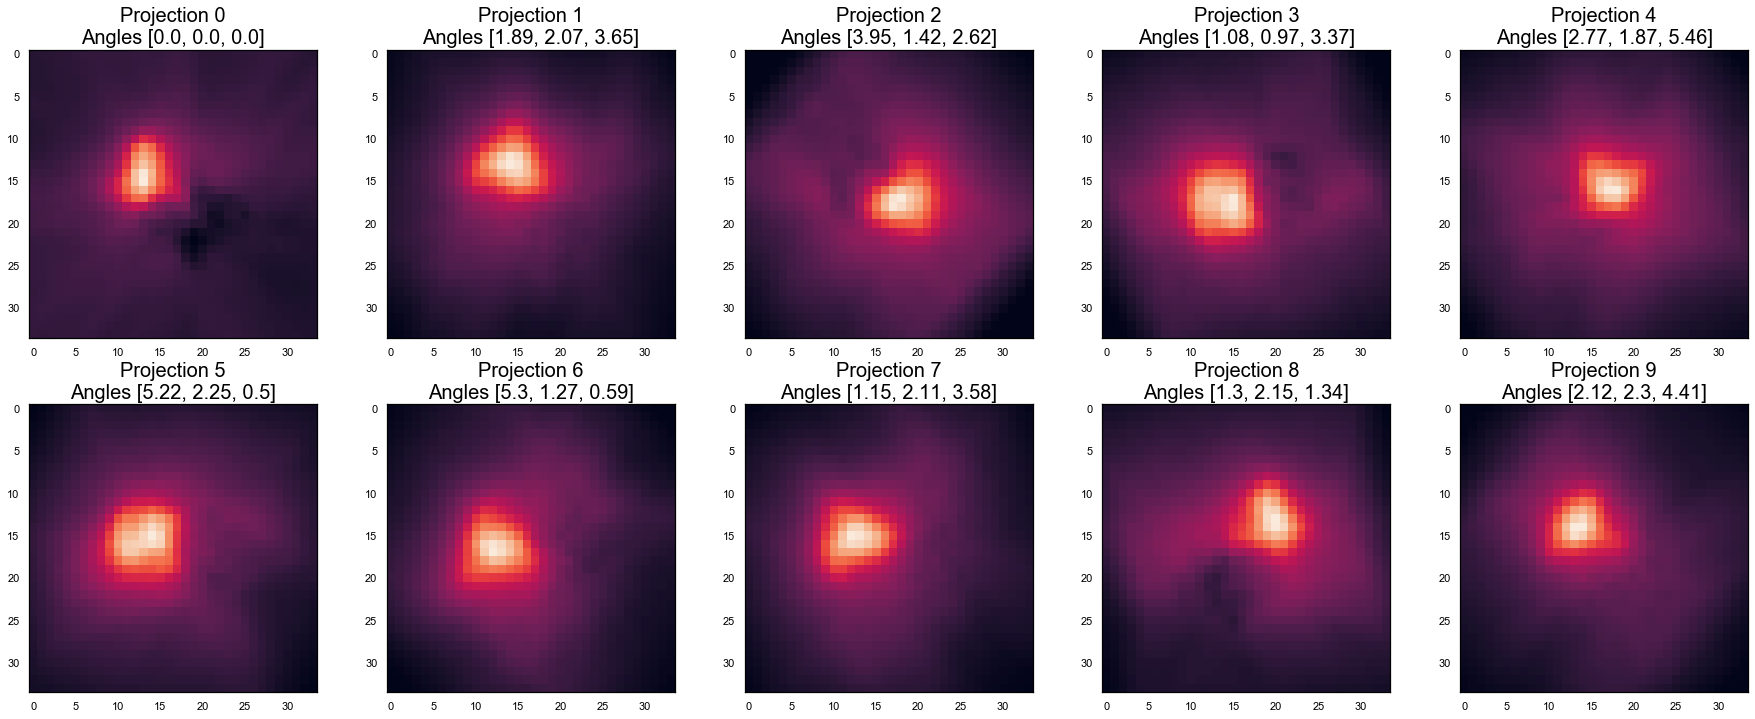

Q 17428973.066242073
delta Q 0.0
Q 17594774.92852901
delta Q 165801.8622869365
Q 17766366.287643287
delta Q 171591.3591142781
Q 17943934.28043483
delta Q 177567.99279154092
Q 18127670.230848435
delta Q 183735.95041360706
Q 18317765.37419408
delta Q 190095.14334564283
Q 18514414.53914235
delta Q 196649.16494827345
Q 18717814.94334728
delta Q 203400.40420492738
Q 18928164.006783355
delta Q 210349.06343607605
Q 19145665.48410052
delta Q 217501.47731716558
Q 19370522.905900706
delta Q 224857.421800185
The 91-th iteration


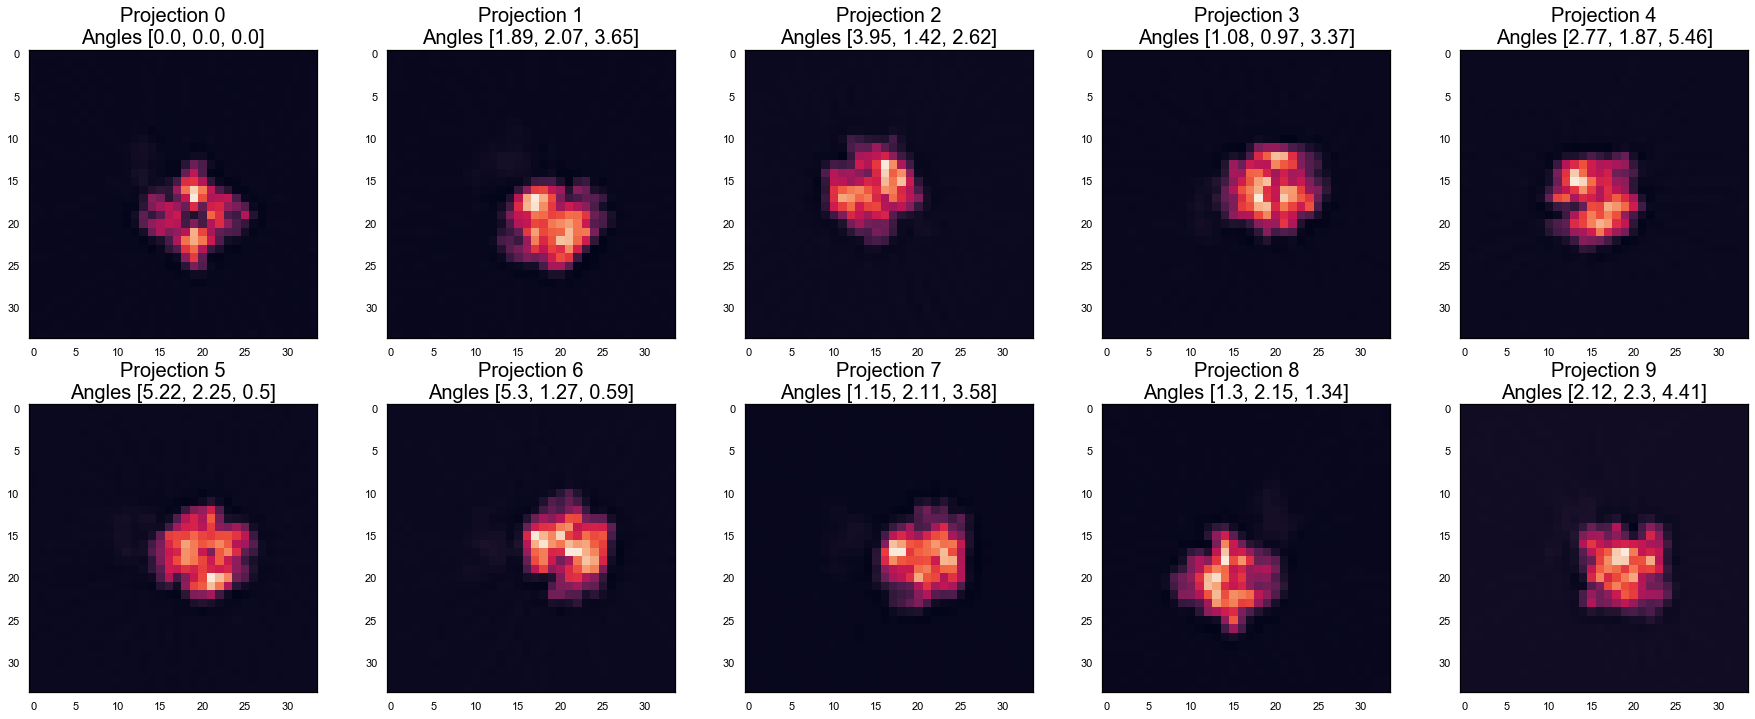

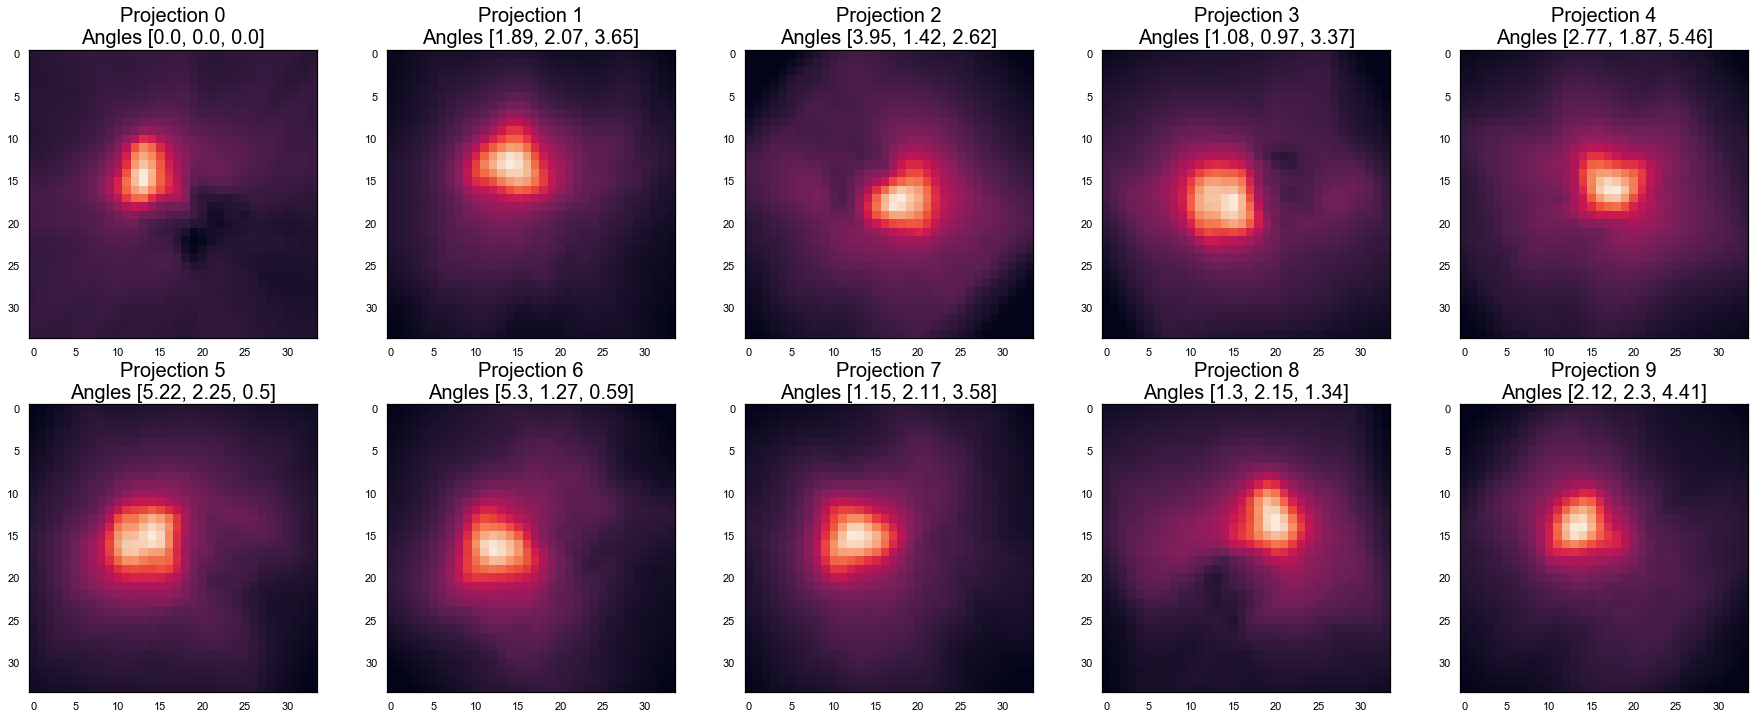

Q 19370522.905900706
delta Q 0.0
Q 19602943.787011456
delta Q 232420.88111075014
Q 19843137.66249343
delta Q 240193.87548197433
Q 20091312.010146193
delta Q 248174.34765276313
Q 20347680.554762922
delta Q 256368.54461672902
Q 20612461.27147432
delta Q 264780.7167113982
Q 20885868.172360986
delta Q 273406.90088666603
Q 21168122.131857388
delta Q 282253.95949640125
Q 21459444.567014534
delta Q 291322.4351571463
Q 21760057.193664346
delta Q 300612.62664981186
Q 22070187.87972695
delta Q 310130.6860626042
The 101-th iteration


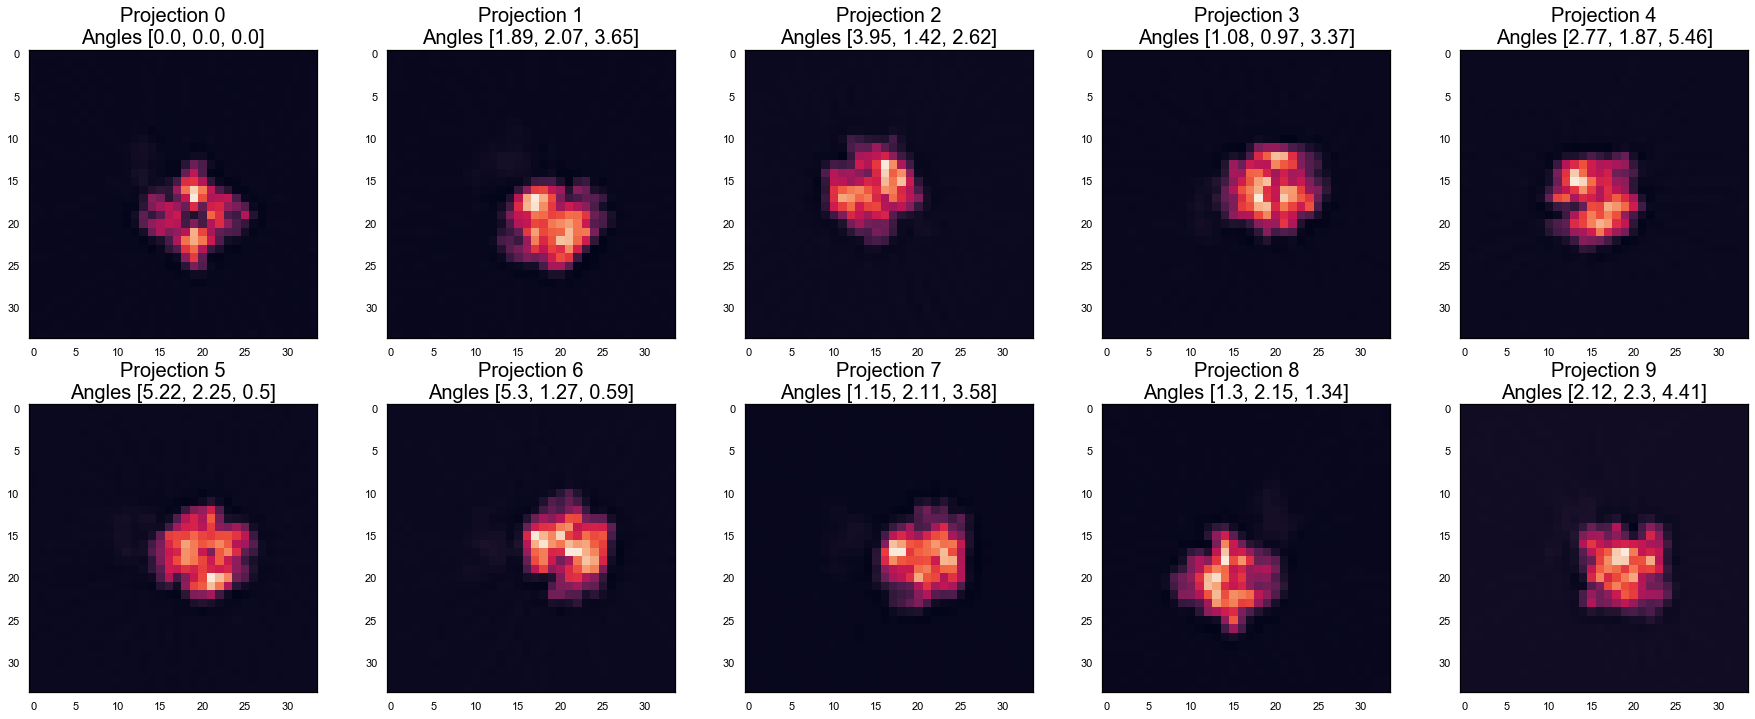

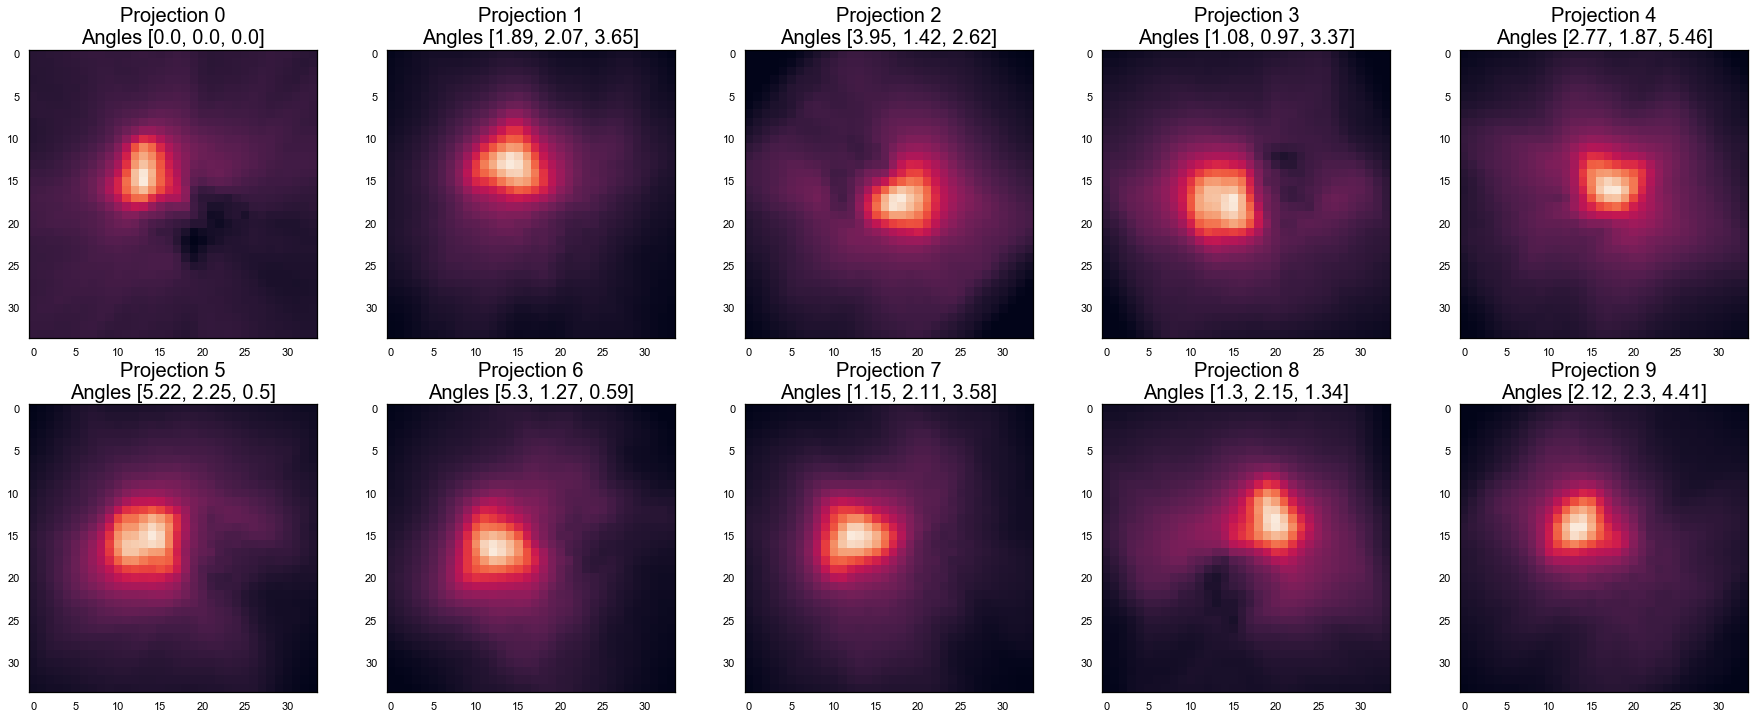

Q 22070187.87972695
delta Q 0.0
Q 22390061.307010632
delta Q 319873.42728368193
Q 22719908.89162752
delta Q 329847.5846168883
Q 23059956.324013148
delta Q 340047.4323856272
Q 23410441.74582465
delta Q 350485.4218115024
Q 23771601.489662275
delta Q 361159.7438376248
Q 24143668.59906598
delta Q 372067.1094037071
Q 24526882.759807393
delta Q 383214.16074141115
Q 24921487.825187255
delta Q 394605.06537986174
Q 25327724.410162963
delta Q 406236.5849757083
Q 25745835.747623194
delta Q 418111.33746023104
The 111-th iteration


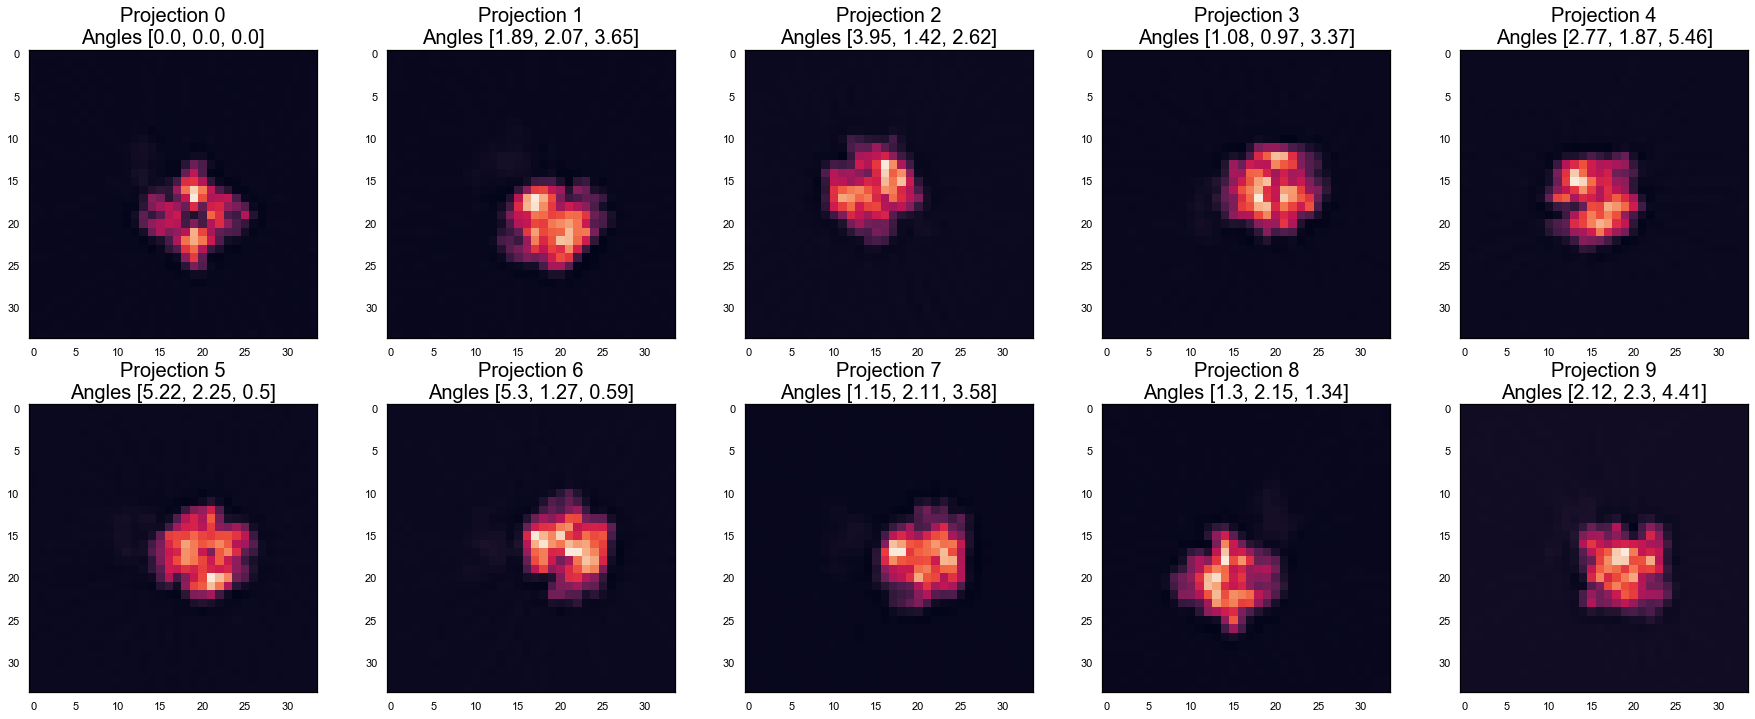

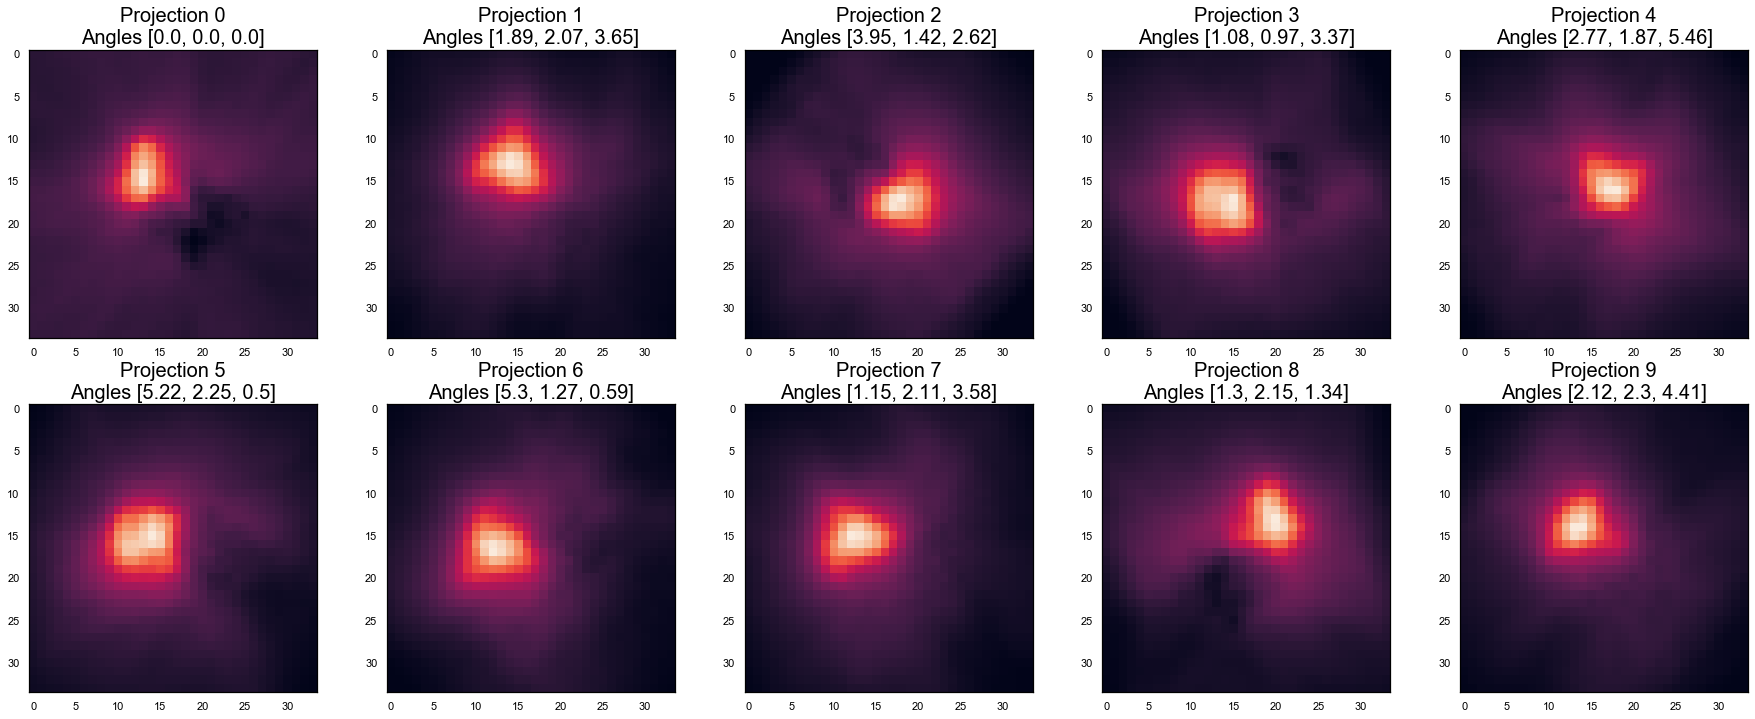

Q 25745835.747623194
delta Q 0.0
Q 26176072.851026356
delta Q 430237.1034031622
Q 26618684.700743407
delta Q 442611.8497170508
Q 27073921.920635752
delta Q 455237.21989234537
Q 27542041.99816194
delta Q 468120.0775261894
Q 28023298.53545549
delta Q 481256.5372935496
Q 28517954.662485696
delta Q 494656.127030205
Q 29026271.125858385
delta Q 508316.46337268874
Q 29548515.969848517
delta Q 522244.8439901322
Q 30084953.345078982
delta Q 536437.3752304651
Q 30635863.220733184
delta Q 550909.875654202
The 121-th iteration


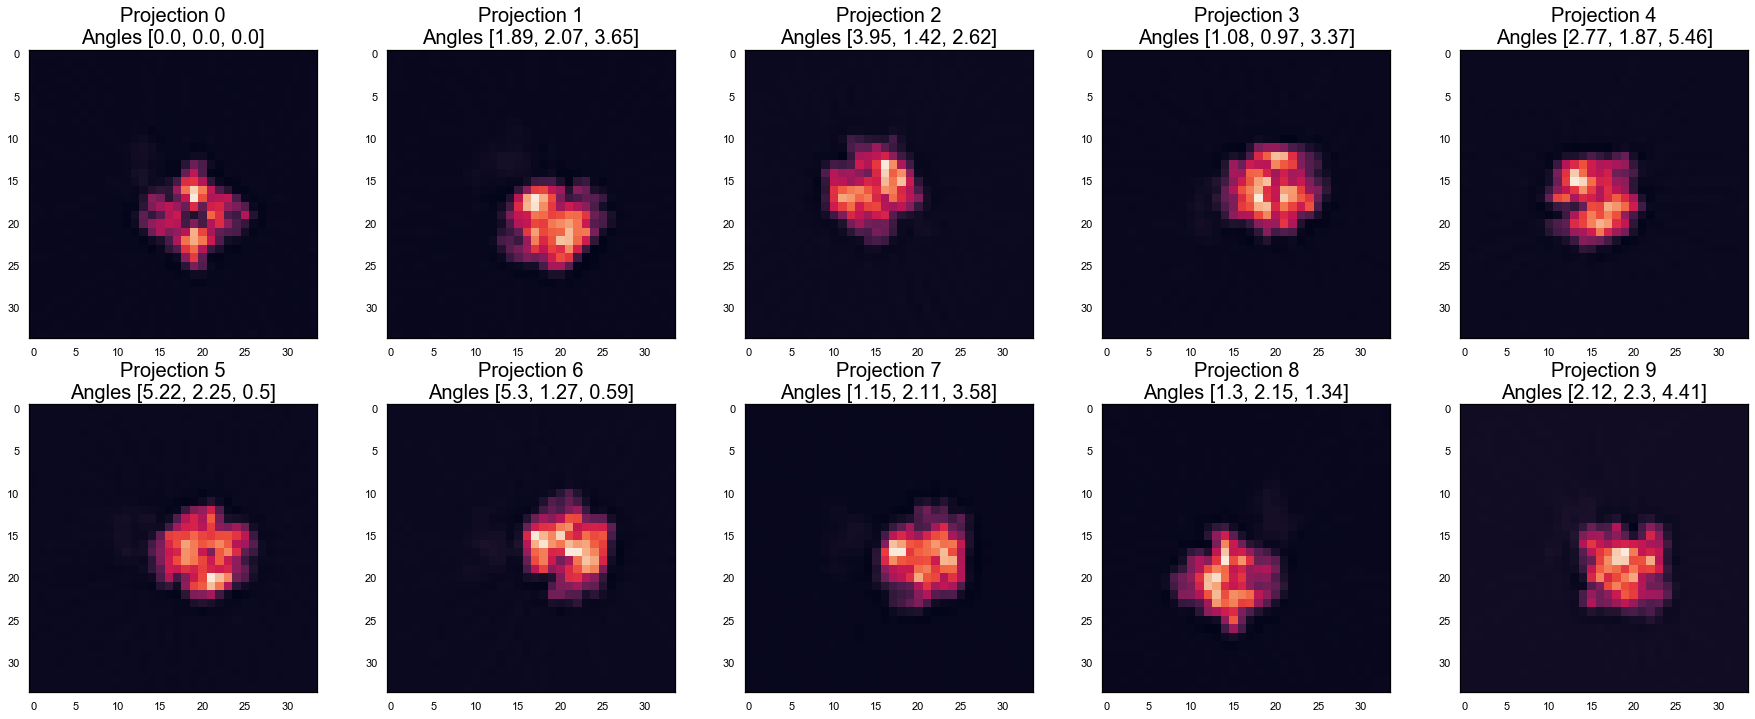

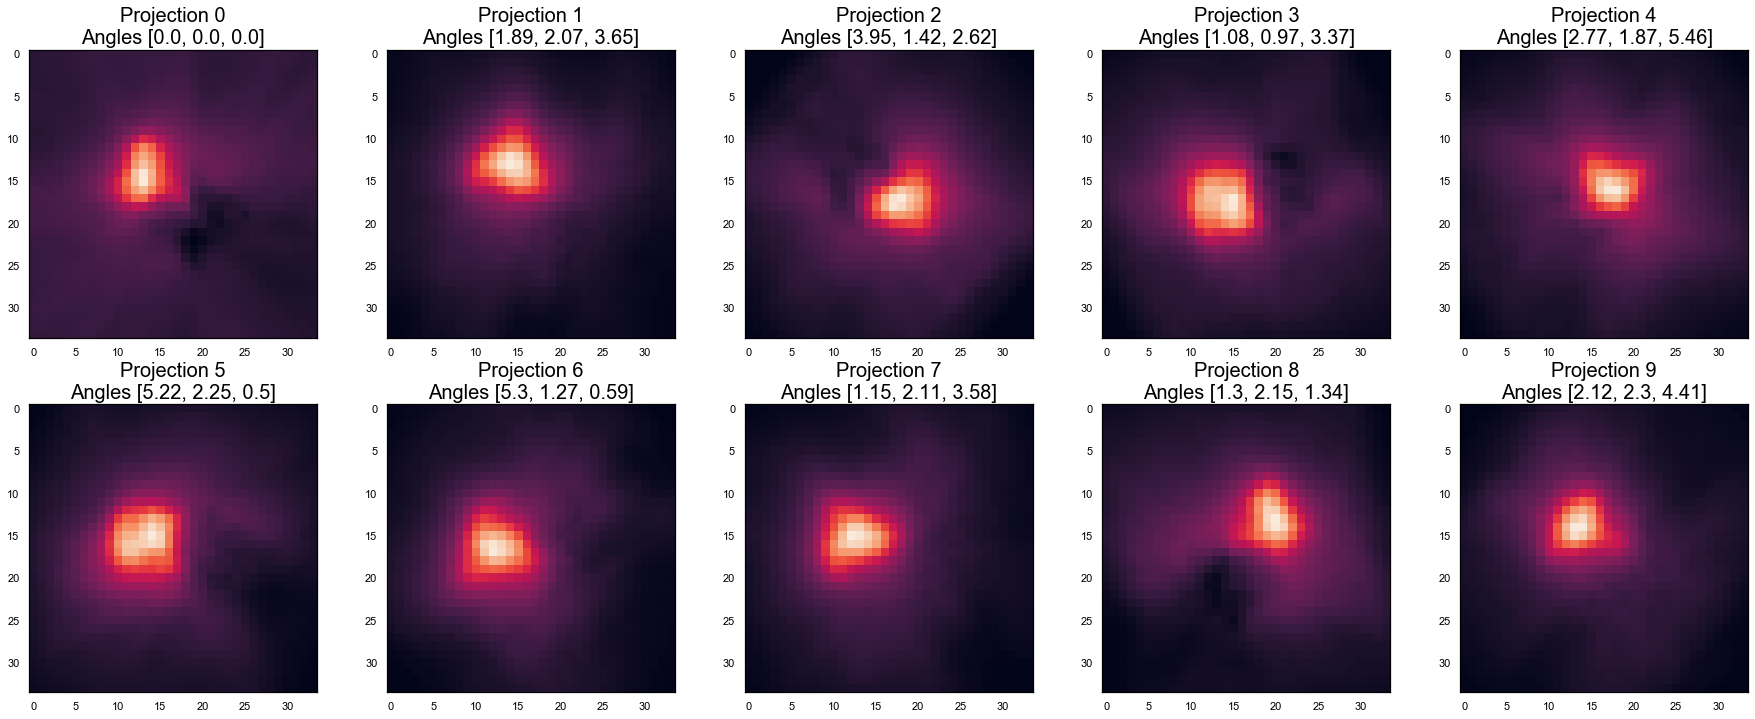

Q 30635863.220733184
delta Q 0.0
Q 31201514.710516844
delta Q 565651.4897836596
Q 31782188.729063172
delta Q 580674.018546328
Q 32378169.18277892
delta Q 595980.4537157491
Q 32989744.794901416
delta Q 611575.6121224947
Q 33617204.81413539
delta Q 627460.0192339718
Q 34260845.90808358
delta Q 643641.0939481929
Q 34920969.76538195
delta Q 660123.8572983667
Q 35597880.10419361
delta Q 676910.3388116658
Q 36291888.209775776
delta Q 694008.1055821627
Q 37003309.10439755
delta Q 711420.8946217746
The 131-th iteration


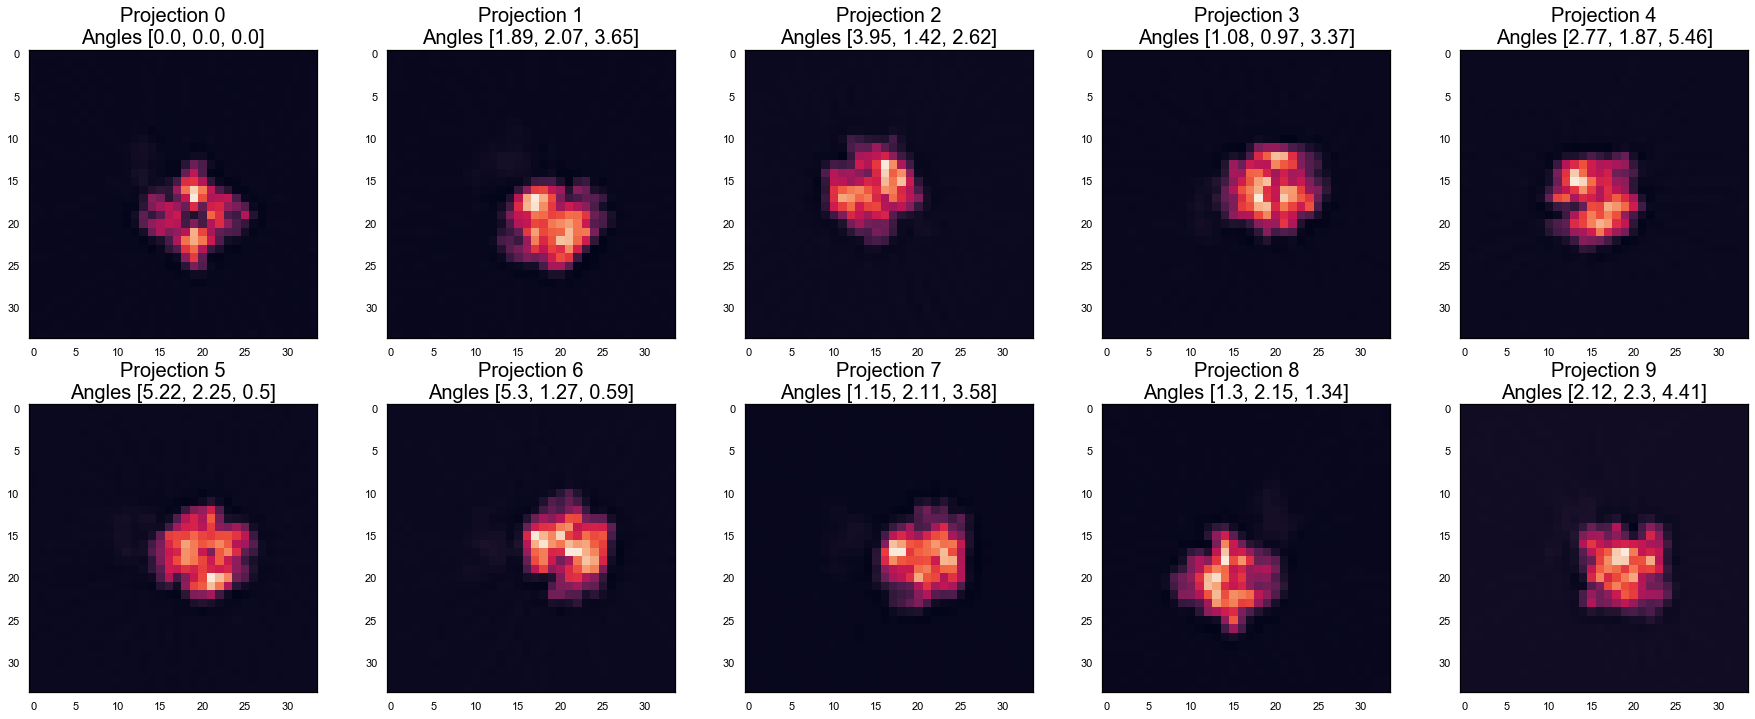

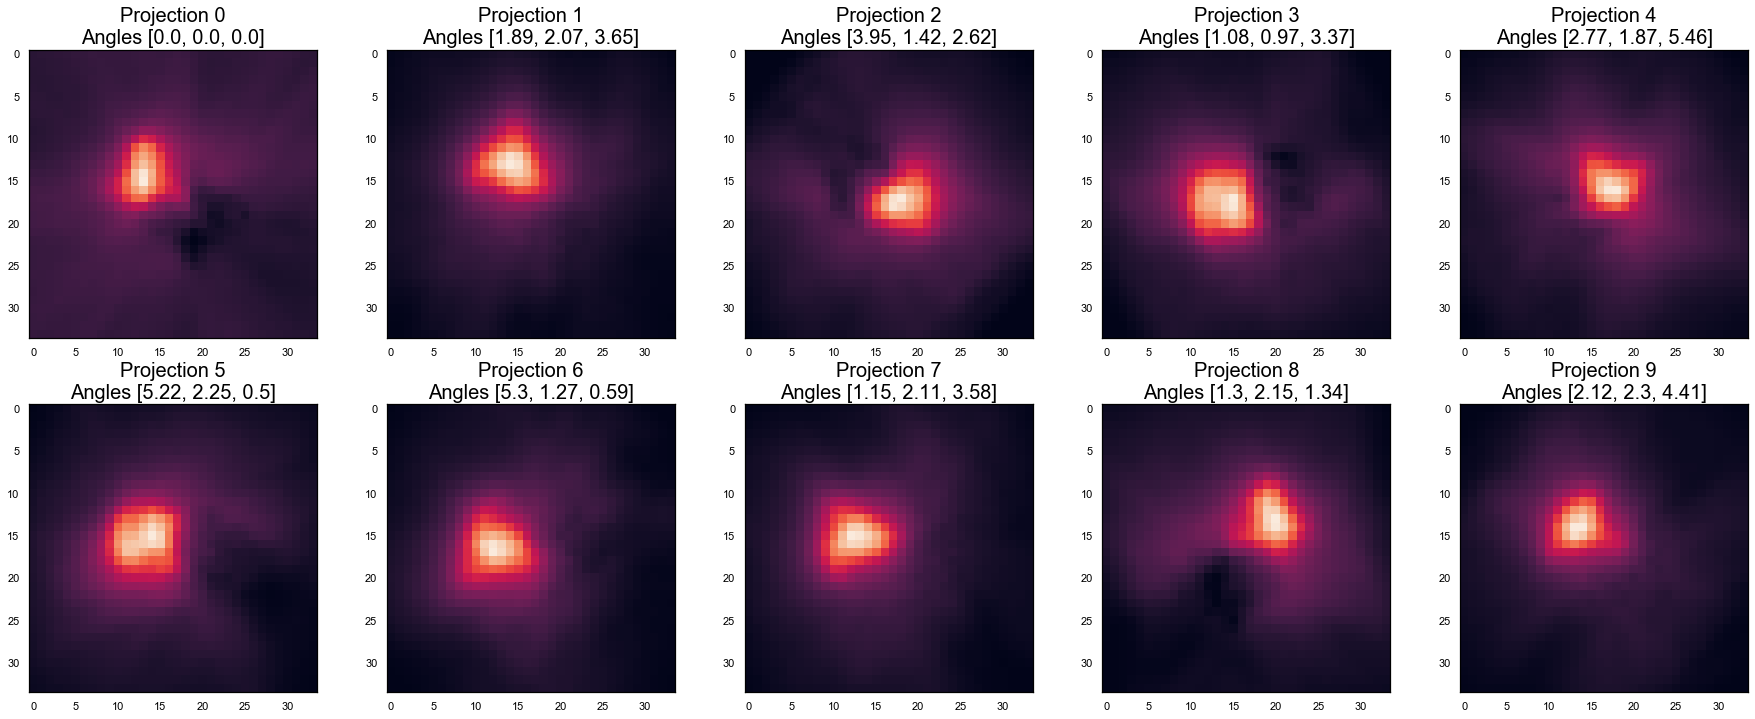

Q 37003309.10439755
delta Q 0.0
Q 37732461.67463078
delta Q 729152.5702332333
Q 38479675.27438178
delta Q 747213.5997509956
Q 39245278.18653446
delta Q 765602.9121526778
Q 40029608.829594694
delta Q 784330.6430602372
Q 40833009.77449288
delta Q 803400.9448981881
Q 41655828.51292749
delta Q 822818.7384346053
Q 42498422.916421585
delta Q 842594.4034940973
Q 43361148.23926634
delta Q 862725.3228447586
Q 44244377.518097766
delta Q 883229.2788314223
Q 45148475.84965394
delta Q 904098.3315561712
The 141-th iteration


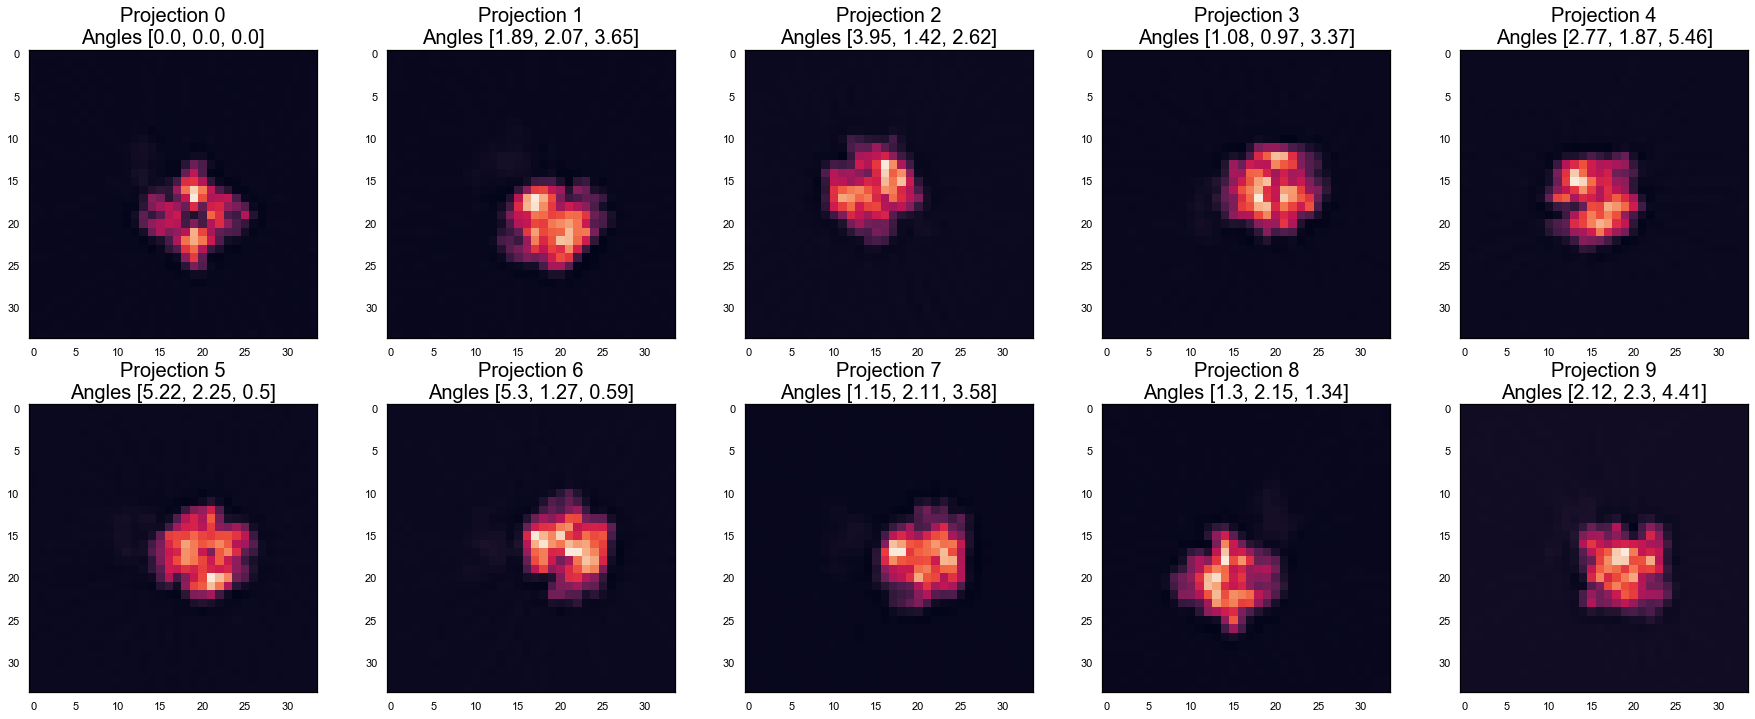

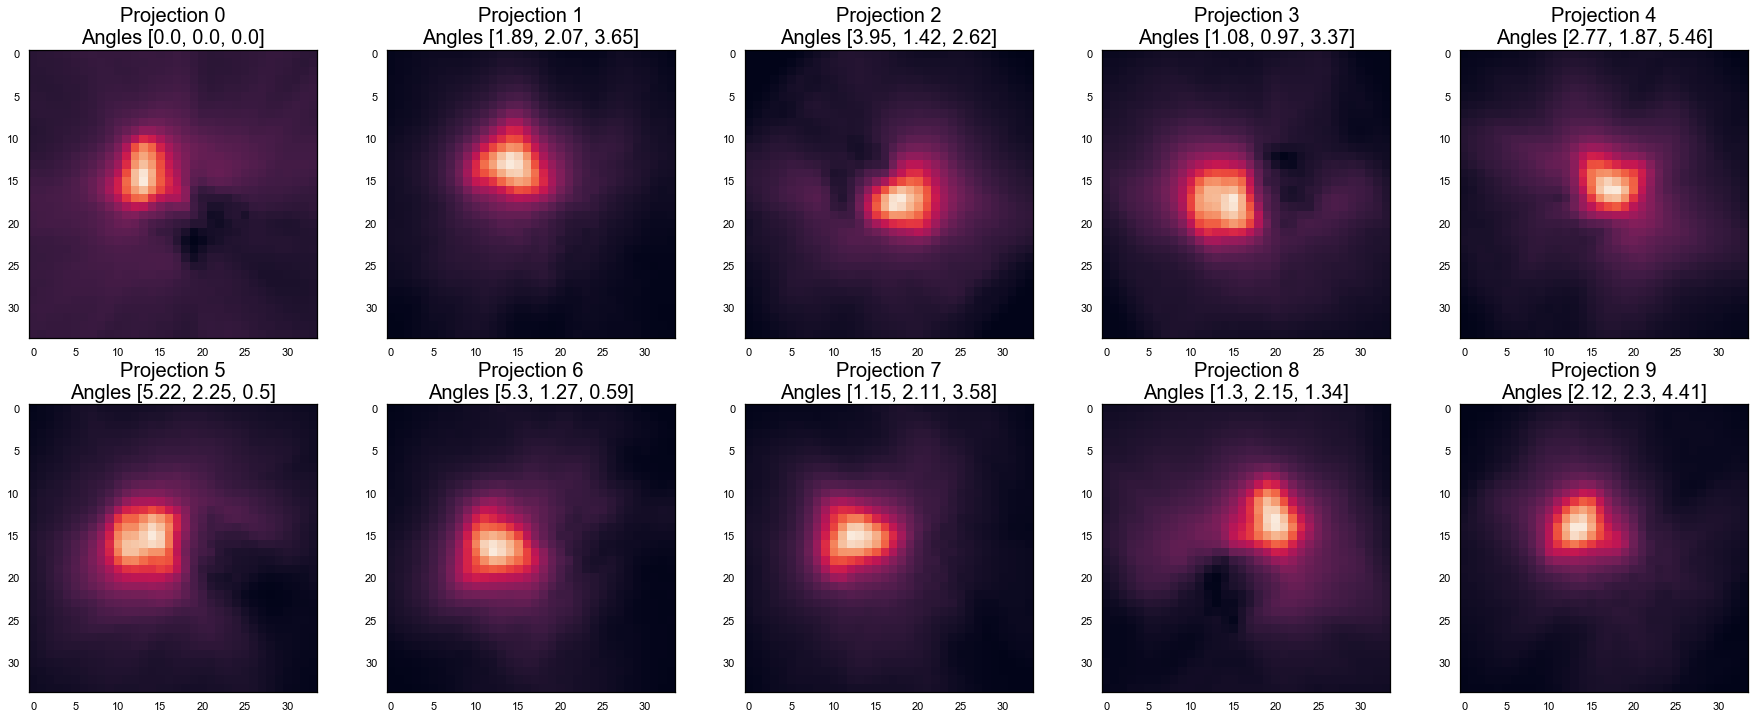

Q 45148475.84965394
delta Q 0.0
Q 46073823.57043001
delta Q 925347.7207760736
Q 47020809.45439608
delta Q 946985.883966066
Q 47989816.69315537
delta Q 969007.2387592942
Q 48981244.6234135
delta Q 991427.9302581325
Q 49995495.02961801
delta Q 1014250.4062045068
Q 51032973.13561099
delta Q 1037478.1059929803
Q 52094091.70448192
delta Q 1061118.5688709319
Q 53179272.91214901
delta Q 1085181.20766709
Q 54288937.63576709
delta Q 1109664.7236180753
Q 55423517.875144154
delta Q 1134580.2393770665
The 151-th iteration


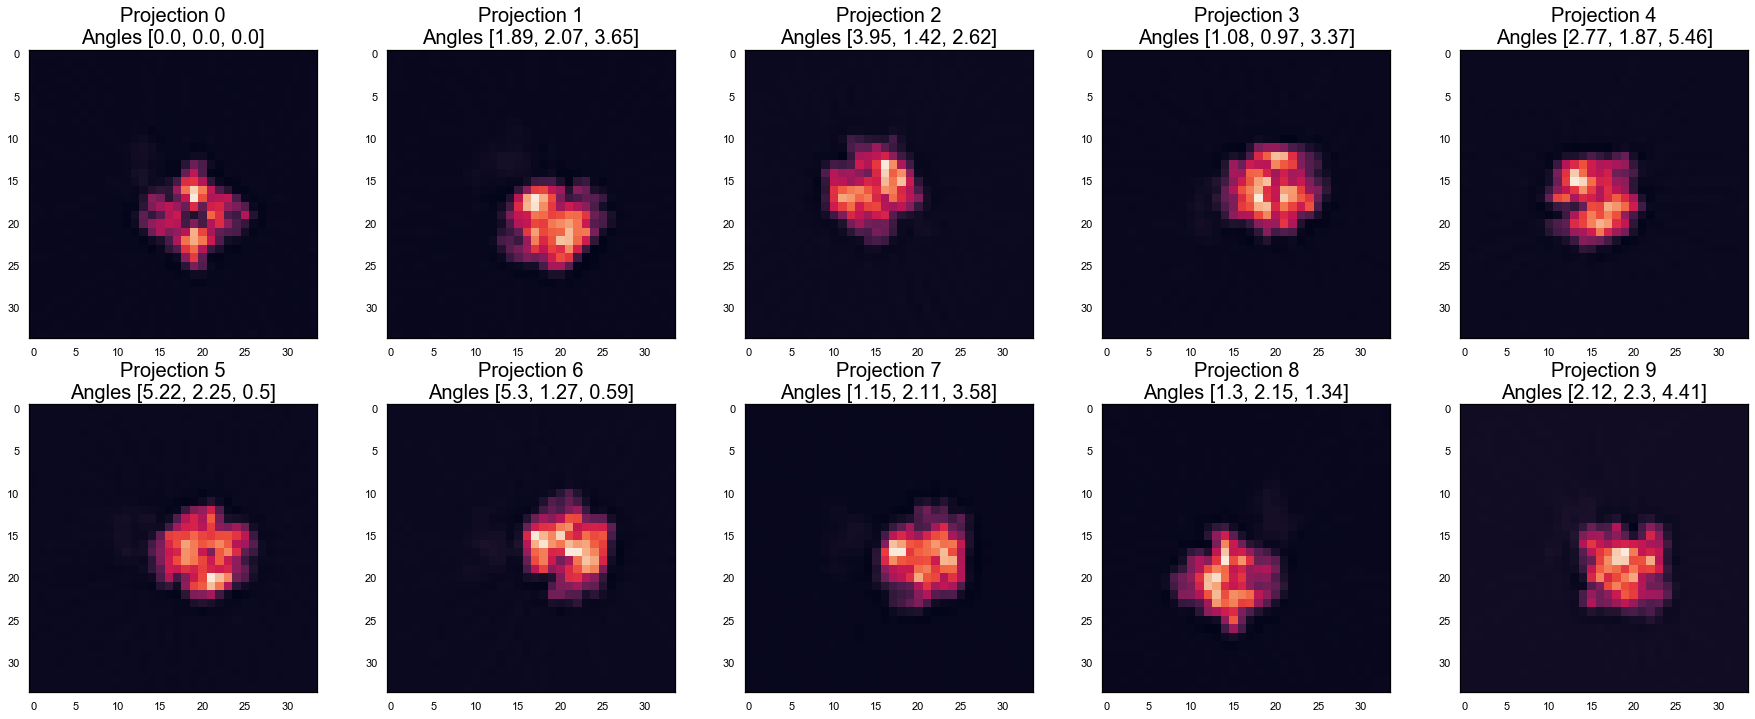

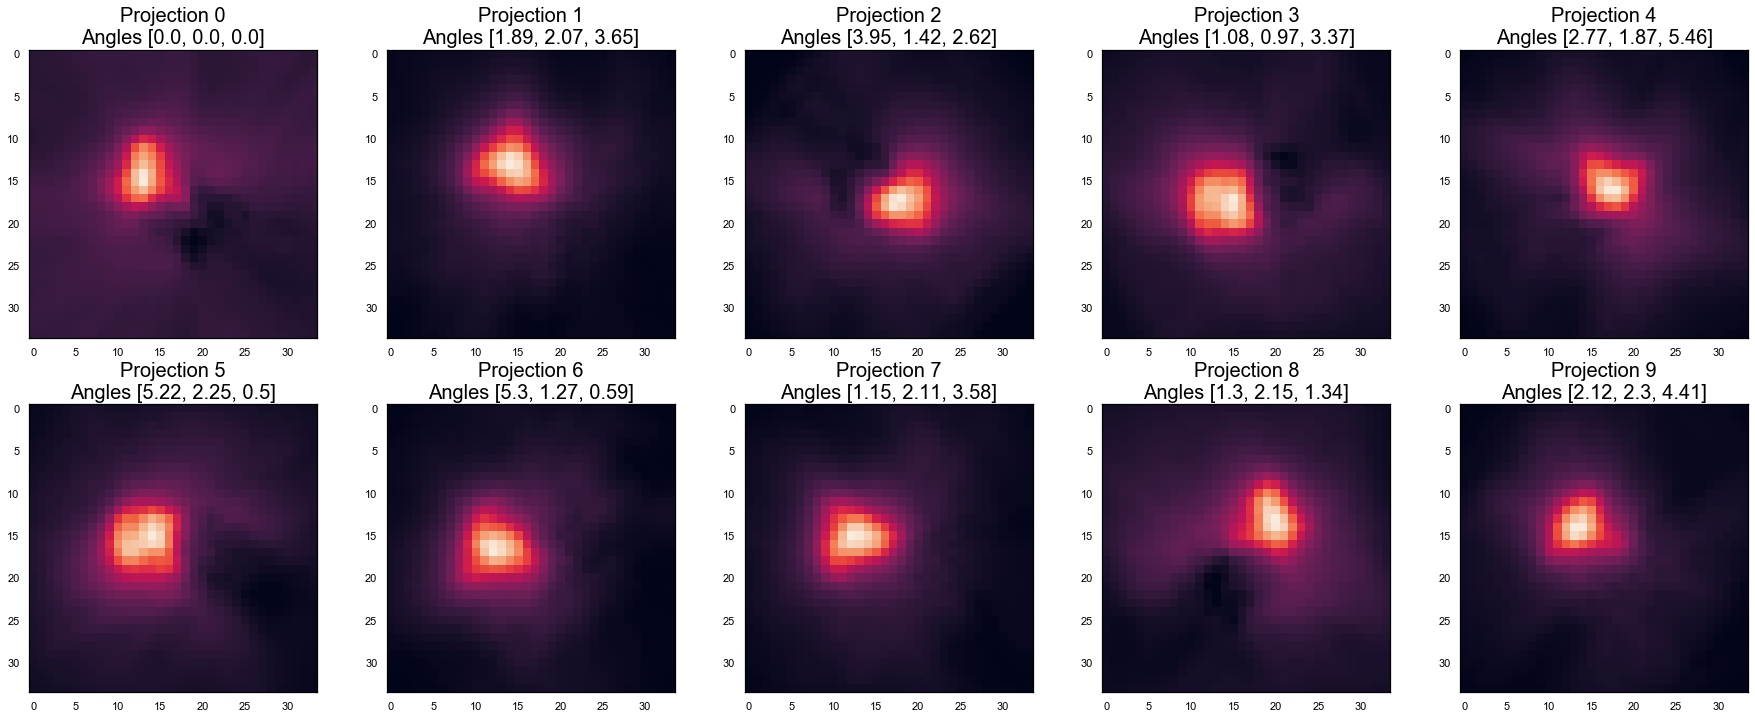

Q 55423517.875144154
delta Q 0.0
Q 56583454.23861869
delta Q 1159936.363474533
Q 57769186.4178442
delta Q 1185732.1792255118
Q 58981162.51063933
delta Q 1211976.0927951336
Q 60219841.3691822
delta Q 1238678.858542867
Q 61485693.363288395
delta Q 1265851.9941061959
Q 62779188.12585854
delta Q 1293494.7625701427
Q 64100812.46418765
delta Q 1321624.338329114
Q 65451059.44440854
delta Q 1350246.9802208915
Q 66830432.67865241
delta Q 1379373.2342438698


In [40]:
_, num_image , n_component = 116, 5000 , 2
print(P3R.mu.shape)
print(ProjSize1)
Mus = P3R.mu.reshape(1, ProjSize1, ProjSize1, ProjSize1)
P3RM = PCA_3d_Recon_recurssive(ProjSize1, num_image, n_component,Mus )
P3RM.Au_s(angles2)
print(P3RM.Aus.shape)
#P3RM.Plot_mu_by_projection(angles2)
#P3RM.Expectation(new_projection , angles2)
#P3RM.Maximization(new_projection , angles2)
P3RM.fit(new_projection , angles2)

start fitting
The 0-th iteration
Q 66830432.67865241
delta Q 0.0


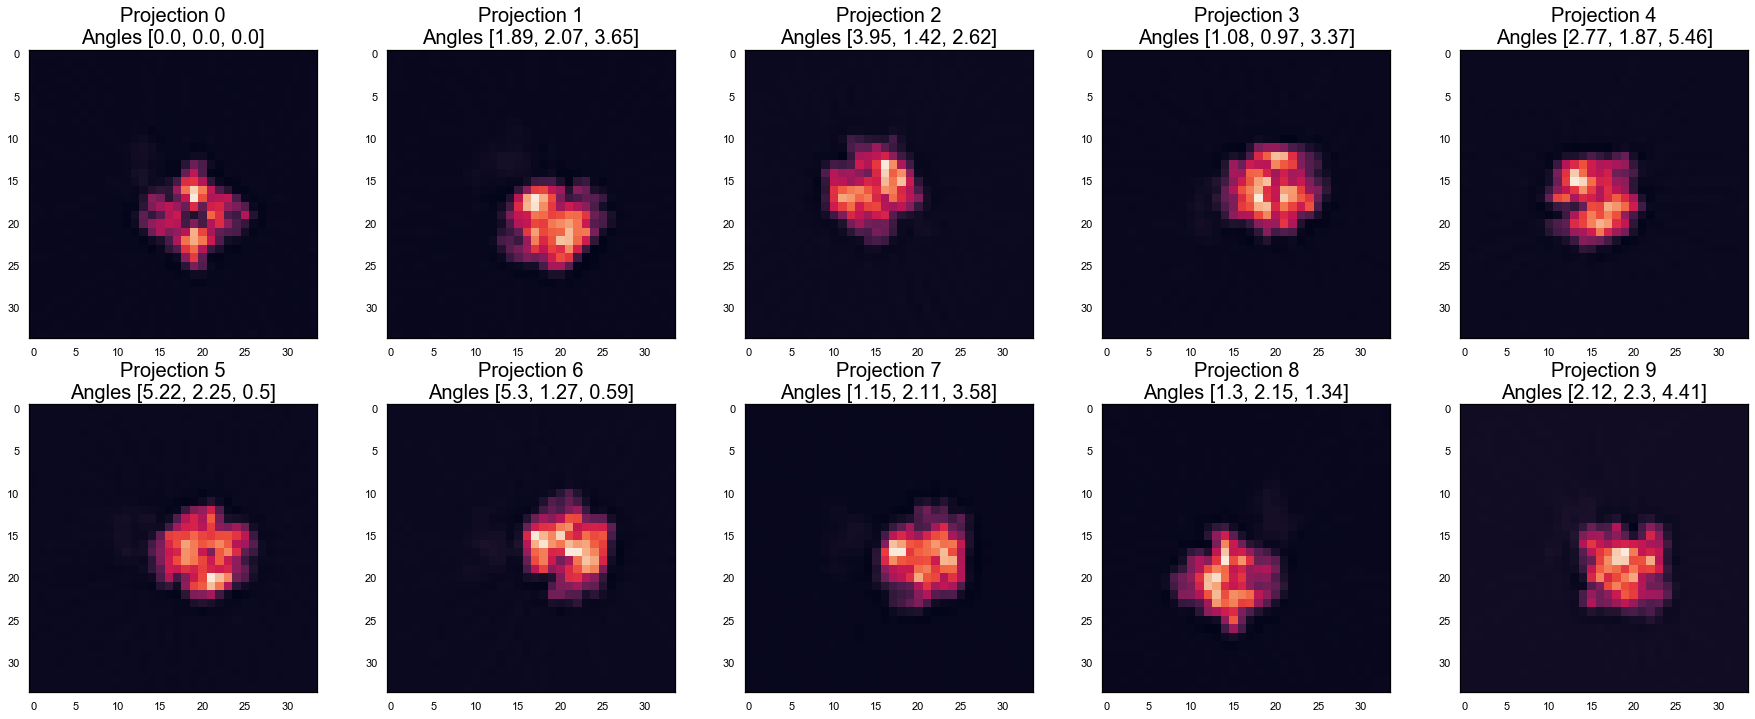

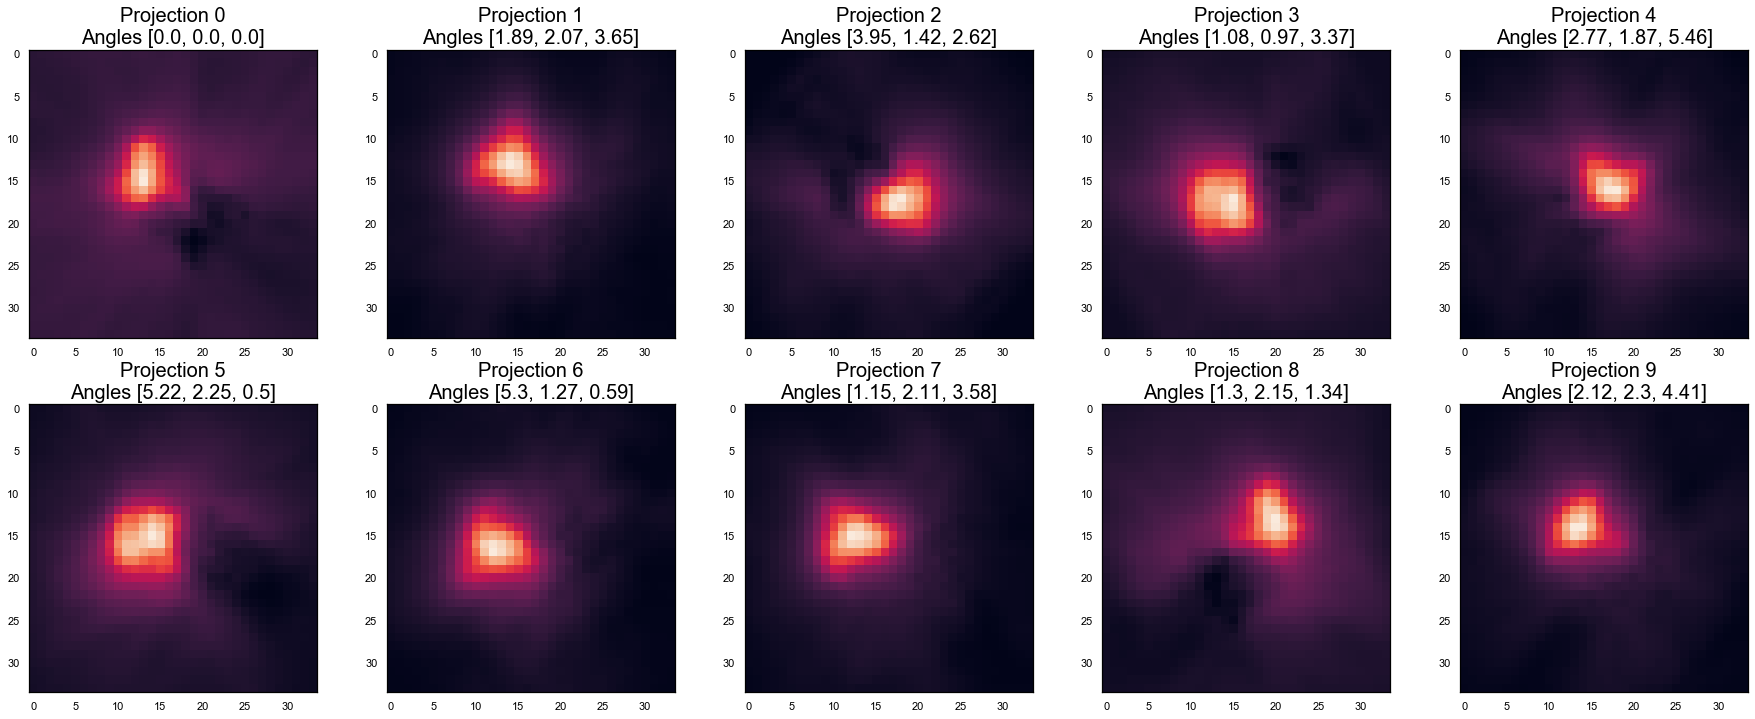

Q 68239455.95899473
delta Q 1409023.2803423181
The 1-th iteration


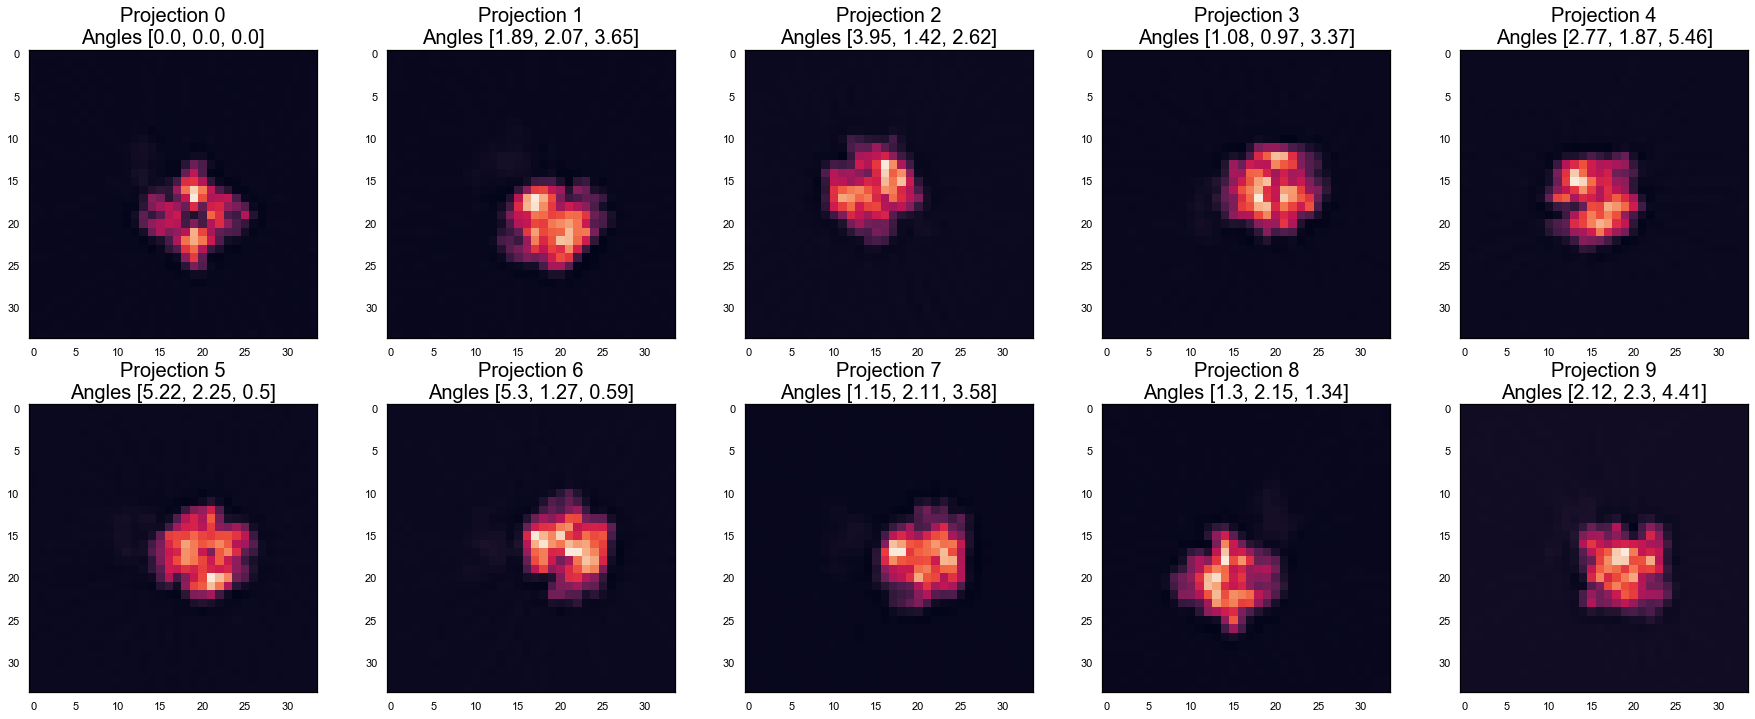

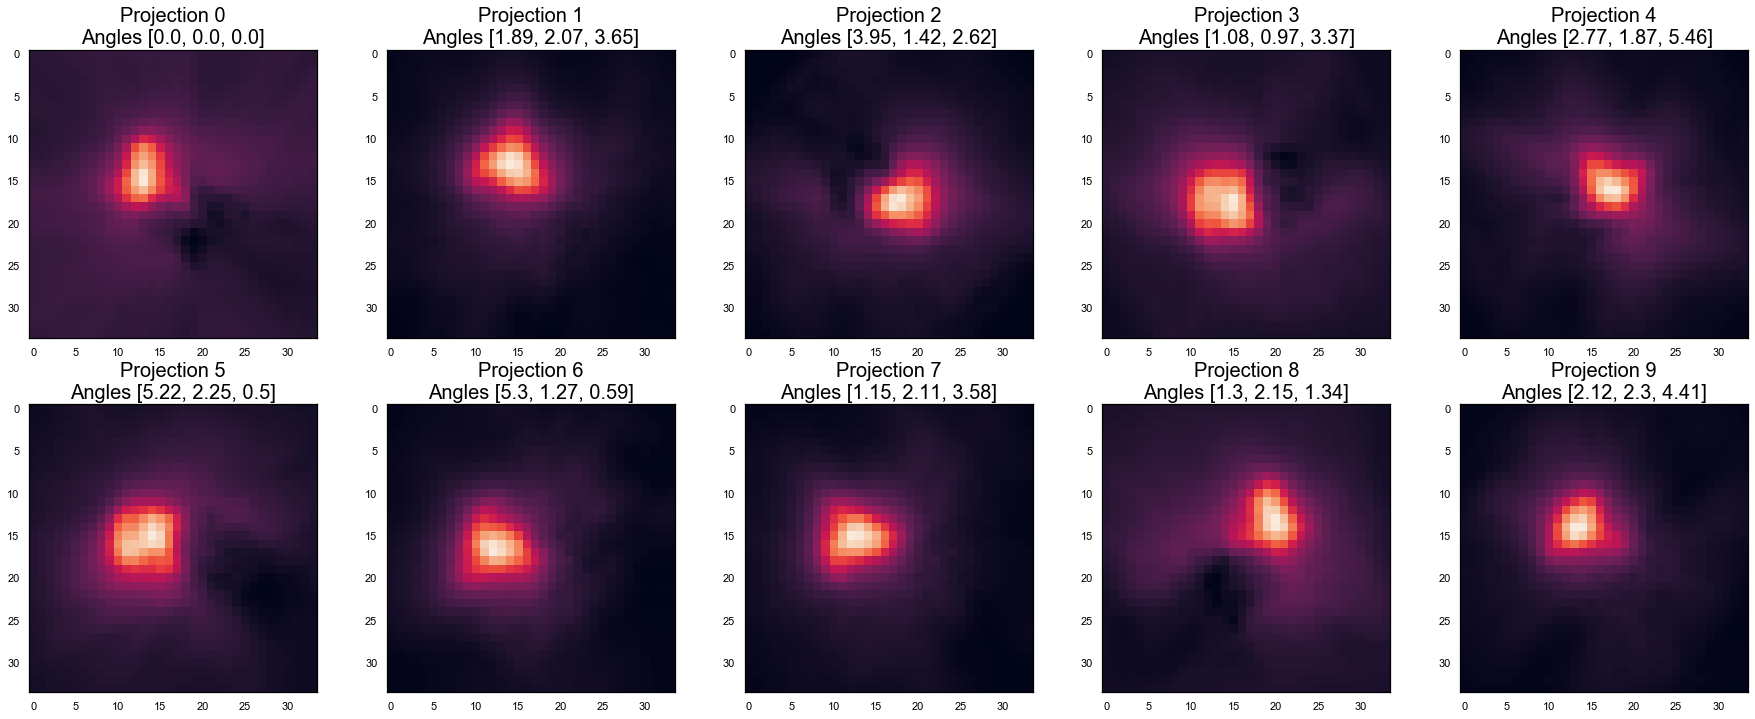

Q 68239455.95899473
delta Q 0.0
Q 69678671.05333605
delta Q 1439215.0943413228
Q 71148631.57036866
delta Q 1469960.5170326084
Q 72649914.22580083
delta Q 1501282.6554321647
Q 74183126.37764685
delta Q 1533212.1518460214
Q 75748900.21749714
delta Q 1565773.8398502916
Q 77347903.16850519
delta Q 1599002.9510080516
Q 78980841.46669905
delta Q 1632938.298193857
Q 80648469.76170279
delta Q 1667628.295003742
Q 82351601.7174372
delta Q 1703131.955734402
Q 84091101.50826034
delta Q 1739499.7908231467
The 11-th iteration


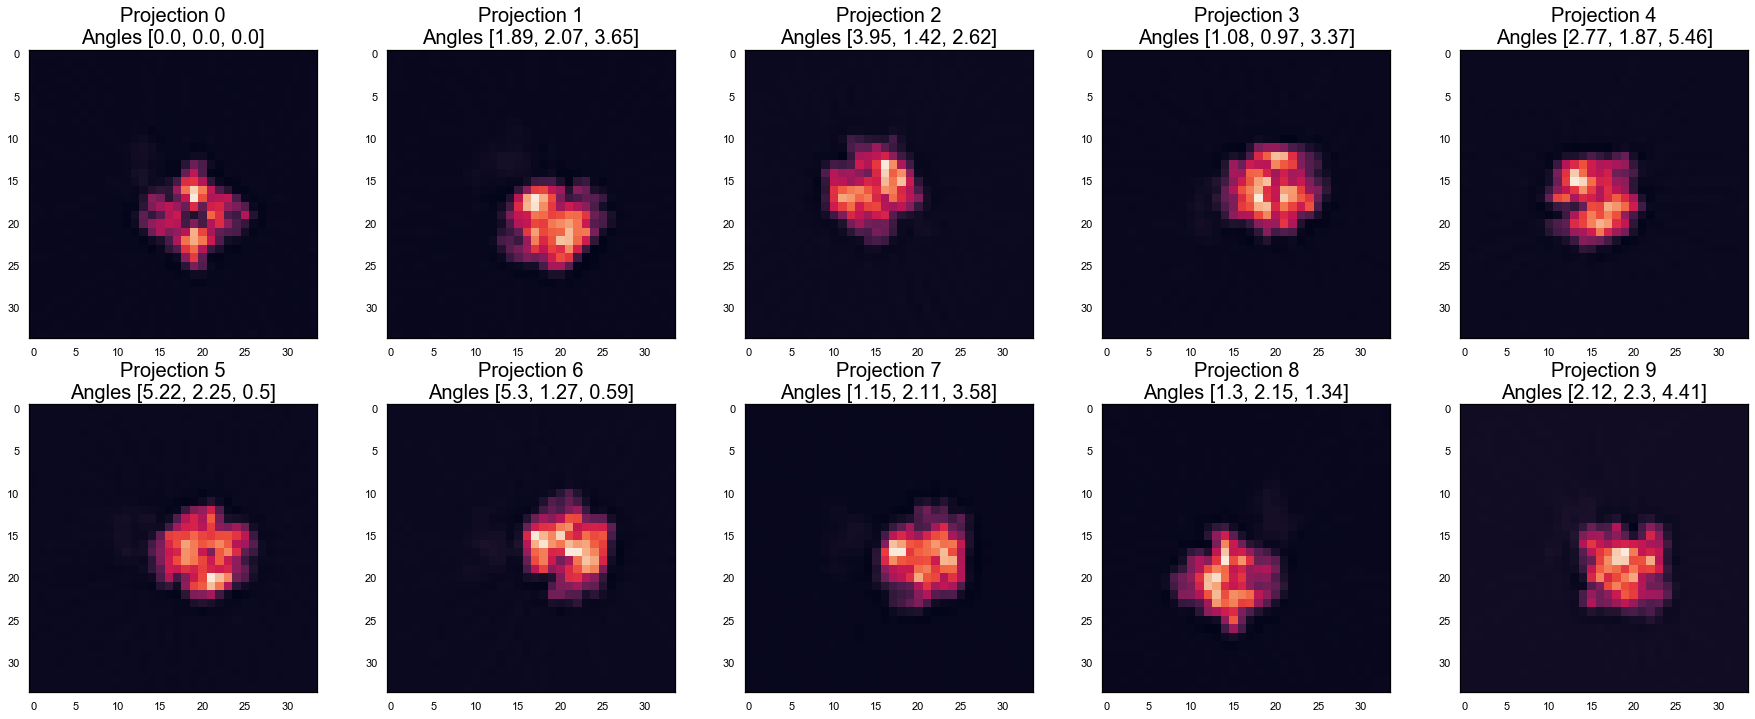

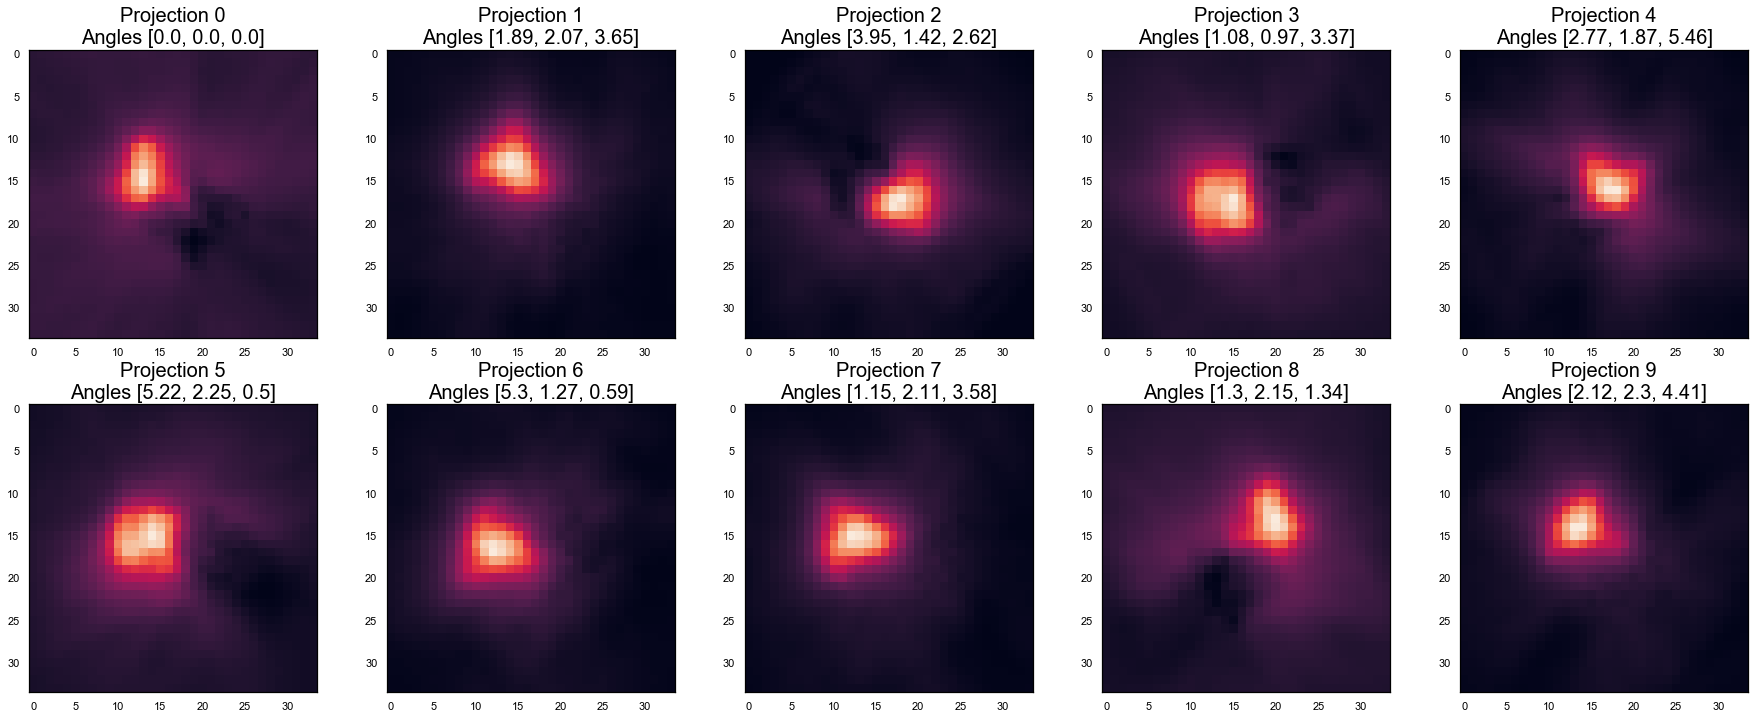

Q 84091101.50826034
delta Q 0.0
Q 85867910.40924005
delta Q 1776808.9009797126
Q 87683054.63049212
delta Q 1815144.2212520689
Q 89537659.67787385
delta Q 1854605.047381729
Q 91432950.50782582
delta Q 1895290.8299519718
Q 93370293.34928173
delta Q 1937342.8414559066
Q 95351191.78688377
delta Q 1980898.4376020432
Q 97377313.89397448
delta Q 2026122.1070907116
Q 99450519.94401027
delta Q 2073206.0500357896
Q 101572895.0160331
delta Q 2122375.0720228255
Q 103746761.54978466
delta Q 2173866.5337515622
The 21-th iteration


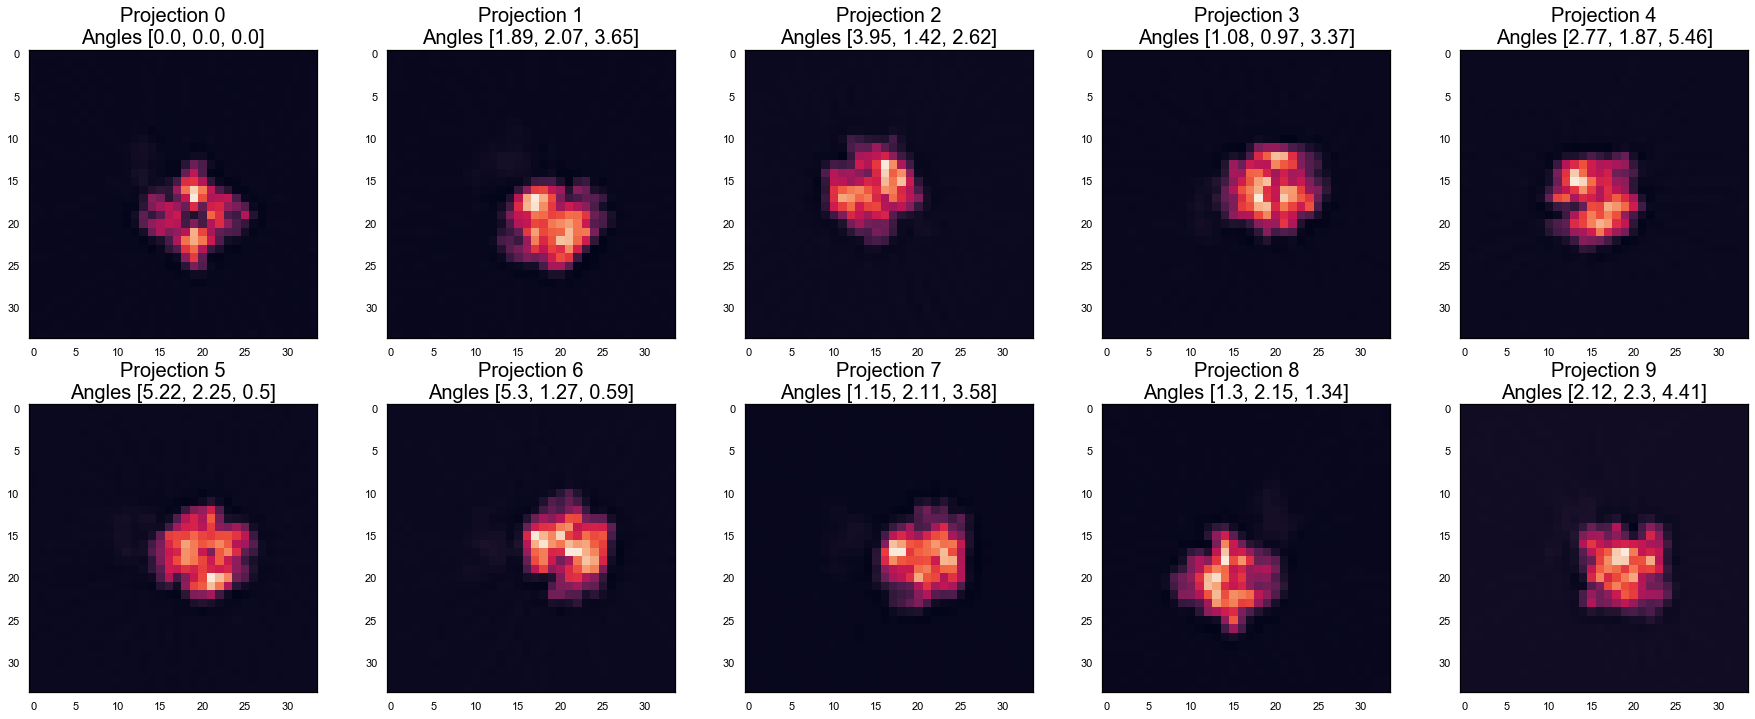

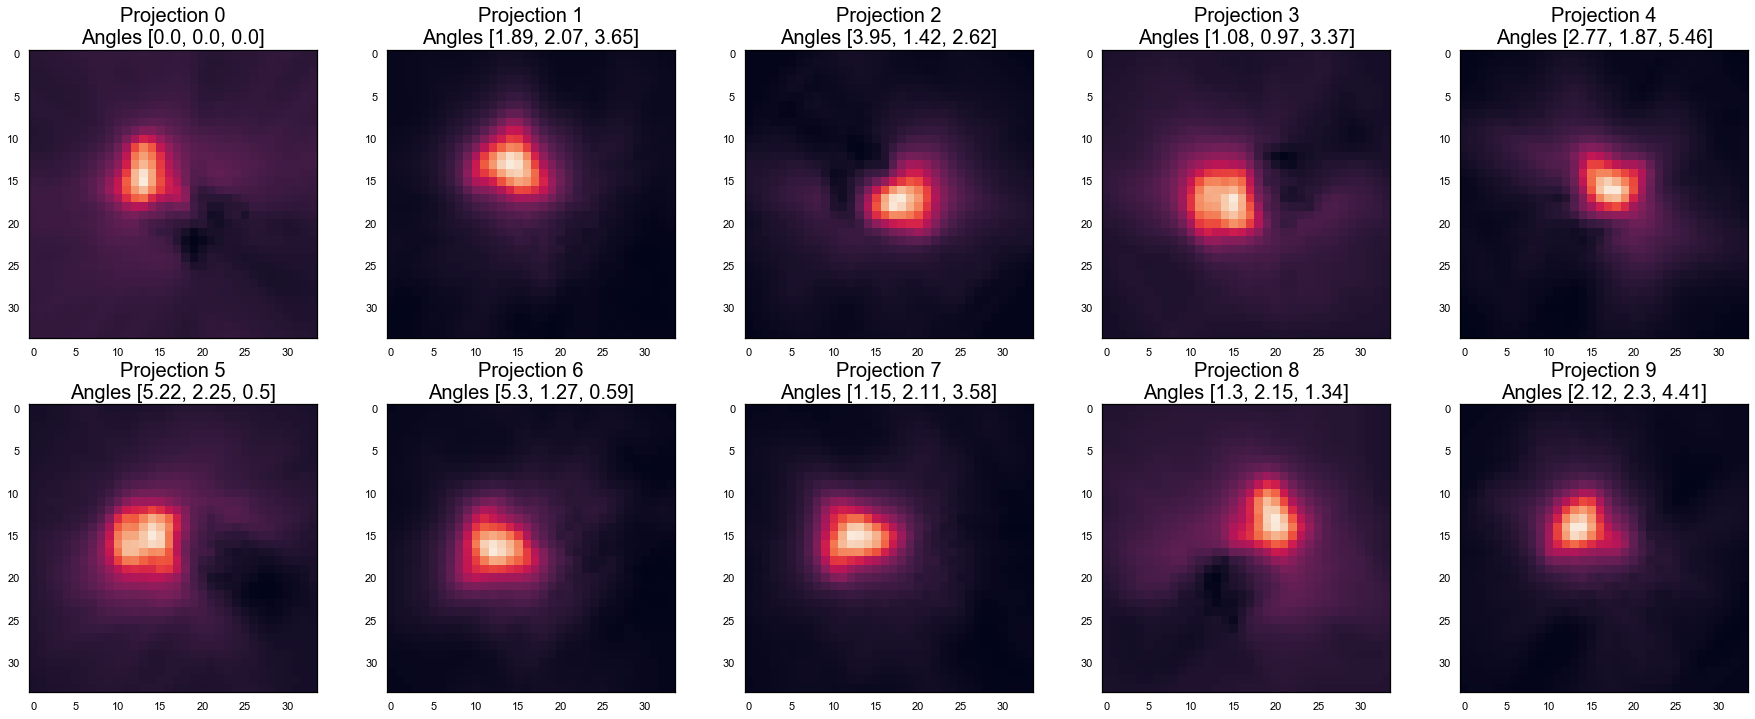

Q 103746761.54978466
delta Q 0.0
Q 105974731.01441033
delta Q 2227969.4646256715
Q 108259729.571411
delta Q 2284998.557000667
Q 110605039.01960133
delta Q 2345309.4481903315
Q 113014343.55715707
delta Q 2409304.5375557393
Q 115491782.41502179
delta Q 2477438.8578647226
Q 118041990.5217187
delta Q 2550208.1066969037
Q 120670161.86546224
delta Q 2628171.343743548
Q 123382089.2861049
delta Q 2711927.420642659
Q 126184240.36465502
delta Q 2802151.078550115
Q 129083785.57223332
delta Q 2899545.2075783014
The 31-th iteration


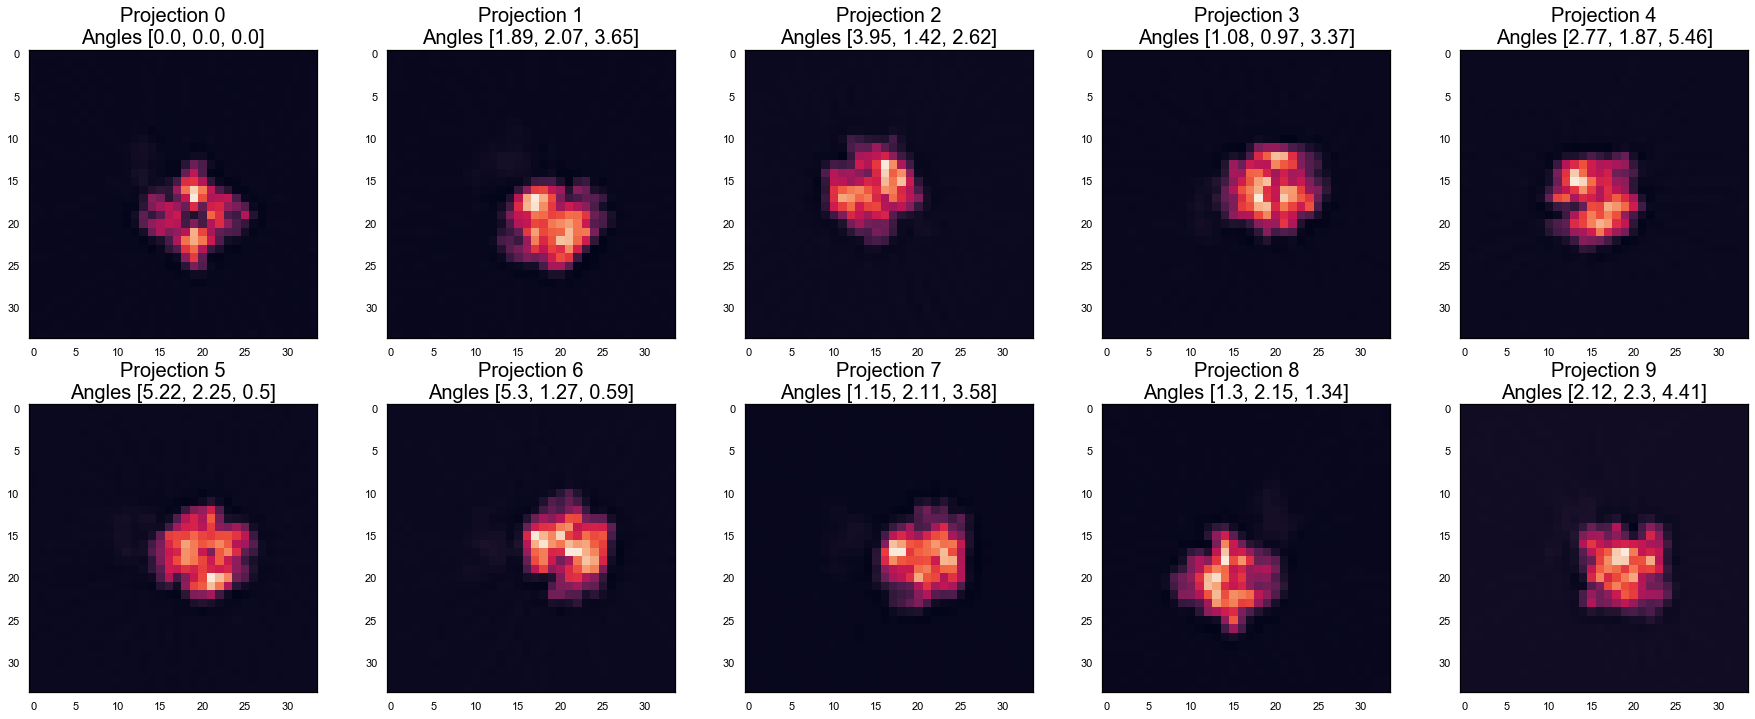

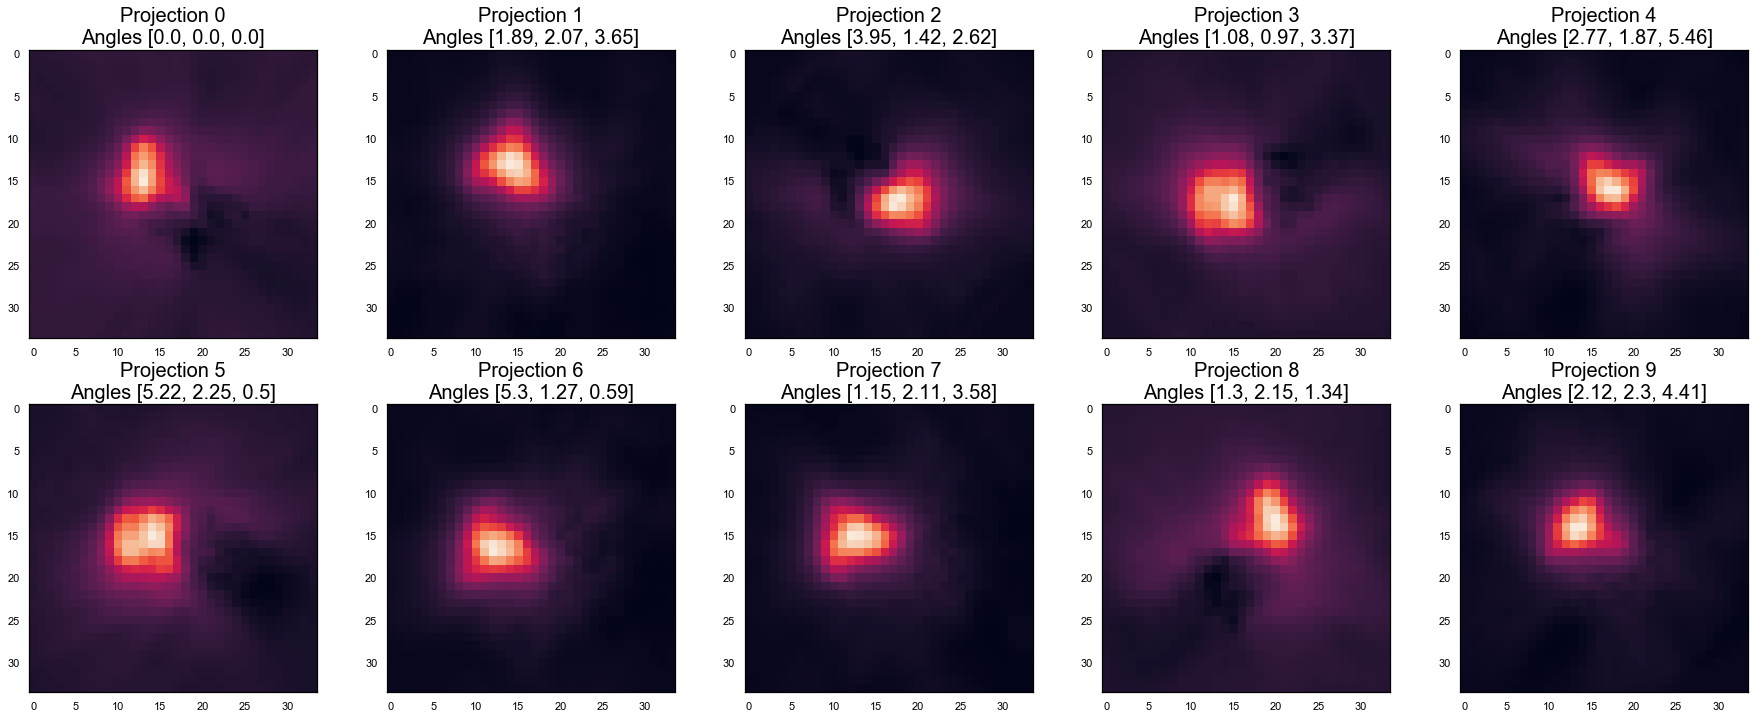

Q 129083785.57223332
delta Q 0.0
Q 132088642.38318007
delta Q 3004856.8109467477
Q 135207515.8120038
delta Q 3118873.4288237244
Q 138449876.4518861
delta Q 3242360.6398822963
Q 141825970.85973552
delta Q 3376094.407849431
Q 145346735.68592197
delta Q 3520764.8261864483
Q 149023686.61003232
delta Q 3676950.924110353
Q 152868751.79334134
delta Q 3845065.1833090186
Q 156894005.90153676
delta Q 4025254.108195424
Q 161111340.86223528
delta Q 4217334.960698515
Q 165532081.42869422
delta Q 4420740.5664589405
The 41-th iteration


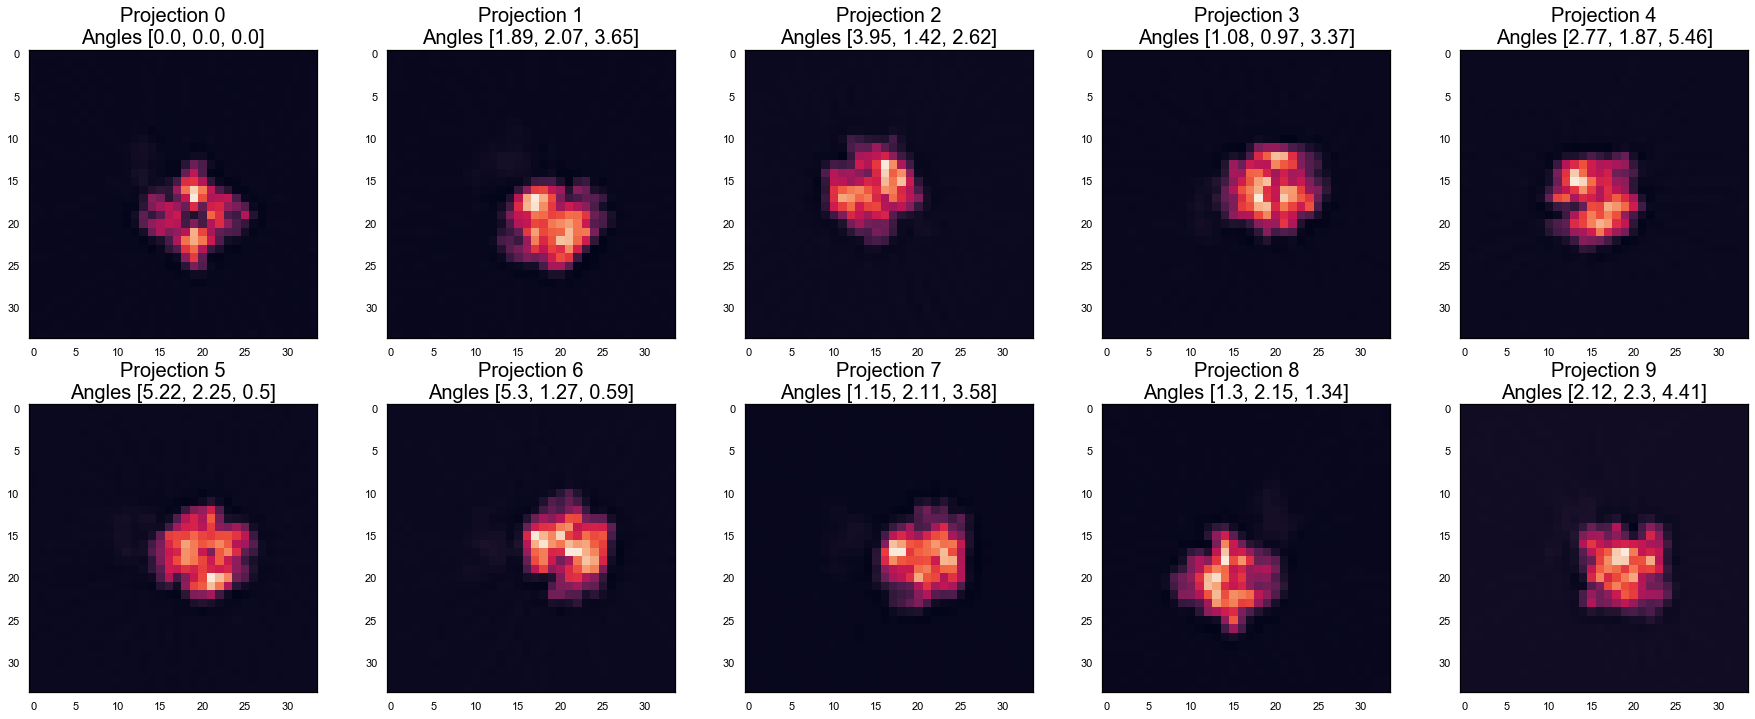

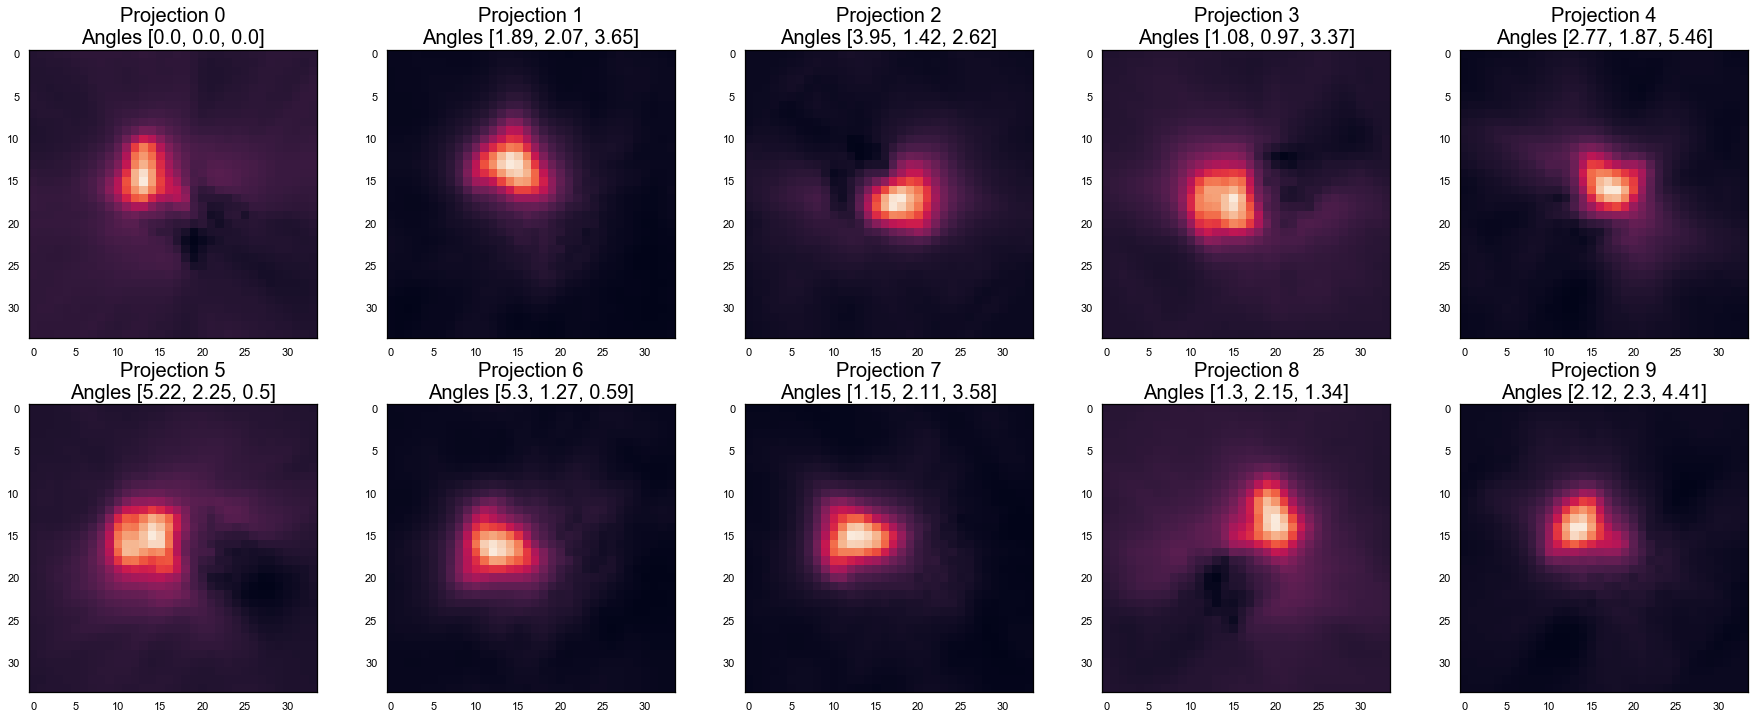

Q 165532081.42869422
delta Q 0.0
Q 170166479.0641363
delta Q 4634397.635442078
Q 175023197.90727136
delta Q 4856718.843135059
Q 180108809.11691266
delta Q 5085611.209641308
Q 185427292.20614097
delta Q 5318483.089228302
Q 190979656.9233416
delta Q 5552364.717200637
Q 196763752.40094858
delta Q 5784095.477606982
Q 202774195.27304178
delta Q 6010442.872093201
Q 209002587.5232605
delta Q 6228392.250218719
Q 215437846.9536792
delta Q 6435259.4304187
Q 222066742.70372987
delta Q 6628895.750050664
The 51-th iteration


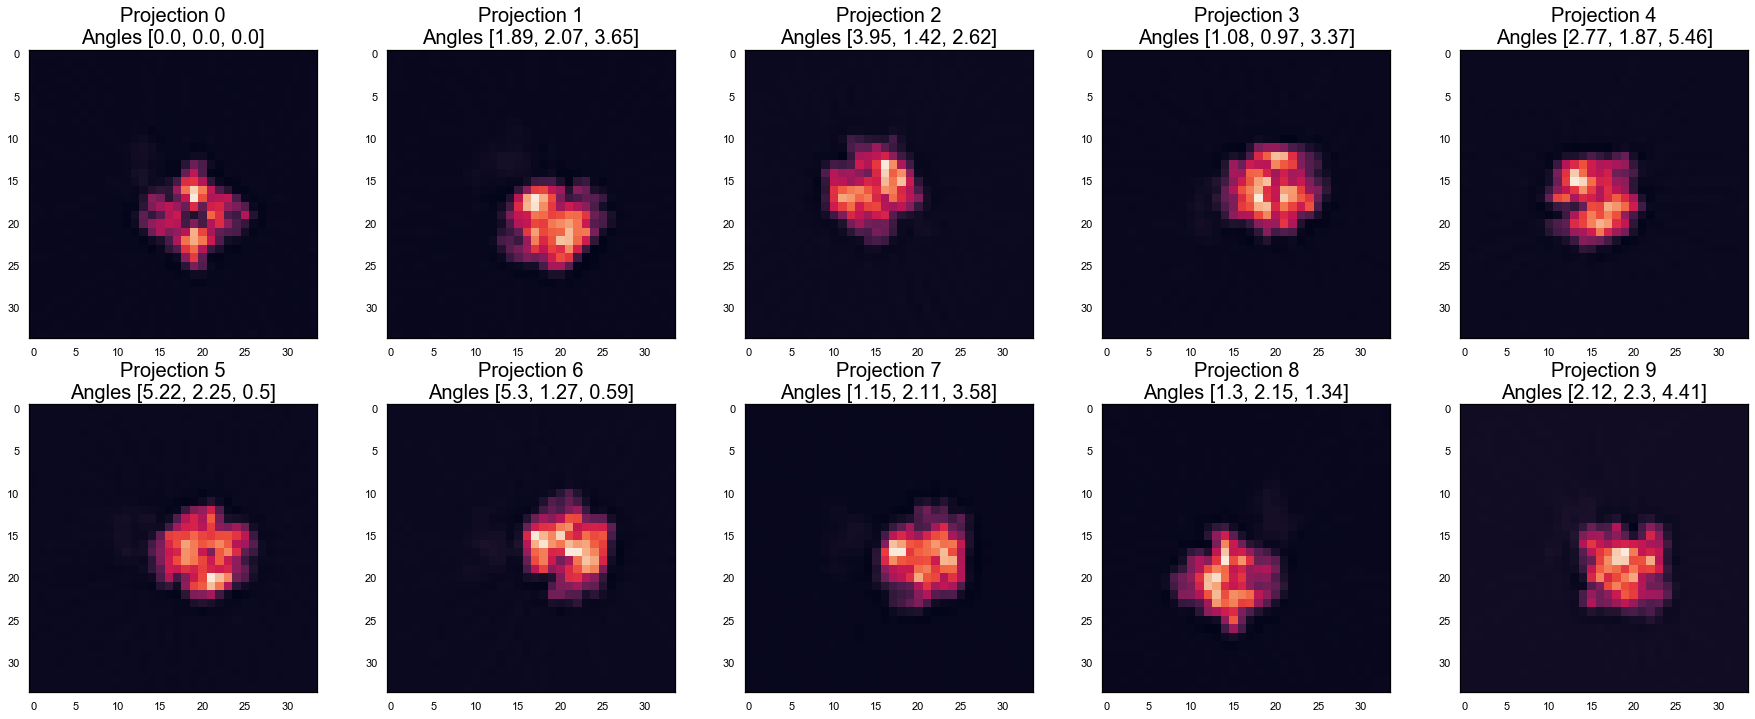

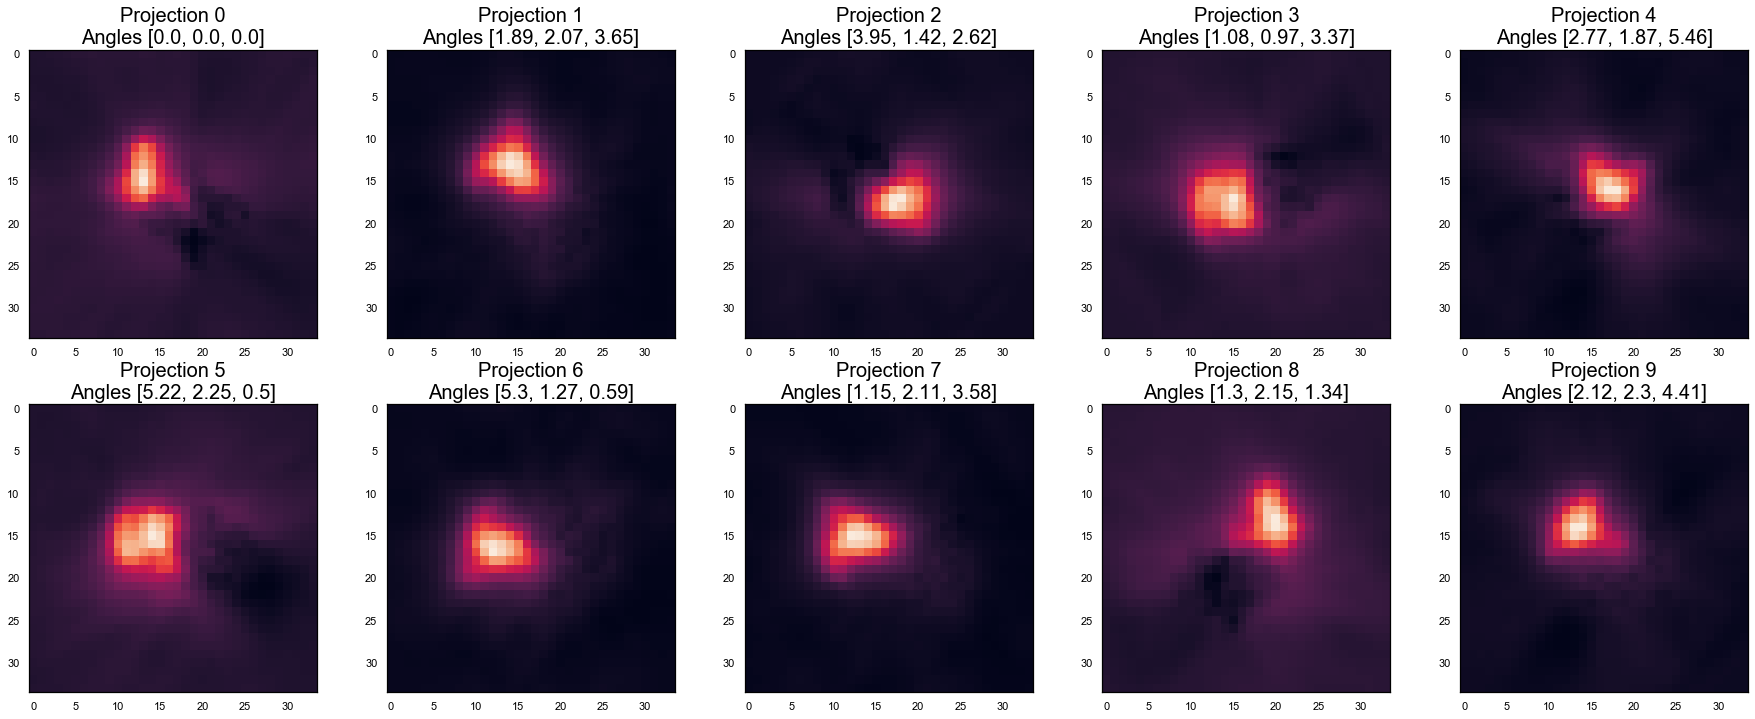

Q 222066742.70372987
delta Q 0.0
Q 228874483.5535681
delta Q 6807740.849838227
Q 235845339.74830386
delta Q 6970856.194735765
Q 242963213.54020923
delta Q 7117873.791905373
Q 250212160.76296768
delta Q 7248947.222758442
Q 257576827.1299622
delta Q 7364666.36699453
Q 265042704.77478442
delta Q 7465877.64482221
Q 272596383.2426065
delta Q 7553678.467822105
Q 280225622.2130486
delta Q 7629238.970442057
Q 287919424.5868495
delta Q 7693802.373800933
Q 295668001.38202137
delta Q 7748576.795171857
The 61-th iteration


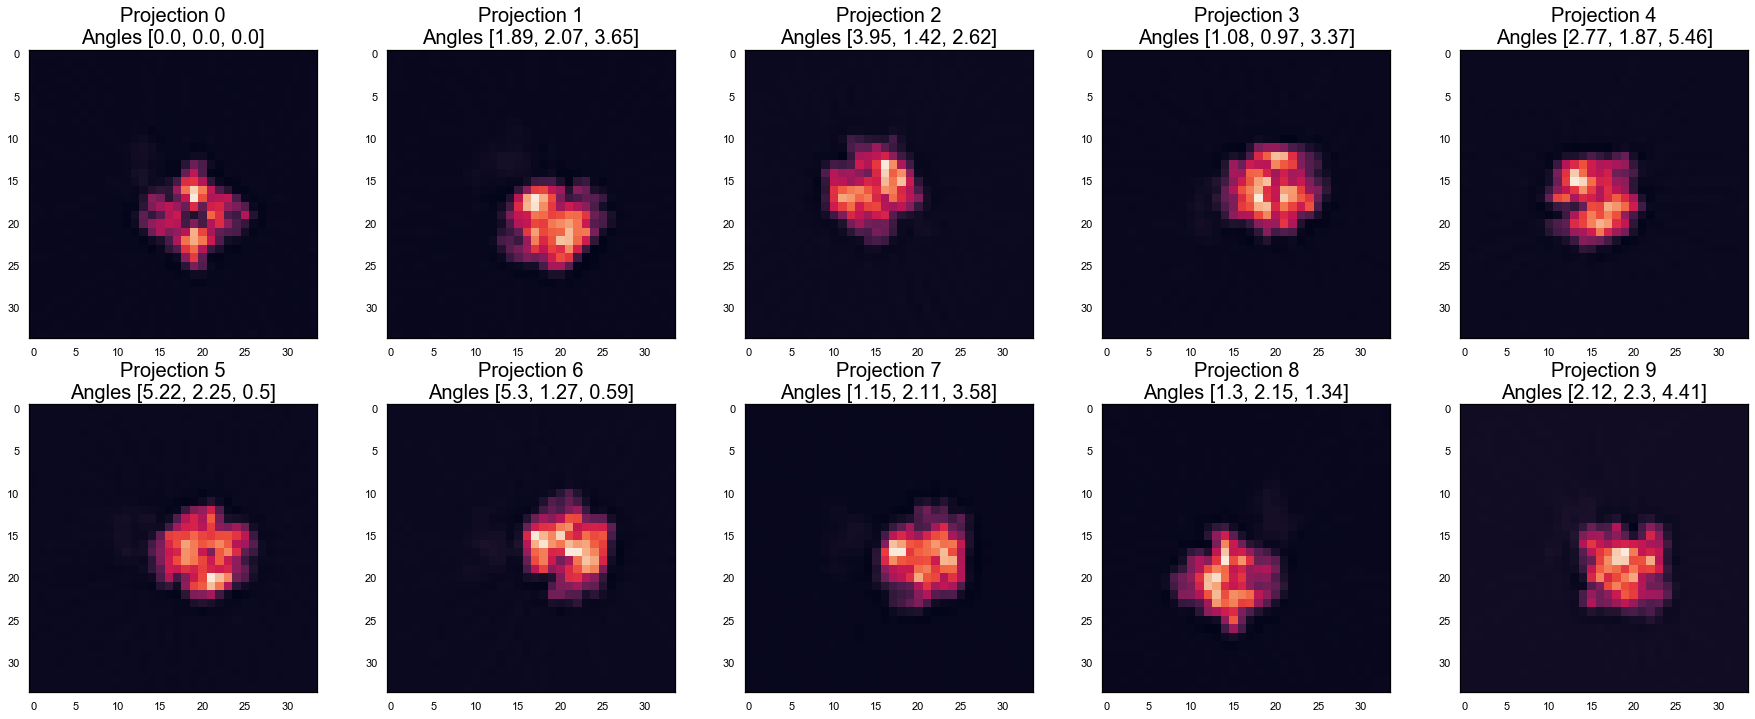

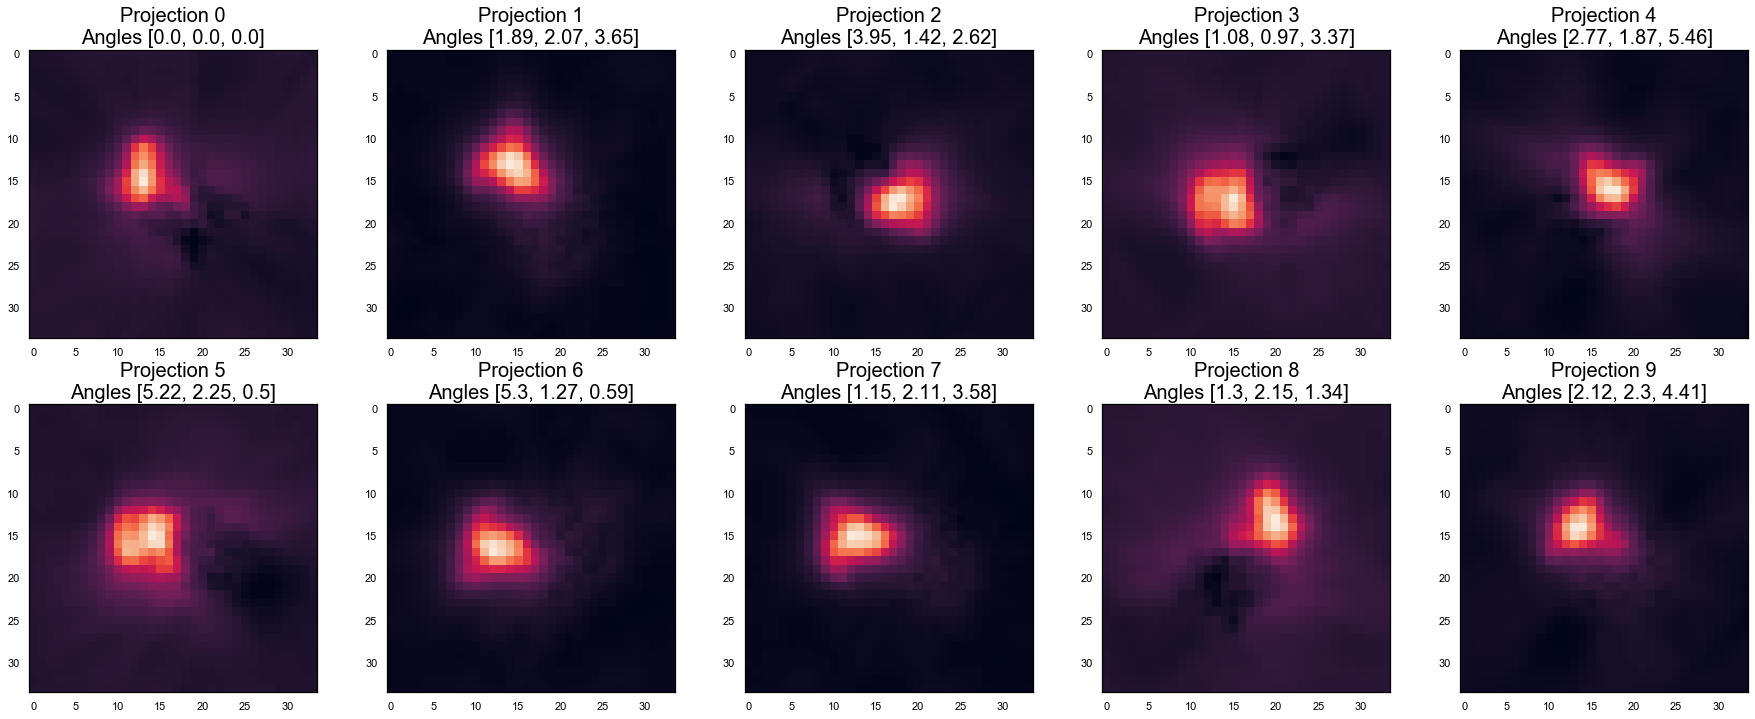

Q 295668001.38202137
delta Q 0.0
Q 303462730.8527438
delta Q 7794729.470722437
Q 311296060.2944014
delta Q 7833329.441657603
Q 319161398.38704306
delta Q 7865338.092641652
Q 327053071.6209396
delta Q 7891673.2338965535
Q 334966139.679999
delta Q 7913068.0590593815
Q 342896350.6664541
delta Q 7930210.986455083
Q 350840046.8167529
delta Q 7943696.150298834
Q 358794061.62035966
delta Q 7954014.803606749
Q 366755654.7766228
delta Q 7961593.156263113
Q 374722459.824022
delta Q 7966805.047399223
The 71-th iteration


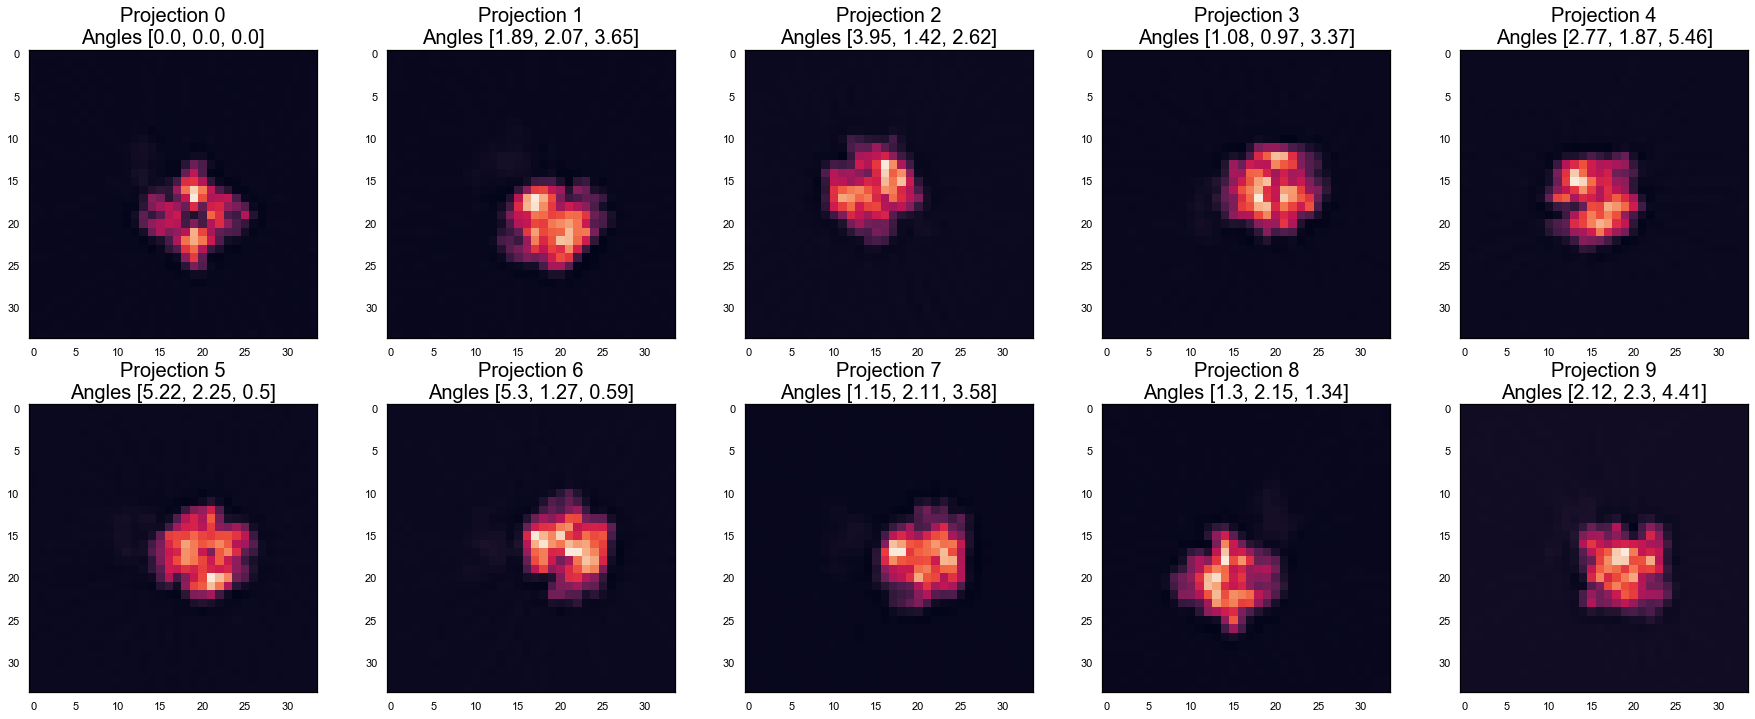

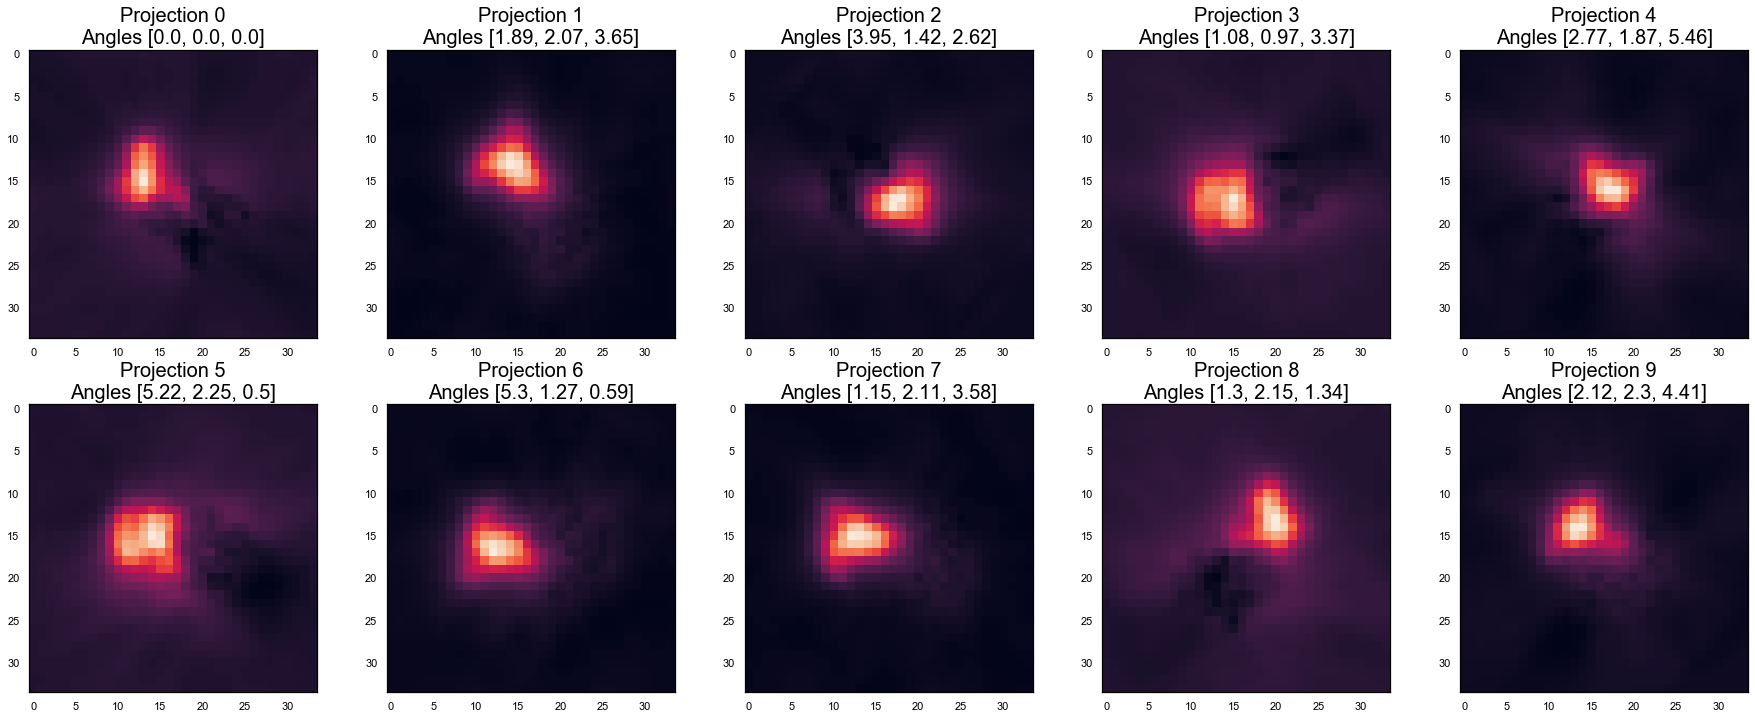

Q 374722459.824022
delta Q 0.0
Q 382692414.91153914
delta Q 7969955.087517142
Q 390663732.29476273
delta Q 7971317.383223593
Q 398634827.5741234
delta Q 7971095.279360652
Q 406604329.10113764
delta Q 7969501.5270142555
Q 414571008.0478649
delta Q 7966678.946727276
Q 422533763.4171976
delta Q 7962755.369332671
Q 430491616.45443124
delta Q 7957853.037233651
Q 438443689.9334192
delta Q 7952073.478987992
Q 446389161.8991717
delta Q 7945471.965752482
Q 454327293.1455331
delta Q 7938131.246361375
The 81-th iteration


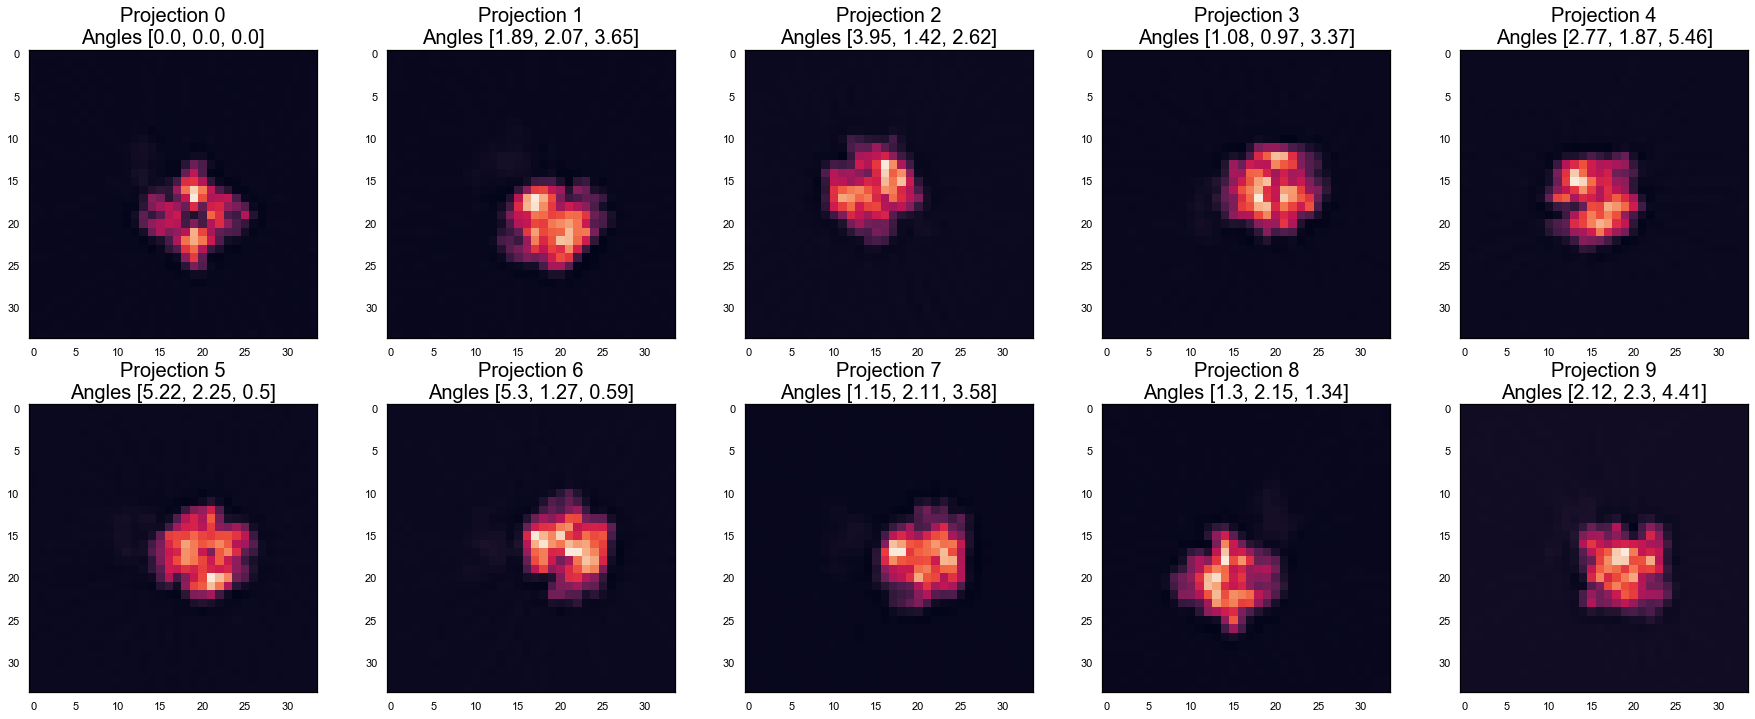

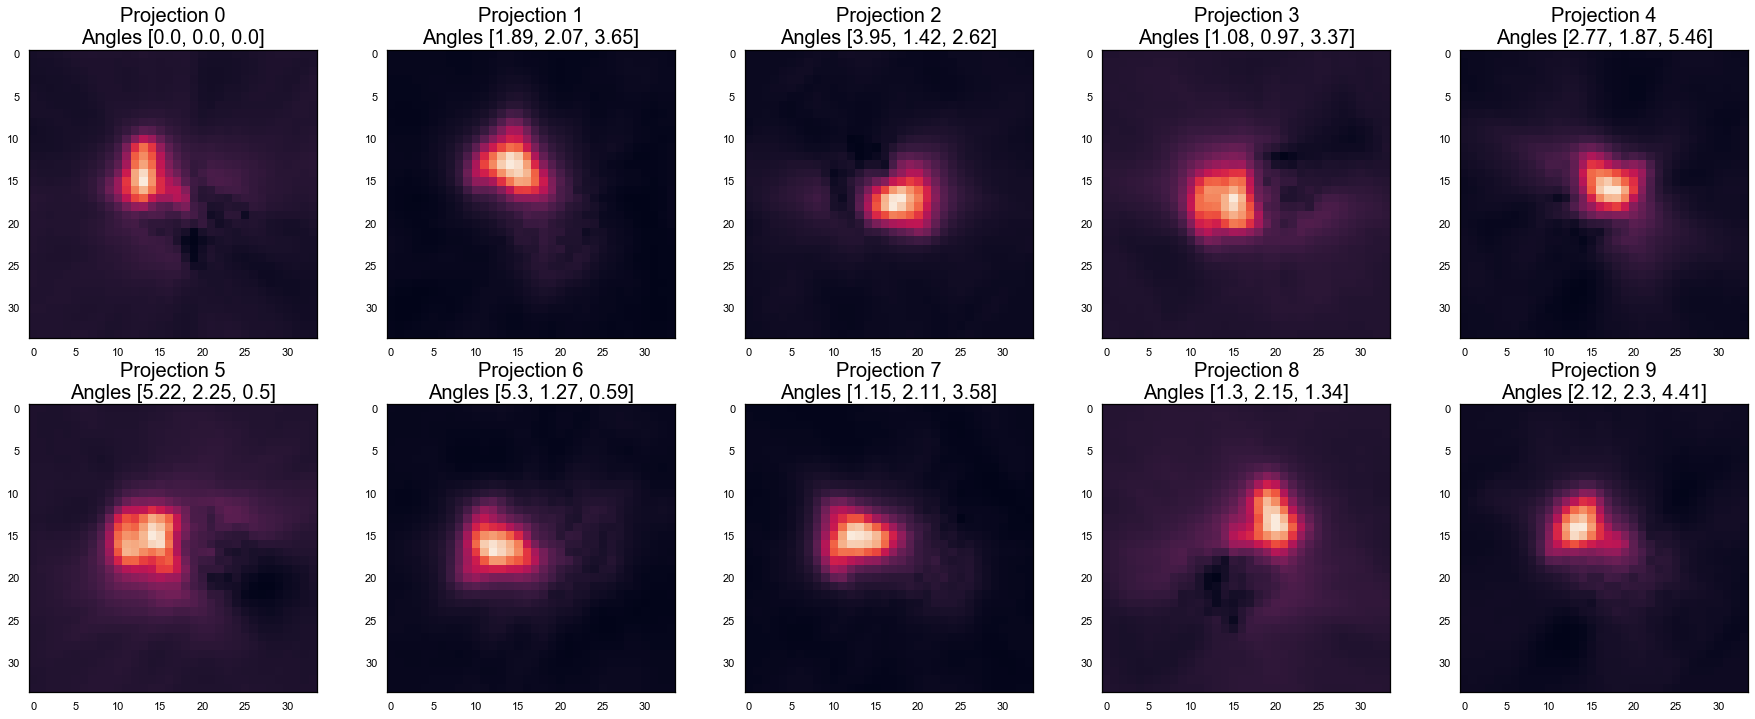

Q 454327293.1455331
delta Q 0.0
Q 462257407.63243556
delta Q 7930114.486902475
Q 470178848.72494733
delta Q 7921441.092511773
Q 478091025.81694543
delta Q 7912177.0919981
Q 485993364.7626054
delta Q 7902338.945659995
Q 493885325.6825374
delta Q 7891960.919931948
Q 501766375.55216676
delta Q 7881049.869629383
Q 509636018.3784389
delta Q 7869642.82627213
Q 517493777.3092484
delta Q 7857758.930809498
Q 525339176.2322682
delta Q 7845398.923019826
Q 533171745.63628215
delta Q 7832569.404013932
The 91-th iteration


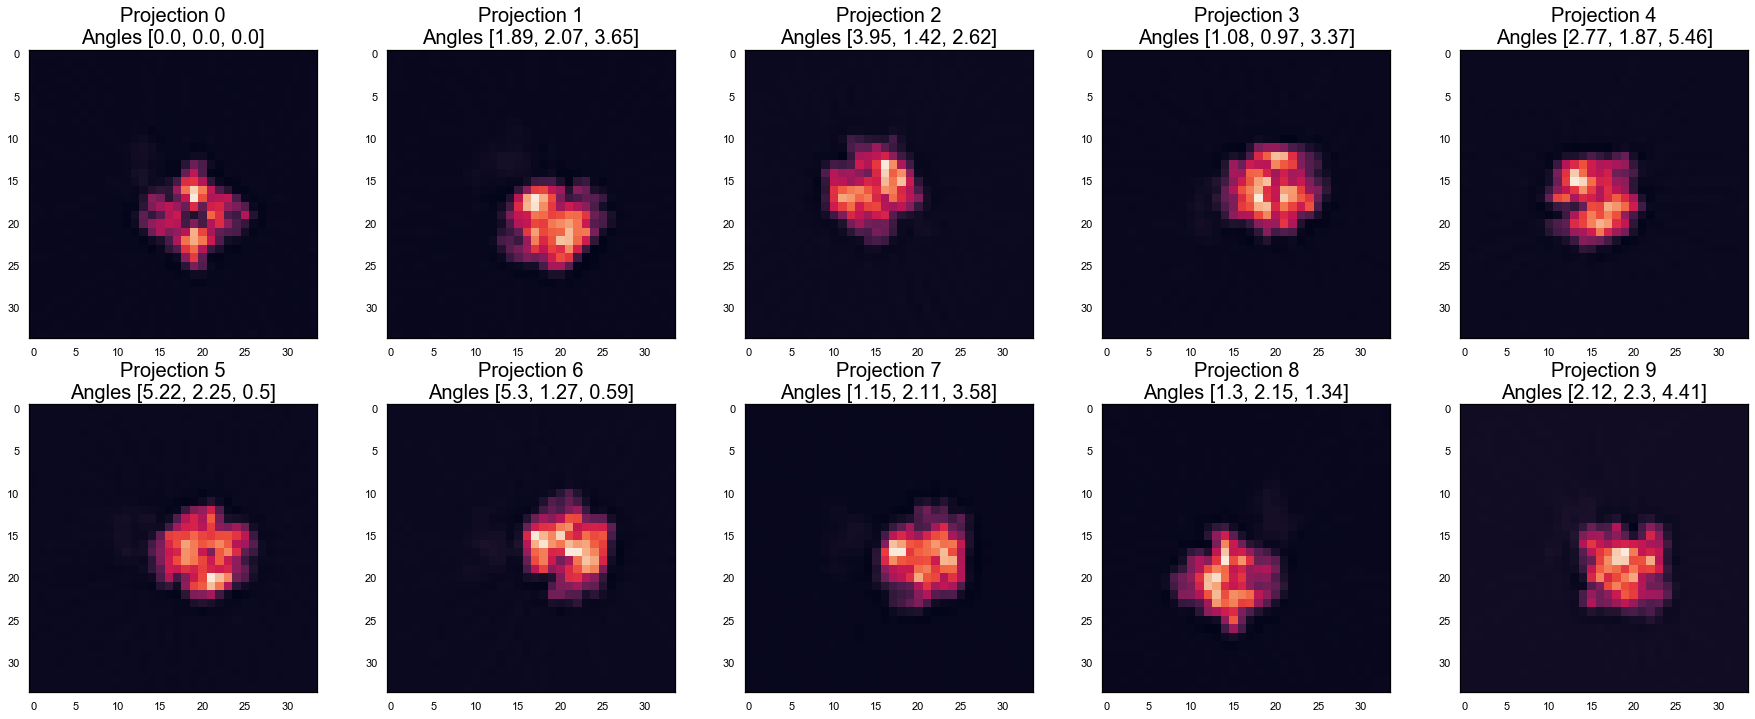

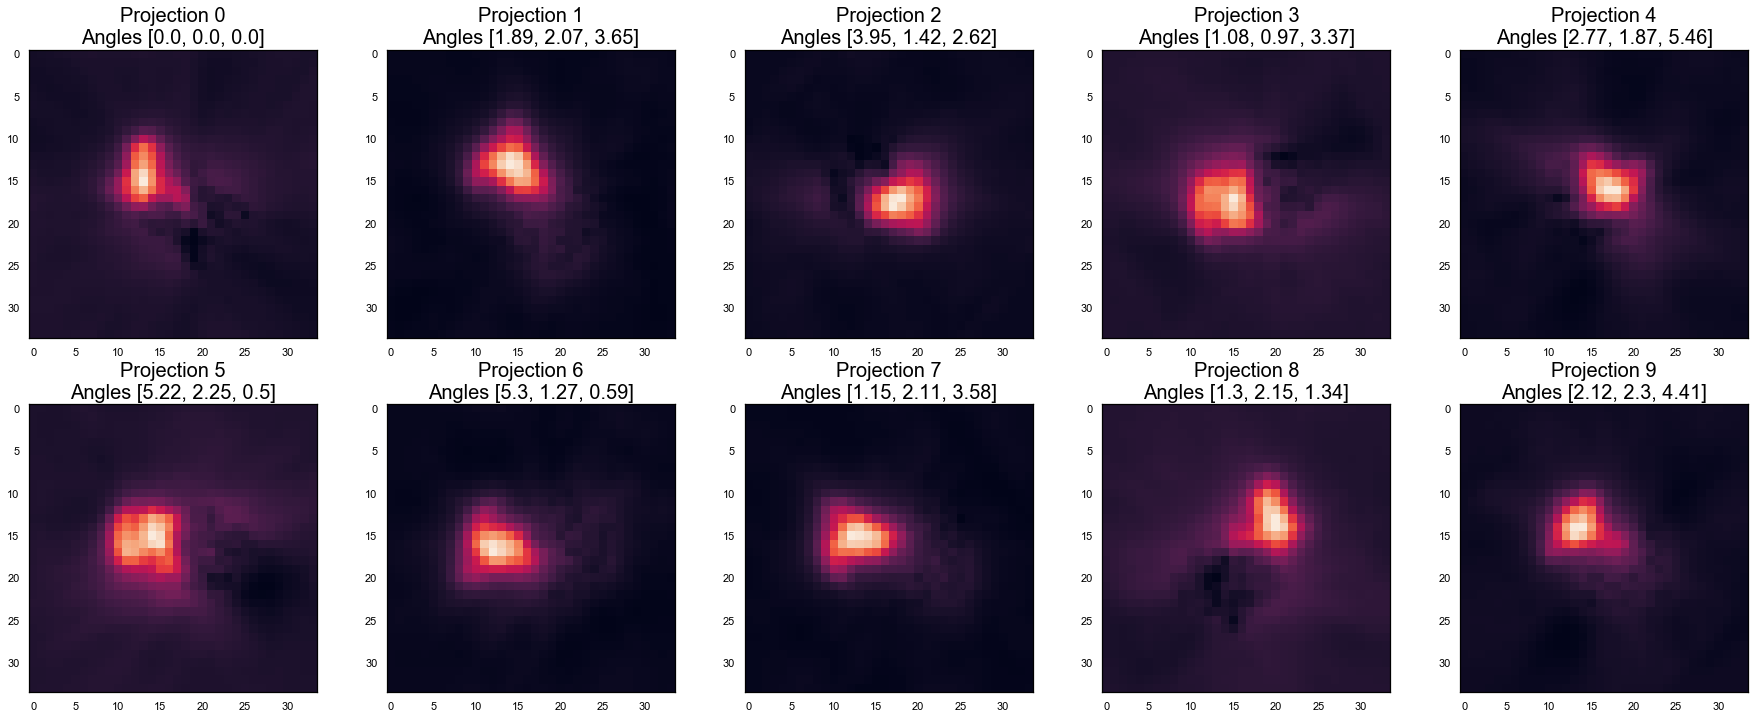

Q 533171745.63628215
delta Q 0.0
Q 540991049.6496583
delta Q 7819304.013376176
Q 548796638.9057282
delta Q 7805589.256069899
Q 556588079.2510234
delta Q 7791440.345295191
Q 564364939.9337208
delta Q 7776860.682697415
Q 572126789.210848
delta Q 7761849.277127147
Q 579873218.1164703
delta Q 7746428.905622363
Q 587603808.0317948
delta Q 7730589.91532445
Q 595318132.0490308
delta Q 7714324.017235994
Q 603015778.6353058
delta Q 7697646.5862749815
Q 610696347.2816751
delta Q 7680568.646369338
The 101-th iteration


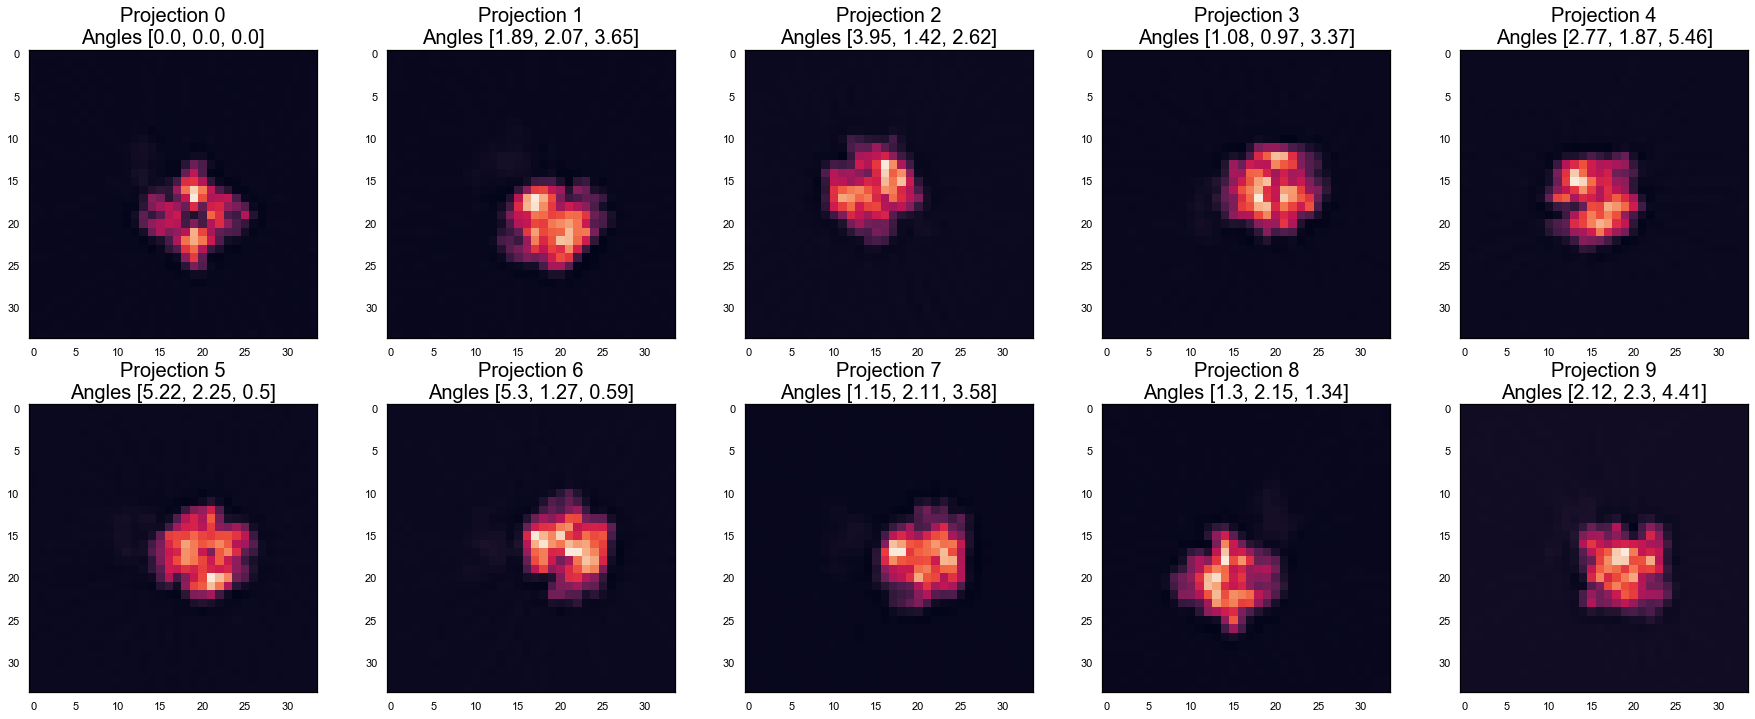

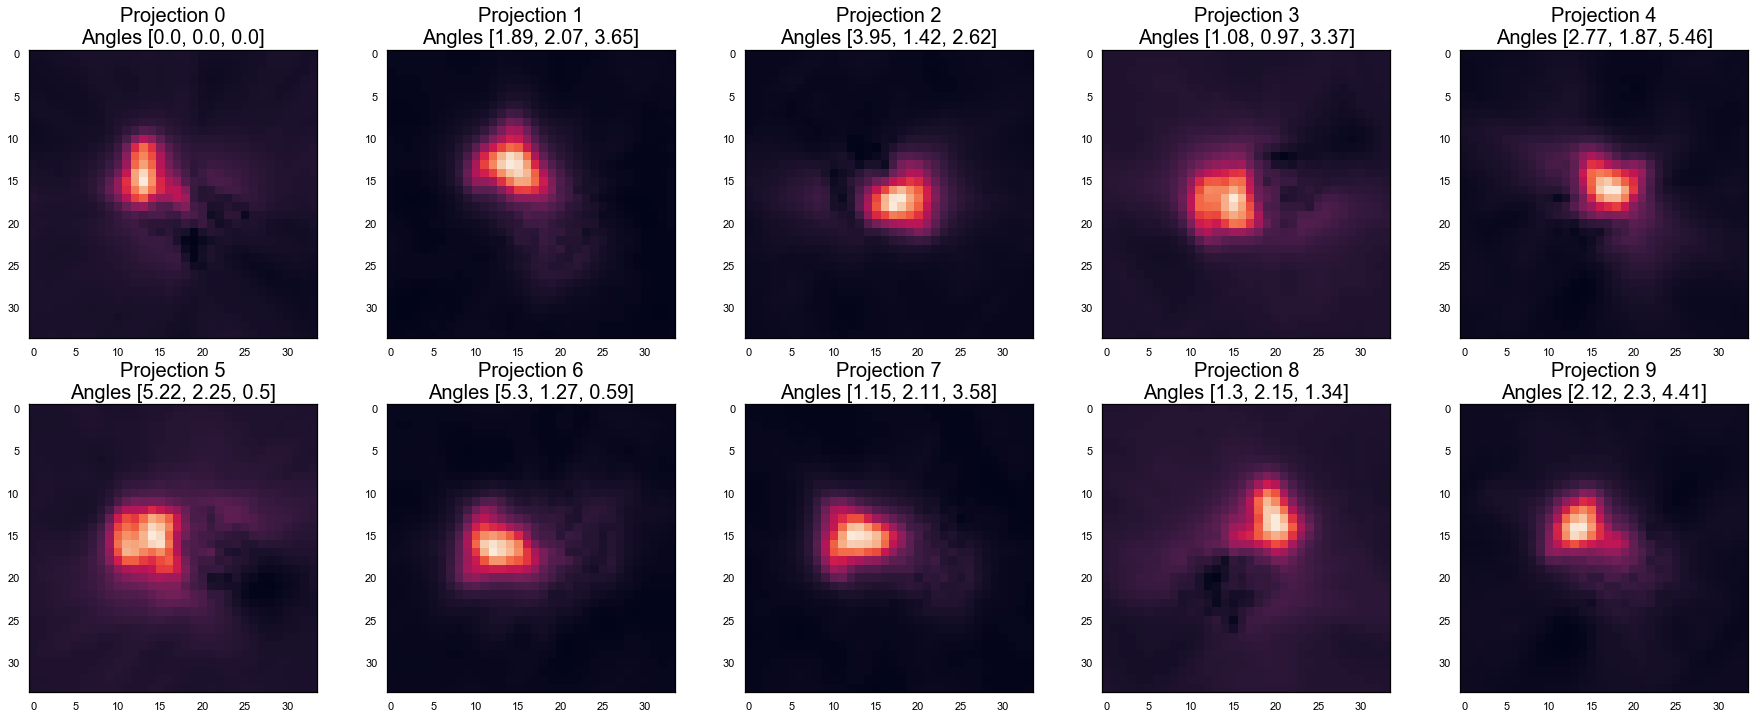

Q 610696347.2816751
delta Q 0.0
Q 618359415.9629687
delta Q 7663068.681293607
Q 626004584.586261
delta Q 7645168.623292327
Q 633631432.5250416
delta Q 7626847.938780546
Q 641239547.3422128
delta Q 7608114.817171216
Q 648828527.3379245
delta Q 7588979.995711684
Q 656397959.2401552
delta Q 7569431.90223074
Q 663947421.2585787
delta Q 7549462.018423438
Q 671476517.6762689
delta Q 7529096.417690277
Q 678984815.2810893
delta Q 7508297.604820371
Q 686471913.8892946
delta Q 7487098.608205318
The 111-th iteration


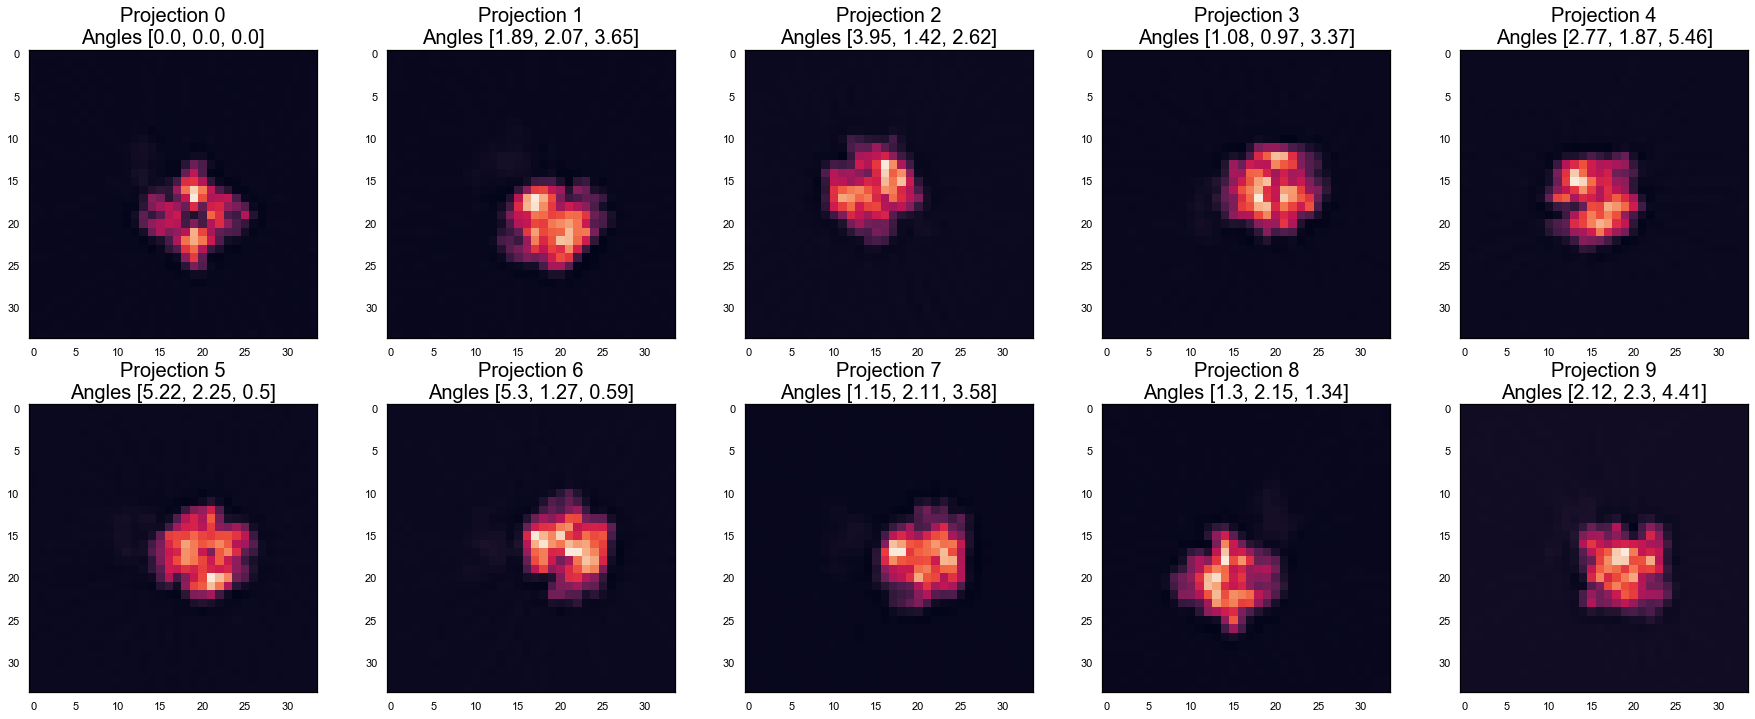

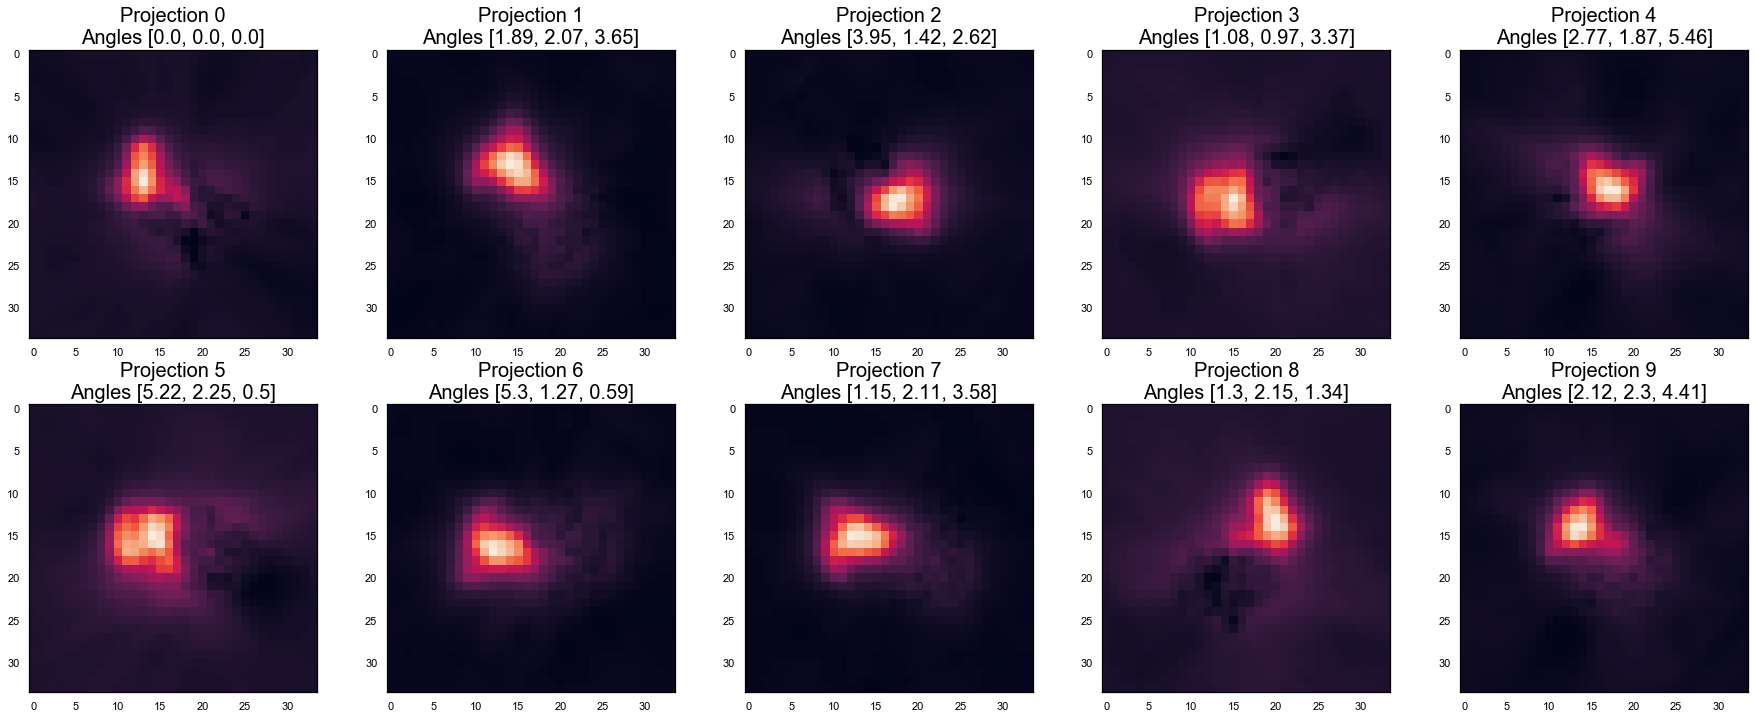

Q 686471913.8892946
delta Q 0.0
Q 693937388.3673505
delta Q 7465474.478055835
Q 701380846.2384055
delta Q 7443457.871055007
Q 708801846.9079796
delta Q 7421000.6695741415
Q 716199978.8711834
delta Q 7398131.963203788
Q 723574822.0891789
delta Q 7374843.217995524
Q 730925948.0746975
delta Q 7351125.985518575
Q 738252957.71129
delta Q 7327009.636592507
Q 745555415.7250556
delta Q 7302458.0137655735
Q 752832902.7513782
delta Q 7277487.026322603
Q 760085002.4234443
delta Q 7252099.6720660925
The 121-th iteration


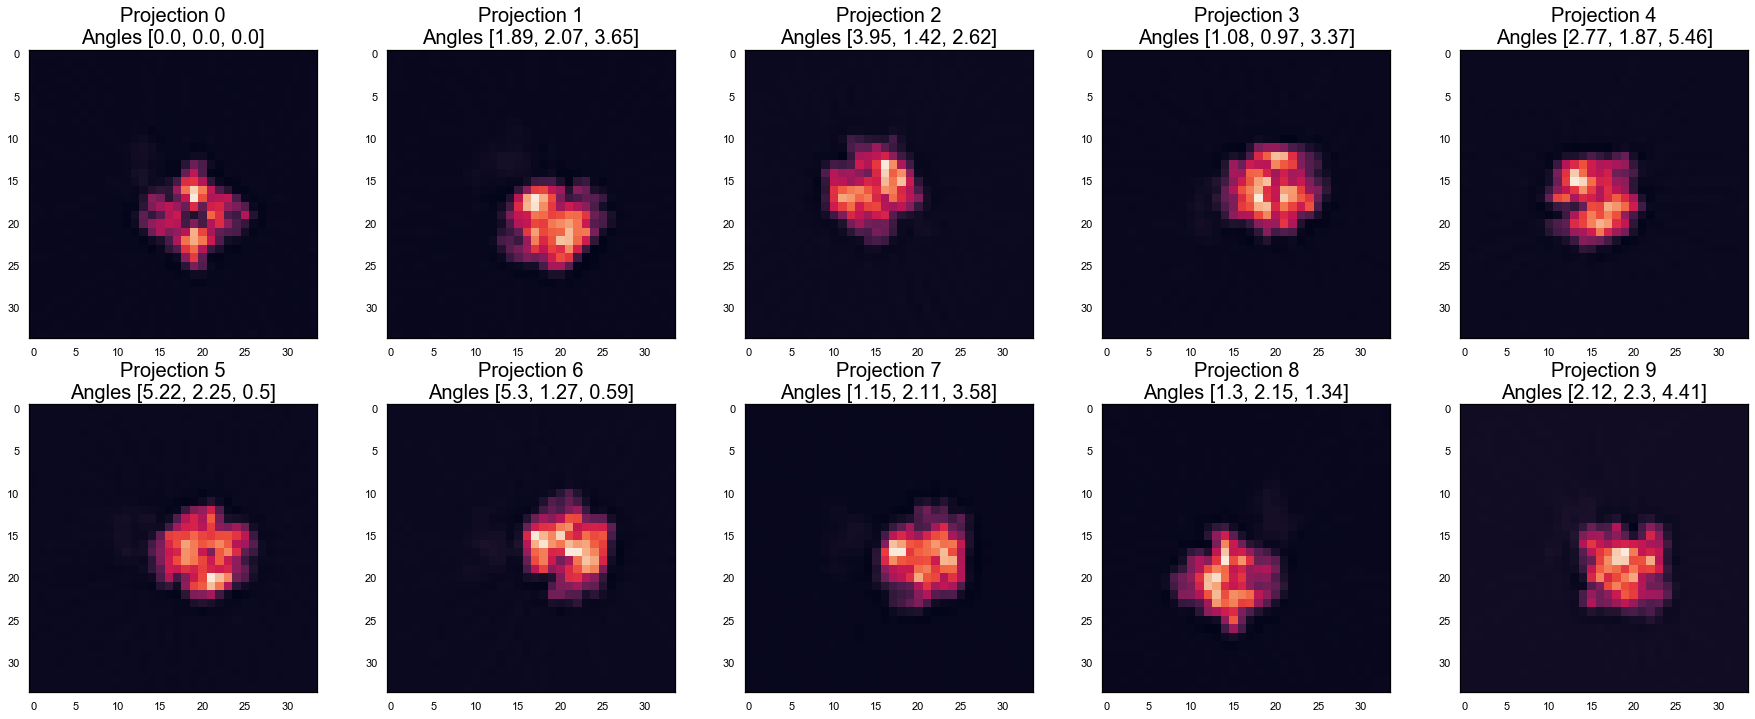

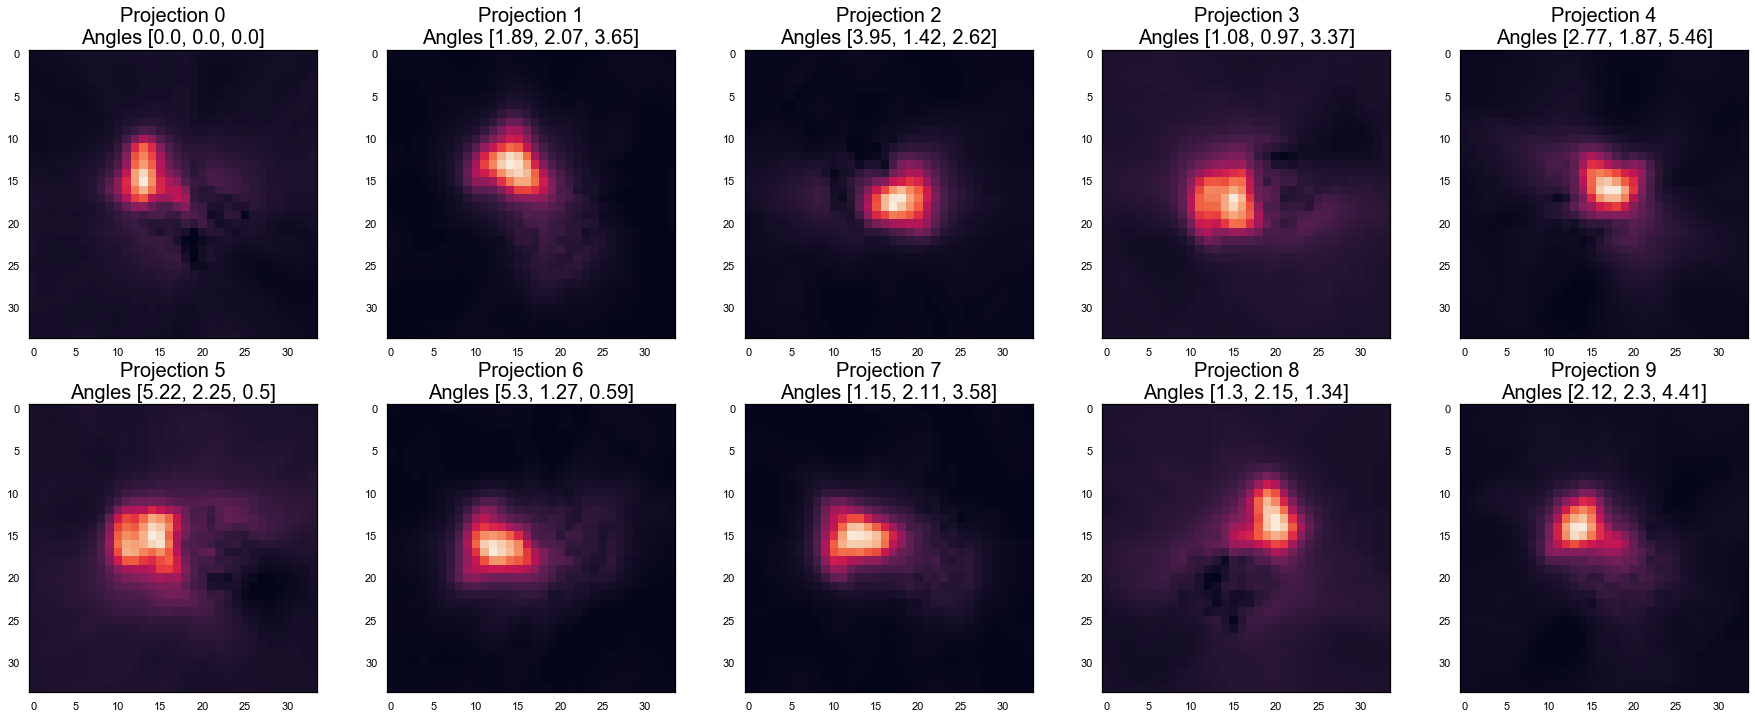

Q 760085002.4234443
delta Q 0.0
Q 767311285.933134
delta Q 7226283.509689689
Q 774511337.9647145
delta Q 7200052.031580567
Q 781684722.8423505
delta Q 7173384.877635956
Q 788831031.6457577
delta Q 7146308.803407192
Q 795949830.9251865
delta Q 7118799.27942884
Q 803040701.5724056
delta Q 7090870.647219062
Q 810103224.5819601
delta Q 7062523.009554505
Q 817136974.540096
delta Q 7033749.9581359625
Q 824141534.8121315
delta Q 7004560.27203548
Q 831116466.2789397
delta Q 6974931.4668082
The 131-th iteration


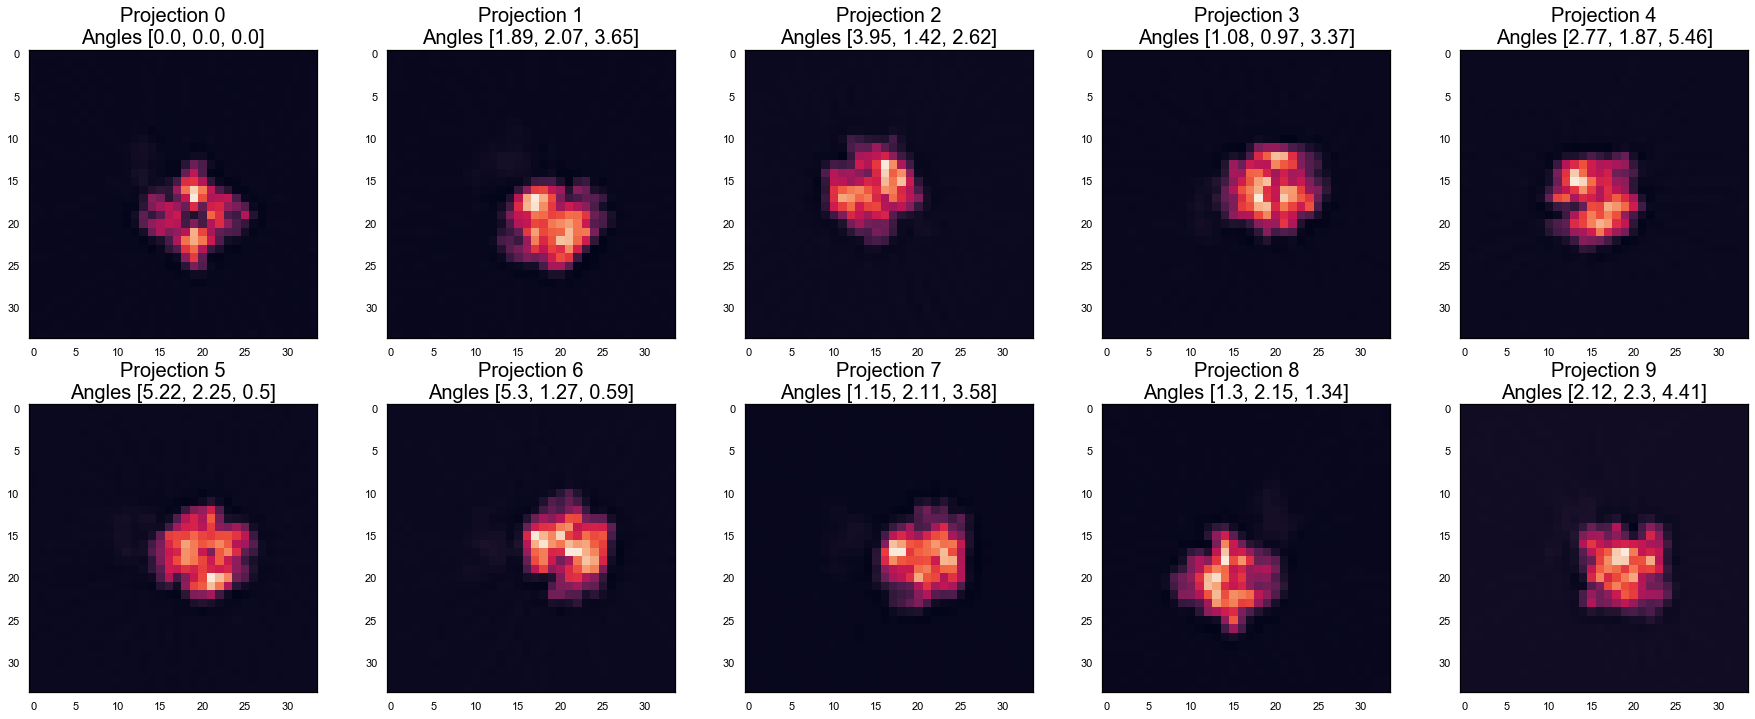

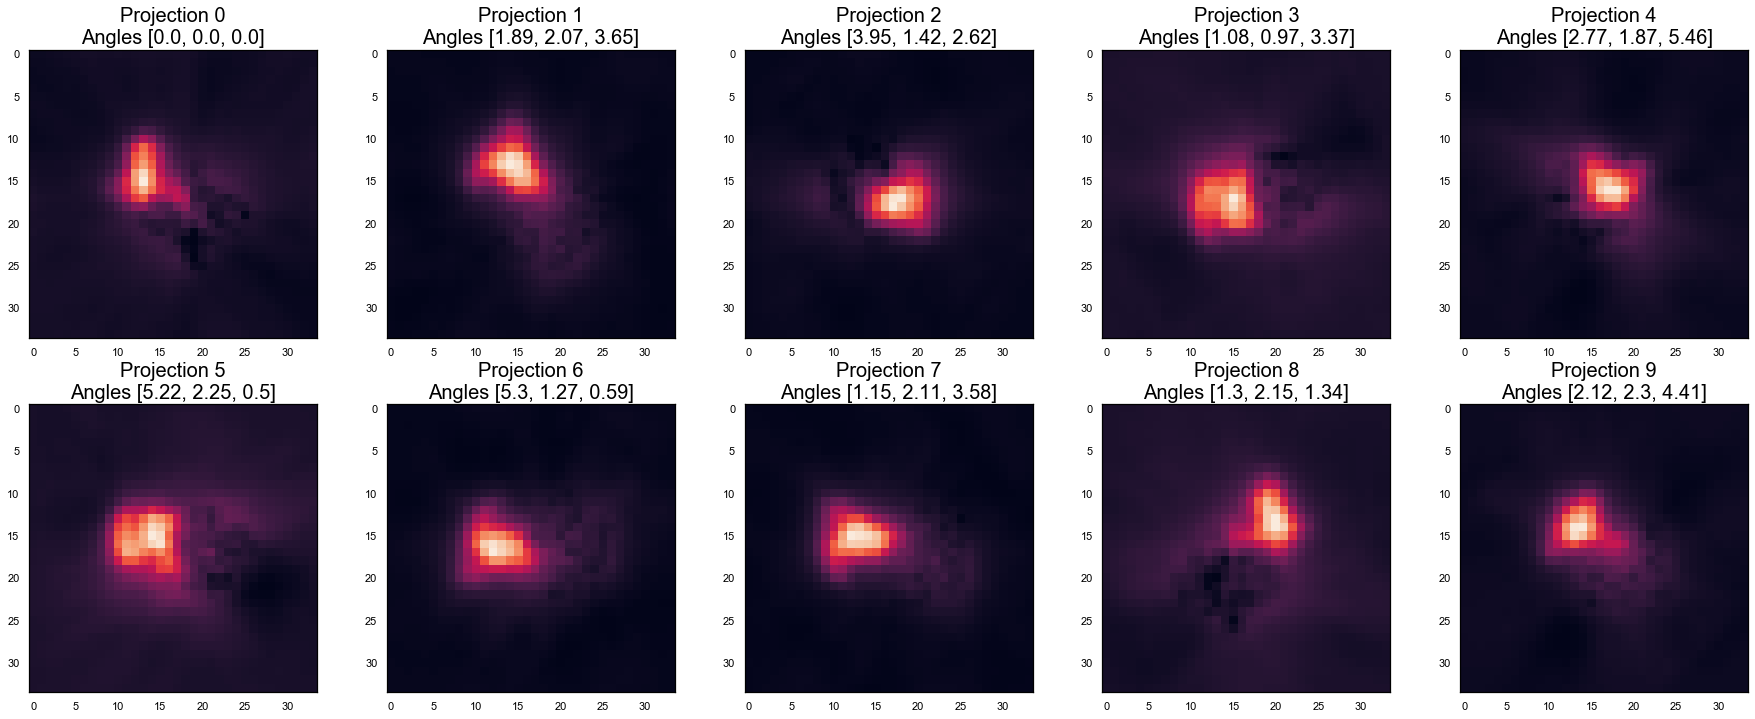

Q 831116466.2789397
delta Q 0.0
Q 838061371.9089897
delta Q 6944905.630049944
Q 844975810.8585696
delta Q 6914438.949579954
Q 851859369.1957152
delta Q 6883558.337145567
Q 858711631.5974131
delta Q 6852262.401697874
Q 865532177.6060051
delta Q 6820546.00859201
Q 872320598.6723423
delta Q 6788421.066337228
Q 879076464.0829068
delta Q 6755865.410564542
Q 885799371.154696
delta Q 6722907.0717891455
Q 892488905.0958288
delta Q 6689533.941132784
Q 899144651.9777924
delta Q 6655746.881963611
The 141-th iteration


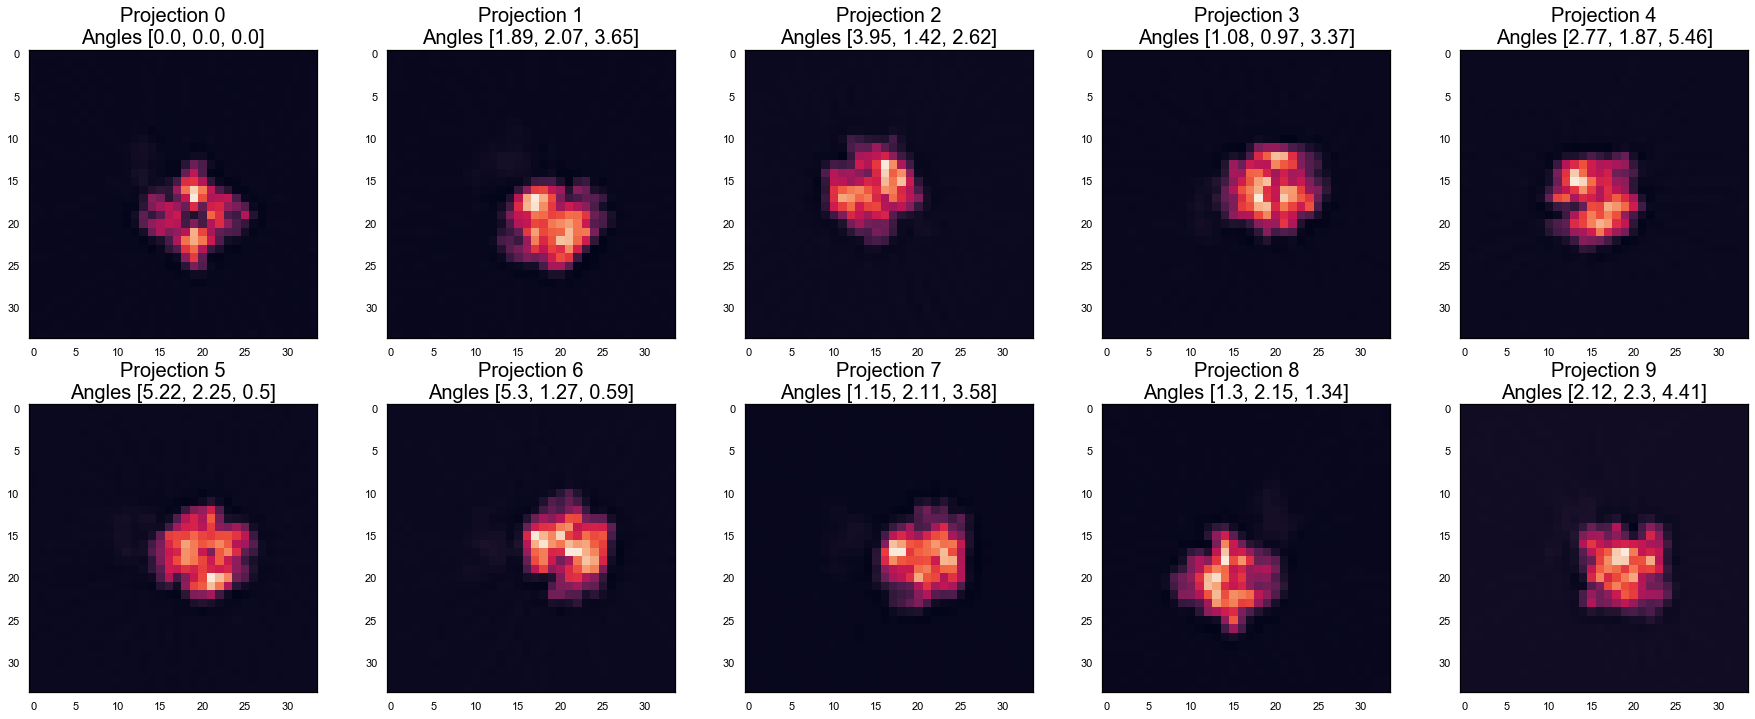

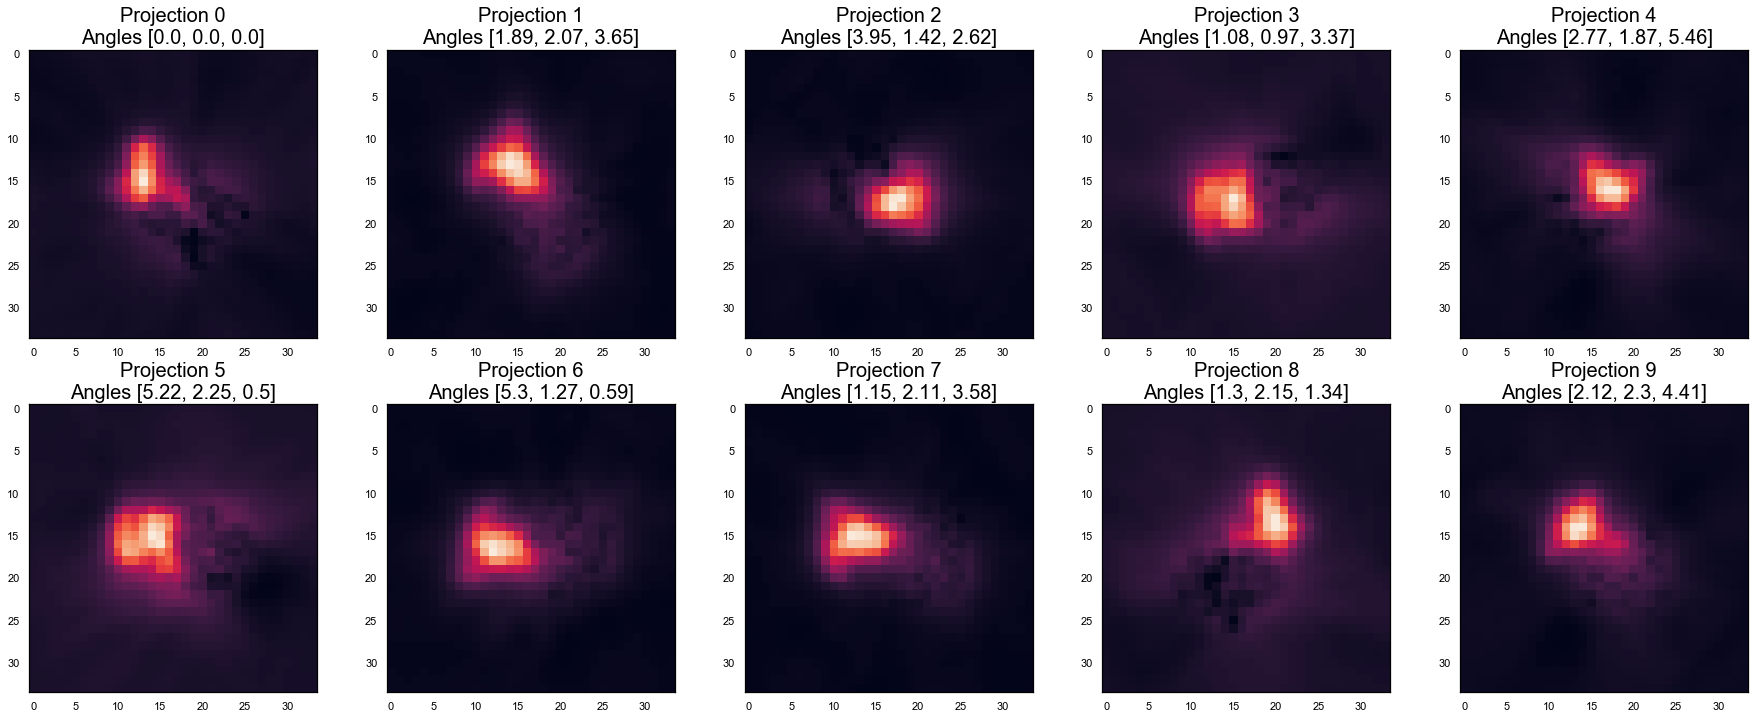

Q 899144651.9777924
delta Q 0.0
Q 905766219.5811422
delta Q 6621567.603349805
Q 912353171.0265955
delta Q 6586951.445453286
Q 918905128.2856705
delta Q 6551957.259075046
Q 925421669.0159016
delta Q 6516540.730231047
Q 931902400.7624645
delta Q 6480731.746562958
Q 938346928.4479947
delta Q 6444527.685530186
Q 944754861.0665306
delta Q 6407932.618535876
Q 951125794.087295
delta Q 6370933.02076447
Q 957459342.724959
delta Q 6333548.63766396
Q 963755127.9440447
delta Q 6295785.219085693
The 151-th iteration


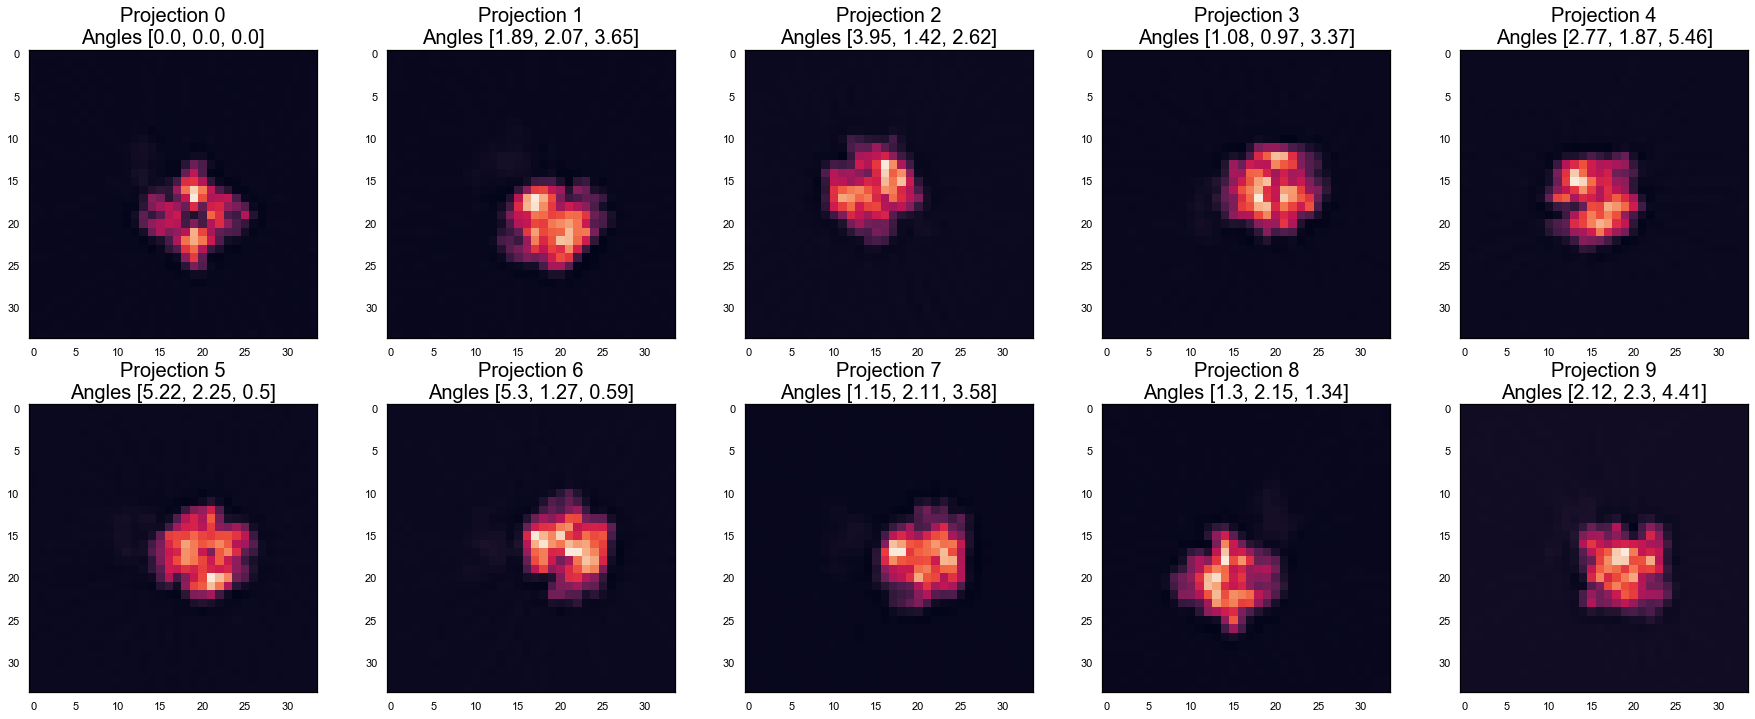

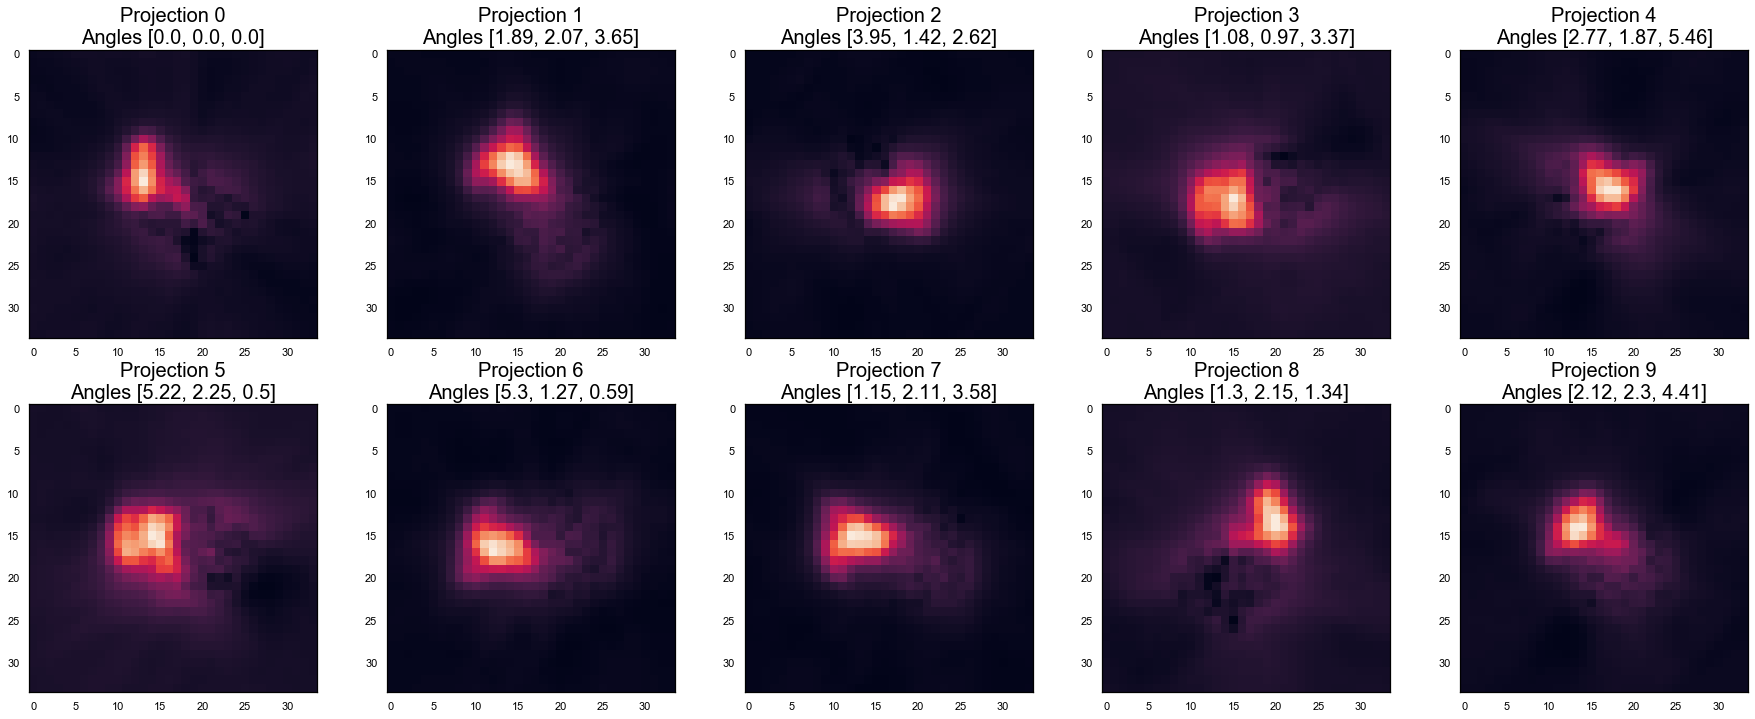

Q 963755127.9440447
delta Q 0.0
Q 970012753.1127354
delta Q 6257625.168690681
Q 976231844.6811696
delta Q 6219091.568434238
Q 982412020.7512361
delta Q 6180176.070066452
Q 988552906.7760587
delta Q 6140886.024822593
Q 994654143.7675692
delta Q 6101236.99151051
Q 1000715360.1286407
delta Q 6061216.361071467
Q 1006736189.3482282
delta Q 6020829.2195875645
Q 1012716262.2879553
delta Q 5980072.939727068
Q 1018655252.7682824
delta Q 5938990.480327129


In [41]:
P3RM.fit(new_projection , angles2)

In [31]:
#Check ro_j whether the same

print(True_z2.reshape(-1)[:5])
print(P3RM.ro[:5,0])
print(True_z1.reshape(-1)[:5])
print(P3RM.ro[:5,1])

print(P3RM.Mus.shape)
vec1 = P3RM.Mus[0].reshape(-1)
vec2 = P3RM.Mus[1].reshape(-1)
print(np.sum(vec1*vec2))
print(np.dot(vec1 ,vec1) /np.linalg.norm(vec1) / np.linalg.norm(vec1))
print(np.sum(vec1*vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2))

[ 2.08751719 -0.25337916 -0.36445553 -0.25359546  0.05210942]
[ 3.21404745 -0.26473339 -0.97069626 -0.60095073 -0.34542855]
[-0.02958446  0.44864975 -1.35269207 -0.68887292 -1.51650291]
[-0.26381879  0.24024991 -0.04960803 -0.12711447 -0.16774667]
(2, 25, 25, 25)
0.0012066971638782348
1.0
0.05023856382097017


In [ ]:
print(np.linalg.norm(Vol2))
print(np.linalg.norm(Vol1))
print(np.linalg.norm(P3R.mu))

In [ ]:
#print(P3R.mu)
ProjSize = ProjSize1
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [ ]:
print('the 2th component')
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
print(curremt_mu.shape)
print('P3RM.Mus[-1]',np.mean(P3RM.Mus[-1]))
print('+P3RM.Mus[0]', np.mean(P3RM.Mus[0]))
print(np.sum(np.abs(P3RM.Mus[-1]+P3RM.Mus[0])))

In [ ]:
curremt_mu = P3RM.Mus[0].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(-CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)